# Code to perform the analysis on Desert Dust (DD) events for every station.
## With coefficient obtained from the first period (01-09-23, 31-08-24) of data collected at Lampedusa site.
### Desert Dust filter
- AOD: $\ge$ 0.15
- ANG: $\le$ 0.5
### ODR Coefficients found in the first period (Lampedusa)
- IMP1F: 1.33 $\pm$ 0.22 
- IMP2F: 1.35 $\pm$ 0.21

In [3]:
# Function to calculate metrics
def calculate_metrics(y_true, y_pred, n): # n is the number of observations and p the parameters of the fit (slope and intercept)

    import numpy as np
    from scipy.stats import pearsonr

    p = 2

    if len(y_true) < 2 or len(y_pred) < 2:
        # Return NaNs or zeros if not enough data
        return [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]
    else:

        # Calculate Bias
        bias = np.mean(y_true - y_pred)

        # Calculate Correlation
        corr, _ = pearsonr(y_true, y_pred)

        # Calculate RMSE
        rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))

        # Calculate NMSE
        mse = np.mean((y_true - y_pred) ** 2)
        var_y = np.var(y_true)
        
        # Calculate r2 (coefficient of determination) for IMP1F, IMP2F
        ss_res = np.sum((y_true - y_pred) ** 2)  # Residual sum of squares
        ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)  # Total sum of squares
        r2 = 1 - (ss_res / ss_tot) if ss_tot != 0 else np.nan  # Avoid division by zero

        # Calculate Adjusted r2
        adj_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1)) if (n - p - 1) != 0 else np.nan  # Avoid division by zero


        return bias, corr, rmse, var_y, mse, r2, adj_r2

def plot_scatter(df, columns, cmap="plasma", stats=True, name="Name Station", m_1=None, c_1=None, m_2=None, c_2=None, save=False, path=None):
    """
    Plots 6 subplots (2x3) from specified columns of a DataFrame with a shared colorbar.

    Parameters:
    - df: pandas DataFrame
    - columns: list of 6 column names, 
               columns[0] = observations,
               columns[1:5] = model predictions,
               columns[5] = angstrom values (for color)
    - cmap: colormap for scatter plot color
    - stats: boolean, whether to display statistical indexes on each subplot
    - name: station name (used as plot title)
    """

    import matplotlib.pyplot as plt

    if m_1 is None:
        m_1 = 0.740
    if c_1 is None:
        c_1 = -0.003
    if m_2 is None:
        m_2 = 0.761
    if c_2 is None:
        c_2 = -0.008

    if len(columns) != 11:
        raise ValueError("You must provide exactly 11 column names.")

    obs = df[columns[0]]
    ang = df[columns[5]]
    err_x = df[columns[6]]
    err_y = df[columns[7]]
    err_y_1 = df[columns[8]]
    err_y_2 = df[columns[9]]
    err_y_3 = df[columns[10]]

    y_fit_1 = m_1 * obs + c_1
    y_fit_2 = m_2 * obs + c_2

    f, axs = plt.subplots(2, 2, figsize=(15, 8), constrained_layout=True, sharex=True, sharey=True)
    axs = axs.flatten()
    plt.suptitle(name, fontsize=16, fontweight='bold', x= 0.45)

    # Normalize color scale for the angstrom values
    norm = plt.Normalize(vmin=ang.min(), vmax=ang.max())

    for i, ax in enumerate(axs):
        pred = df[columns[i+1]]
        colors = plt.colormaps.get_cmap(cmap)(norm(ang))

        if columns[i+1] == "IMP1F":
            for k in range(len(obs)):
                ax.errorbar(
                obs.iloc[k], pred.iloc[k],
                xerr=err_x.iloc[k], yerr=err_y.iloc[k],
                fmt='o', markersize=1,
                markerfacecolor='none', markeredgecolor=colors[k],
                ecolor=colors[k], elinewidth=1, capsize=2, alpha=0.9
                )
        if columns[i+1] == "IMP2F":
            for k in range(len(obs)):
                ax.errorbar(
                obs.iloc[k], pred.iloc[k],
                xerr=err_x.iloc[k], yerr=err_y_1.iloc[k],
                fmt='o', markersize=1,
                markerfacecolor='none', markeredgecolor=colors[k],
                ecolor=colors[k], elinewidth=1, capsize=2, alpha=0.9
                )
        if columns[i+1] == "IMP1F_ODR":
            #ax.plot(obs, y_fit_1, lw=1, c=plt.get_cmap("tab10")(5))
            for k in range(len(obs)):
                ax.errorbar(
                obs.iloc[k], pred.iloc[k],
                xerr=err_x.iloc[k], yerr=err_y_2.iloc[k],
                fmt='o', markersize=1,
                markerfacecolor='none', markeredgecolor=colors[k],
                ecolor=colors[k], elinewidth=1, capsize=2, alpha=0.9
                )
            # ax.errorbar(obs, pred, xerr=err_x, yerr=err_y, fmt='', color=None, ecolor='black',
            #      elinewidth=1, capsize=3, alpha=0.9, label='Data', linestyle='none')
        if columns[i+1] == "IMP2F_ODR":
            for j in range(len(obs)):
                ax.errorbar(
                obs.iloc[j], pred.iloc[j],
                xerr=err_x.iloc[j], yerr=err_y_3.iloc[j],
                fmt='o', markersize=1,
                markerfacecolor='none', markeredgecolor=colors[j],
                ecolor=colors[j], elinewidth=1, capsize=2, alpha=0.9
                )
            #ax.plot(obs, y_fit_2, lw=1, c=plt.get_cmap("tab10")(5))
            # ax.errorbar(obs, pred, xerr=err_x, yerr=err_y_1, fmt='', color=None, ecolor='black',
            #      elinewidth=1, capsize=3, alpha=0.9, label='Data', linestyle='none')
            
        # Scatter plot with colors based on angstrom and colormap
        sc = ax.scatter(obs, pred, c=ang, cmap=cmap, norm=norm, edgecolor='none', alpha=0.8)

        min_val = min(obs.min(), pred.min())
        max_val = max(obs.max(), pred.max())
        ax.plot([min_val, max_val], [min_val, max_val], 'k--', lw=1)

        #ax.set_xlabel(f"Obs ({columns[0]})")
        #ax.set_ylabel(f"Mod ({columns[i]})")
        ax.set_title(columns[i+1])
        #ax.set_aspect('equal', adjustable='box')
        ax.grid(True)

        if stats:
            r2 = 0.0
            if columns[i+1] == "IMP1F" or columns[i+1] == "IMP2F":
                metrics = calculate_metrics(obs, pred, len(obs))
                stat_text = (f"Bias: {metrics[0]:.3f}\n"
                         f"Corr: {metrics[1]:.3f}\n"
                         f"MSE: {metrics[4]:.3f}\n"
                         f"RMSE: {metrics[2]:.3f}\n"
                         f"R2: {metrics[5]:.3f}")
            if columns[i+1] == "IMP1F_ODR":
                metrics = calculate_metrics(obs, pred, len(obs))
                r2 = calculate_metrics(obs, y_fit_1, len(obs))
                stat_text = (f"Bias: {metrics[0]:.3f}\n"
                         f"Corr: {metrics[1]:.3f}\n"
                         f"RMSE: {metrics[2]:.3f}\n"
                         fr"$R^2$: {r2[5]:.3f}")
            if columns[i+1] == "IMP2F_ODR":
                metrics = calculate_metrics(obs, pred, len(obs))
                r2 = calculate_metrics(obs, y_fit_2, len(obs))
                stat_text = (f"Bias: {metrics[0]:.3f}\n"
                         f"Corr: {metrics[1]:.3f}\n"
                         f"RMSE: {metrics[2]:.3f}\n"
                         fr"$R^2$: {r2[5]:.3f}")
            ax.text(0.15, 0.77, stat_text,
                    transform=ax.transAxes,
                    fontsize=9, color='black',
                    ha='right', va='bottom',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

    # Create a single colorbar for all subplots
    f.supxlabel(r"Obs ($\tau$)", fontsize=14, x=0.45)
    cbar = f.colorbar(sc, ax=axs, orientation='vertical', fraction=0.02, pad=0.04)
    cbar.set_label(r"$\alpha_{440-870}$", fontsize=14)

    if save: 
        plt.savefig(path, format='png', dpi=300, bbox_inches='tight')
    plt.show()
    
def odr_linear_fit_plot(df, x_col, y_col, x_err_col, y_err_col, title=None, palette='tab10', save=False, path=None):
    """
    Perform ODR linear regression and plot both the fit and residuals.

    Parameters:
    - df: DataFrame with data
    - x_col, y_col: column names for x and y
    - x_err_col, y_err_col: column names for x and y errors
    - title: plot title (optional)

    Returns:
    - popt: [slope, intercept]
    - perr: [slope_err, intercept_err]
    - residuals: y - fit(x)
    - output: full ODR output
    - fig: matplotlib figure object
    """

    import numpy as np
    from scipy.odr import ODR, Model, RealData, Data
    import matplotlib.pyplot as plt

    color_data = plt.get_cmap(palette)(0)
    color_fit = plt.get_cmap(palette)(1)
    color_resid = plt.get_cmap(palette)(2)

    # Define the linear model
    def linear_func(B, x):
        return B[0] * x # B[0] = slope, B[1] = intercept

    # Extract and clean data
    x = df[x_col].values
    y = df[y_col].values
    x_err = df[x_err_col].values
    y_err = df[y_err_col].values

    if np.all(x_err == 0) or np.all(y_err == 0):
        print(f"No error in x or y for {title}")
        from scipy.stats import linregress
        slope, intercept, r_value, p_value, std_err = linregress(x, y)
        y_fit = slope * x + intercept
        residuals = y - y_fit

        # Determine axis limits for 1:1 line and square plot
        min_val = min(np.min(x), np.min(y))
        max_val = max(np.max(x), np.max(y))
        buffer = 0.05 * (max_val - min_val)
        lims = [min_val - buffer, max_val + buffer]

        # Plotting
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8), dpi=120)

        # --- Scatter plot + fit ---
        ax1.scatter(x, y, label='Training Data', alpha=0.7, edgecolor='k')
        ax1.plot(np.sort(x), slope * np.sort(x) + intercept, 'r-', lw=2,
                label=f'Fit: y = {slope:.2f}x + {intercept:.2f}\n$R^2$ = {r_value**2:.3f}')
        ax1.plot(lims, lims, 'k--', lw=1, label='1:1 line')

        ax1.set_title(f'{title} (OLS)', fontsize=12)
        ax1.set_xlabel(r"Obs ($\tau$)")
        ax1.set_ylabel(y_col)
        ax1.set_xlim(lims)
        ax1.set_ylim(lims)
        ax1.set_xlabel(r"Obs ($\tau$)")
        ax1.set_aspect('equal', adjustable='box')
        ax1.grid(True, linestyle='--', alpha=0.4)
        ax1.legend()

        # --- Residuals plot ---
        ax2.axhline(0, color='black', ls='--', lw=1)
        ax2.scatter(x, residuals, color='purple', alpha=0.7, edgecolor='k')
        ax2.set_title("Residuals", fontsize=12)
        ax2.set_xlabel(r"Obs ($\tau$)")
        ax2.set_ylabel("Residual (y - fit)")
        ax2.grid(True, linestyle='--', alpha=0.4)

        plt.tight_layout()
        plt.show()

        return slope, intercept, r_value, p_value, std_err, residuals

    # Filter out invalid data (zero or NaN errors)
    mask = (x_err > 0) & (y_err > 0) & ~np.isnan(x_err) & ~np.isnan(y_err)
    x, y, x_err, y_err = x[mask], y[mask], x_err[mask], y_err[mask]

    # Run ODR
    model = Model(linear_func)
    data = RealData(x, y, sx=x_err/x, sy=y_err/y) # errore pesato sul valore di AOD 
    odr = ODR(data, model, beta0=[1.0])
    output = odr.run()
    popt = output.beta
    perr = output.sd_beta

    # Compute fit and residuals
    y_fit = linear_func(popt, x)
    residuals = y - y_fit

    # Plot: main plot + residuals
     # Determine common limits for 1:1 line and equal aspect
    min_val = min(np.min(x), np.min(y))
    max_val = max(np.max(x), np.max(y))
    buffer = 0.1 * (max_val - min_val)
    #lims = [min_val - buffer, max_val + buffer]
    lims = [-1., max_val + buffer]
    lims_1 = [0., max_val + buffer]

    # Plot: main plot + residuals
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=False,
                                   gridspec_kw={'height_ratios': [2, 1]}, constrained_layout=True)

    # --- Top plot: data + fit ---
    ax1.errorbar(x, y, xerr=x_err, yerr=y_err, fmt='o', color=color_data, ecolor=color_data,
                 elinewidth=1, capsize=3, alpha=0.8, label='Training Data')

    # Fitted line
    x_fit_line = np.linspace(*lims, 500)
    y_fit_line = linear_func(popt, x_fit_line)
    ax1.plot(x_fit_line, y_fit_line, '-', color=color_fit, lw=2,
             label=fr'Fit: y = {popt[0]:.3f}x $\pm$ {perr[0]:.3f};''\n'
                   fr'Correction: {(1/popt[0]):.3f} $\pm$ {(perr[0]/(popt[0]**2)):.3f}')

    # 1:1 reference line
    ax1.plot(lims, lims, '--', color='gray', lw=1, label='1:1 line')

    ax1.set_xlim(lims_1)
    ax1.set_ylim(lims_1)
    ax1.set_aspect('equal', adjustable='box')
    ax1.set_ylabel(y_col)
    ax1.set_xlabel(r"$\tau$ (OBS.)")
    ax1.set_title(title or 'ODR Linear Fit')
    ax1.grid(True, linestyle='--', alpha=0.5)
    ax1.legend()

    # --- Bottom plot: residuals ---
    ax2.axhline(0, color='gray', linestyle='--')
    ax2.set_xlim(lims)
    ax2.set_ylim(lims)
    ax2.errorbar(x, residuals, yerr=y_err, xerr=x_err, fmt='o',
                 capsize=3, ecolor=color_resid, alpha=0.8, color=color_resid)
    ax2.set_xlabel(r"Obs ($\tau$)")
    ax2.set_ylabel('Residuals')
    ax2.grid(True, linestyle='--', alpha=0.5)

    if save:
        plt.savefig(path, format='png', dpi=300, bbox_inches='tight')

    return popt, perr, residuals, output, fig

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from astral.sun import sun
from astral import LocationInfo
from datetime import datetime
import pytz

# Function to compute theoretical daylight hours for a date
def compute_max_daylight(city, row, tz):
    s = sun(city.observer, date=row['time'], tzinfo=tz)
    daylight = s['sunset'] - s['sunrise']
    return daylight.total_seconds() // 3600  # Convert to hours

import os

# Path to your data folder
data_path = "/home/andrea/enea/lmp_dust_enea/DD_data_stations/"

# List of station names and file suffixes
station_names = [
    "aleria", "apulian_tavoliere", "lampedusa", "napoli",
    "potenza", "roma_la_sapienza", "roma_tor_vergata", 
    "capo_granitola"
]

file_suffixes = [
    "_df.csv", "_DD.csv", "_DD_filtered.csv"
]

# Dictionary to store all DataFrames
dataframes = {}

# Loop over stations and file types
for station in station_names:
    for suffix in file_suffixes:
        filename = f"{station}{suffix}"
        filepath = os.path.join(data_path, filename)
        key_name = f"{station}{suffix.replace('.csv', '')}"
        try:
            df = pd.read_csv(filepath)
            dataframes[key_name] = df
        except FileNotFoundError:
            print(f"File not found: {filepath}")

df_napoli_new = pd.read_csv("/home/andrea/enea/lmp_dust_enea/DD_data_stations/napoli_new_df.csv") 


# **Aleria station**

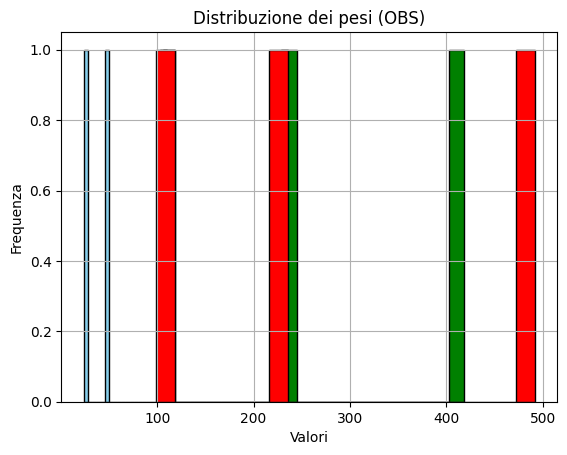

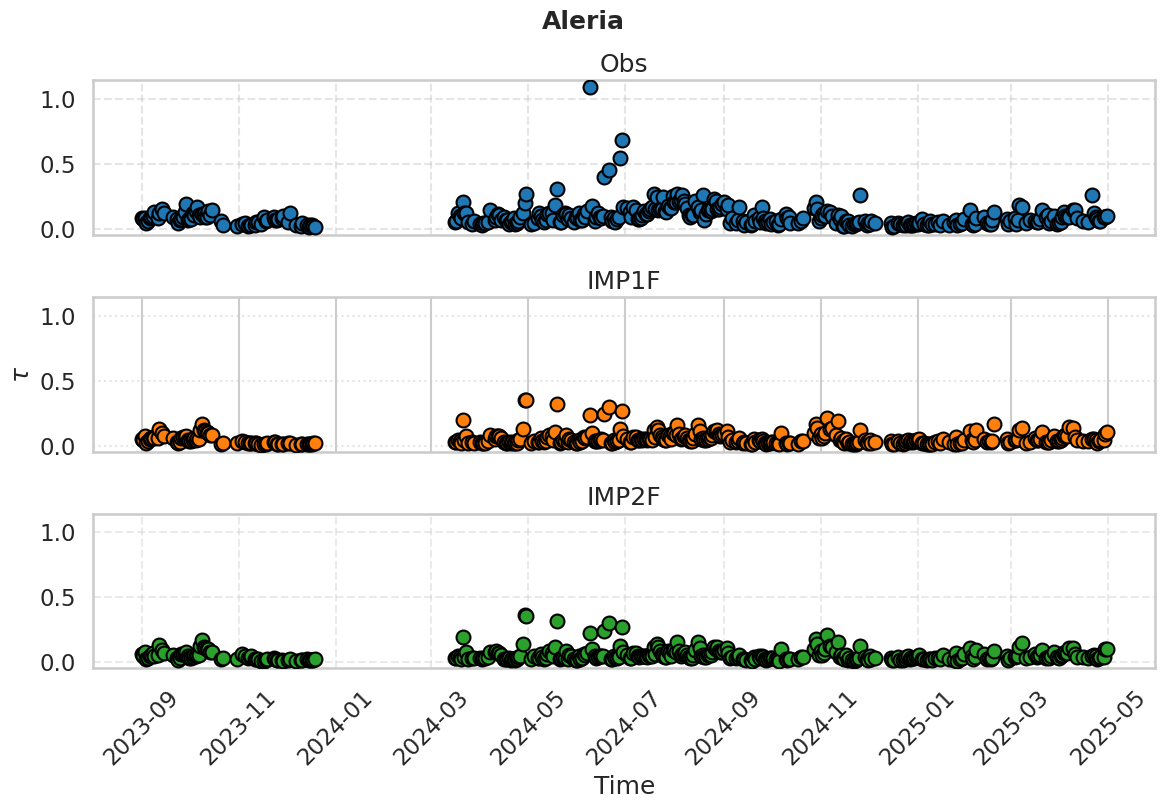

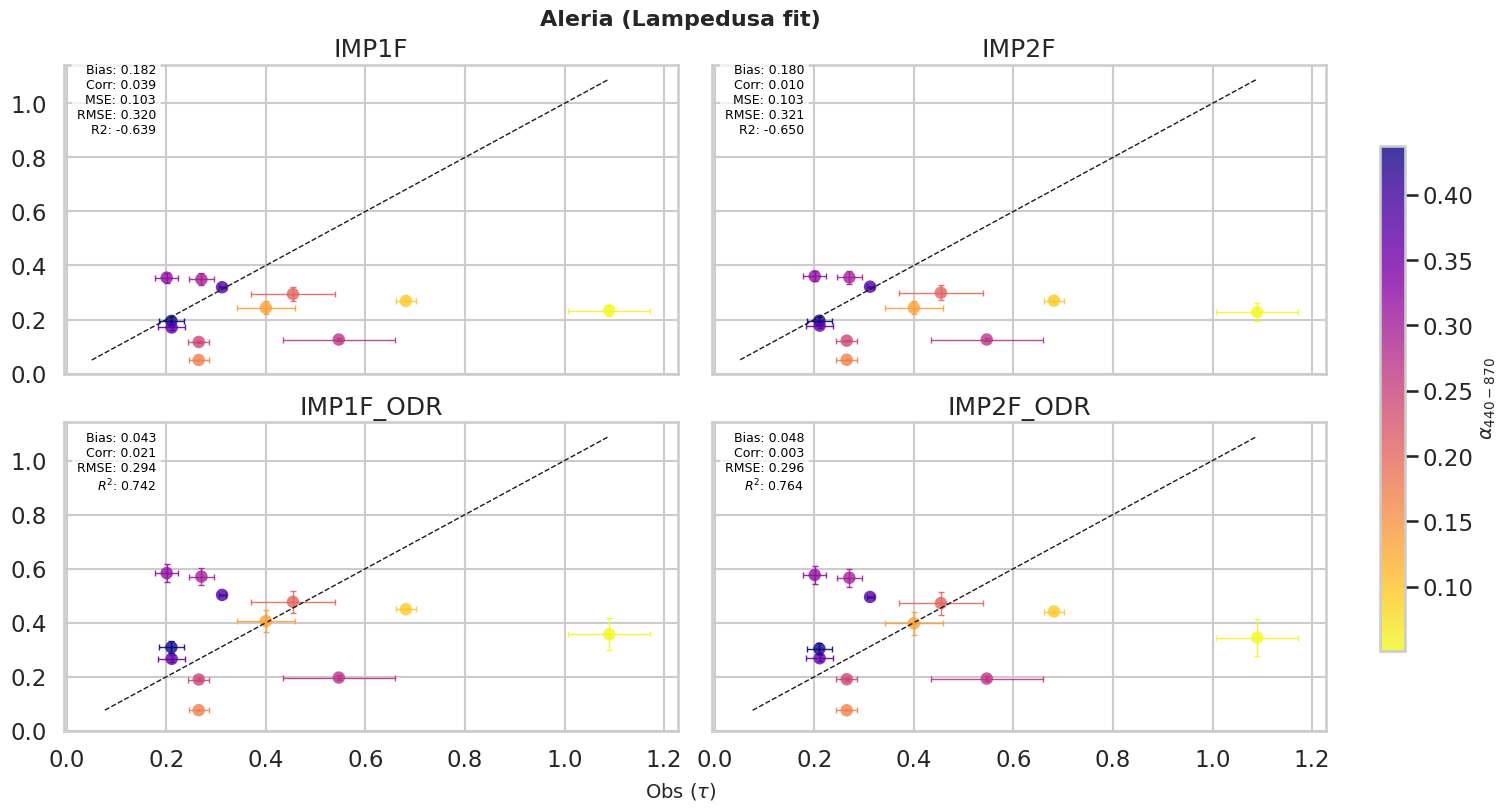

(array([0.92337605]),
 array([0.43829914]),
 array([ 0.10622198, -0.12564569, -0.37852388]),
 <Figure size 1200x800 with 2 Axes>)

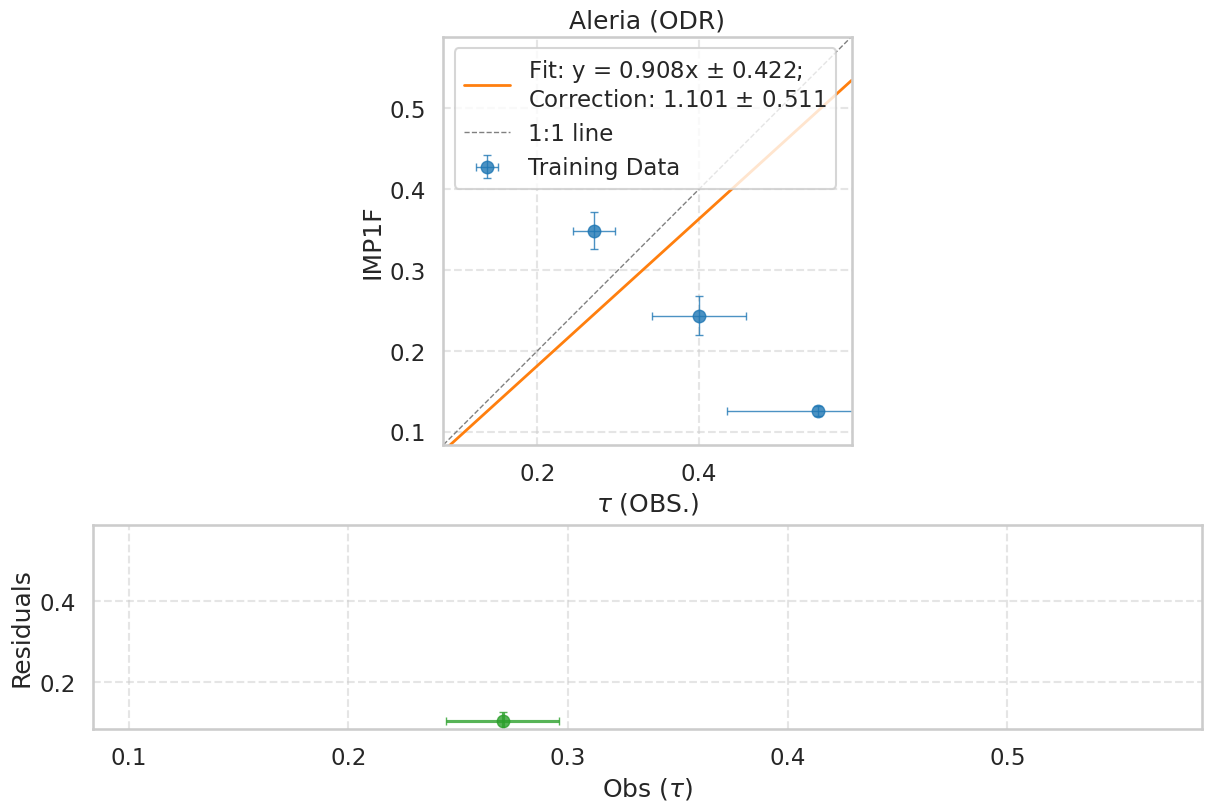

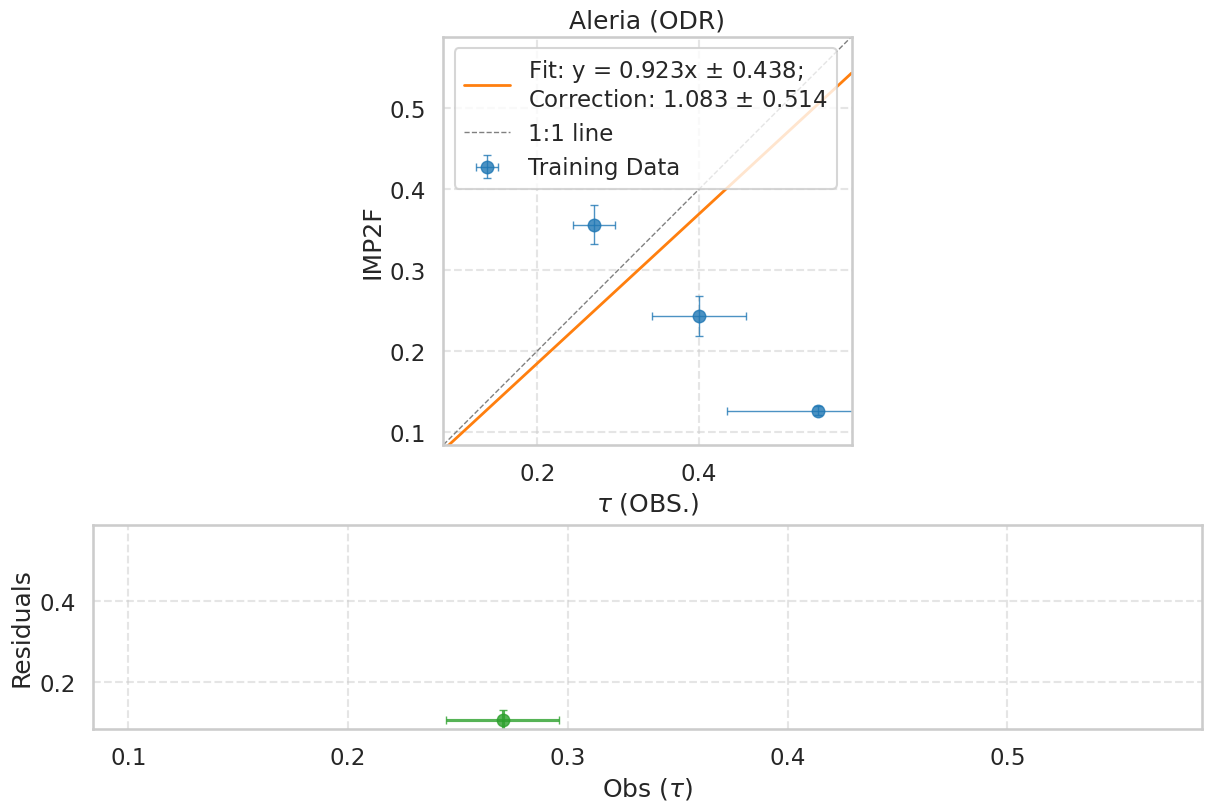

In [2]:
dataframes['aleria_df']['time'] = pd.to_datetime(dataframes['aleria_df']['time'])
dataframes['aleria_DD_filtered']['time'] = pd.to_datetime(dataframes['aleria_DD_filtered']['time'])
t1_aleria = pd.to_datetime(dataframes['aleria_df']['time'].iloc[0])
t2_aleria = pd.to_datetime(pd.Timestamp("2024-08-31"))
t3_aleria = pd.to_datetime(dataframes['aleria_df']['time'].iloc[-1])

# DD events
aleria_dd = dataframes['aleria_df'][(dataframes['aleria_df']['LMP'] >= 0.15) & (dataframes['aleria_df']['ang_440_870'] <= 0.5)]

import numpy as np

k = 2

mean_obs = np.mean(dataframes['aleria_DD_filtered']['LMP'])
std_obs = np.std(dataframes['aleria_DD_filtered']['LMP'])

mean_obs_1 = np.mean(dataframes['aleria_DD_filtered']['IMP1F'])
std_obs_1 = np.std(dataframes['aleria_DD_filtered']['IMP1F'])

mean_obs_2 = np.mean(dataframes['aleria_DD_filtered']['IMP2F'])
std_obs_2 = np.std(dataframes['aleria_DD_filtered']['IMP2F'])

al_dd_trial_f = dataframes['aleria_DD_filtered'][(dataframes['aleria_DD_filtered']['time'] >= t1_aleria) & (dataframes['aleria_DD_filtered']['time'] <= t2_aleria)]
al_dd_test_f = dataframes['aleria_DD_filtered'][(dataframes['aleria_DD_filtered']['time'] >= t2_aleria) & (dataframes['aleria_DD_filtered']['time'] <= t3_aleria)]

al_trial_prova = al_dd_trial_f[(al_dd_trial_f['LMP'] >= 0.35) & (al_dd_trial_f['ang_440_870'] <= 0.25) & (np.abs(al_dd_trial_f['IMP1F']-mean_obs_1) <= k * std_obs_1) & (np.abs(al_dd_trial_f['IMP2F']-mean_obs_2) <= k * std_obs_2) & (np.abs(al_dd_trial_f['LMP']-mean_obs) <= k * std_obs)]

al_dd_trial = aleria_dd[(aleria_dd['time'] >= t1_aleria) & (aleria_dd['time'] <= t2_aleria)]
al_dd_test = aleria_dd[(aleria_dd['time'] >= t2_aleria) & (aleria_dd['time'] <= t3_aleria)]

df_pesi = dataframes['aleria_DD_filtered'].copy()
df_pesi['pesi_obs'] = np.power(dataframes['aleria_DD_filtered']['LMP'], 2)/(np.power(dataframes['aleria_DD_filtered']['err_day_new'], 2))
df_pesi['pesi_imp1'] = np.power(dataframes['aleria_DD_filtered']['IMP1F'], 2)/(np.power(dataframes['aleria_DD_filtered']['err_IMP1_24'], 2))
df_pesi['pesi_imp2'] = np.power(dataframes['aleria_DD_filtered']['IMP2F'], 2)/(np.power(dataframes['aleria_DD_filtered']['err_IMP2_24'], 2))

mean_pesi_obs = np.mean(df_pesi['pesi_obs'])
std_pesi_obs = np.std(df_pesi['pesi_obs'])

mean_pesi_imp1 = np.mean(df_pesi['pesi_imp1']) 
std_pesi_imp1 = np.std(df_pesi['pesi_imp1'])

mean_pesi_imp2 = np.mean(df_pesi['pesi_imp2']) 
std_pesi_imp2 = np.std(df_pesi['pesi_imp2'])

prova = df_pesi[(np.abs(df_pesi['pesi_obs'] - mean_pesi_obs) <= 2 * std_pesi_obs) & (np.abs(df_pesi['pesi_imp1'] - mean_pesi_imp1) <= 2 * std_pesi_imp1) & (np.abs(df_pesi['pesi_imp2'] - mean_pesi_imp2) <= 2 * std_pesi_imp2)]

plt.hist(df_pesi["pesi_obs"], bins=20, color='skyblue', edgecolor='black')
plt.hist(df_pesi['pesi_imp1'], bins=20, color='green', edgecolor='black')
plt.hist(df_pesi['pesi_imp2'], bins=20, color='red', edgecolor='black')
plt.xlabel("Valori")
plt.ylabel("Frequenza")
plt.title("Distribuzione dei pesi (OBS)")
plt.grid(True)
plt.show()

# Set seaborn style
sns.set(style="whitegrid", context="talk")

# Set up subplots
fig, axs = plt.subplots(3, 1, figsize=(12, 8), sharex=True, sharey=True)
df = dataframes['aleria_df']

# Fancy line plot with smoothing (rolling mean)
axs[0].scatter(df['time'], df['LMP'], label='obs', color='#1f77b4', edgecolor='black', s=100, zorder=3)
# axs[0].set_ylabel(r'${\tau}$')
axs[0].set_title('Obs')
#axs[0].legend(loc='upper left')
axs[0].grid(True, linestyle='--', alpha=0.5)

# Fancy bar plot
axs[1].scatter(df['time'], df['IMP1F'], color='#ff7f0e', edgecolor='black', zorder=3, s=100)
axs[1].set_ylabel(r'${\tau}$')
axs[1].set_title('IMP1F')
axs[1].grid(True, axis='y', linestyle=':', alpha=0.5)

# Fancy scatter plot with annotations
axs[2].scatter(df['time'], df['IMP2F'], s=100, color='#2ca02c', edgecolor='black', zorder=3)
# axs[2].set_ylabel('obs3')
axs[2].set_title('IMP2F')

axs[2].set_xlabel('Time')
axs[2].grid(True, linestyle='--', alpha=0.4)

# Beautify x-axis
plt.xticks(rotation=45)
plt.tight_layout()
plt.suptitle("Aleria", fontsize=18, y=1.02, fontweight='bold')
plt.subplots_adjust(hspace=0.4)

plt.savefig("/home/andrea/enea/lmp_dust_enea/figure/aleria/al_time.png", format='png', dpi=300, bbox_inches='tight')
plt.show()

plot_scatter(
    aleria_dd,
    ['LMP', 'IMP1F', 'IMP2F', 'IMP1F_ODR', 'IMP2F_ODR', 'ang_440_870', 'err_day_new', 'err_IMP1_24', 'err_IMP2_24', 'err_IMP1_24_ODR', 'err_IMP2_24_ODR'],
    cmap='plasma_r',
    stats=True,
    name="Aleria (Lampedusa fit)", save=True, path="/home/andrea/enea/lmp_dust_enea/figure/aleria/al_DD_al_fit.png")

# fit on the first period to obtain the coefficient related to the station

odr_linear_fit_plot(al_dd_trial_f, "LMP", "IMP1F", "err_day_new", "err_IMP1_24", "Aleria (ODR)", save=True, path="/home/andrea/enea/lmp_dust_enea/figure/aleria/al_DD_no_filt_trial_IMP1.png")
odr_linear_fit_plot(al_dd_trial_f, "LMP", "IMP2F", "err_day_new", "err_IMP2_24", "Aleria (ODR)", save=True, path="/home/andrea/enea/lmp_dust_enea/figure/aleria/al_DD_no_filt_trial_IMP2.png")

# **Aosta**

In [3]:
aosta_df['time'] = pd.to_datetime(aosta_df['time'])
t1_aosta = pd.to_datetime(aosta_df['time'].iloc[0])
t2_aosta = pd.to_datetime(pd.Timestamp("2024-08-31"))
t3_aosta = pd.to_datetime(aosta_df['time'].iloc[-1])

# DD events
aosta_dd = aosta_df[(aosta_df['LMP'] >= 0.15) & (aosta_df['ang_440_870'] <= 0.5)]
as_dd_trial = aosta_dd[(aosta_dd['time'] >= t1_aosta) & (aosta_dd['time'] <= t2_aosta)]
as_dd_test = aosta_dd[(aosta_dd['time'] >= t2_aosta) & (aosta_dd['time'] <= t3_aosta)]

# filtering daylight hours
city = LocationInfo("Aosta", "Italy", "Europe/Rome", 45.7, 7.4)  # Use your location
tz = pytz.timezone(city.timezone)
as_dd_trial = as_dd_trial.copy()
as_dd_trial['time'] = pd.to_datetime(as_dd_trial['time'])
# Apply to DataFrame
as_dd_trial['max_daylight_hours'] = as_dd_trial.apply(lambda row: compute_max_daylight(city, row, tz), axis=1)
as_dd_trial_filtered = as_dd_trial[as_dd_trial['n'] >= 0.5 * as_dd_trial['max_daylight_hours']]


# Set seaborn style
sns.set(style="whitegrid", context="talk")

df = aosta_df
# Set up subplots
fig, axs = plt.subplots(3, 1, figsize=(12, 8), sharex=True, sharey=True)

# Fancy line plot with smoothing (rolling mean)
axs[0].scatter(df['time'], df['LMP'], label='obs', color='#1f77b4', edgecolor='black', s=100, zorder=3)
# axs[0].set_ylabel(r'${\tau}$')
axs[0].set_title('Obs')
#axs[0].legend(loc='upper left')
axs[0].grid(True, linestyle='--', alpha=0.5)

# Fancy bar plot
axs[1].scatter(df['time'], df['IMP1F'], color='#ff7f0e', edgecolor='black', zorder=3, s=100)
axs[1].set_ylabel(r'${\tau}$')
axs[1].set_title('IMP1F')
axs[1].grid(True, axis='y', linestyle=':', alpha=0.5)

# Fancy scatter plot with annotations
axs[2].scatter(df['time'], df['IMP2F'], s=100, color='#2ca02c', edgecolor='black', zorder=3)
# axs[2].set_ylabel('obs3')
axs[2].set_title('IMP2F')

axs[2].set_xlabel('Time')
axs[2].grid(True, linestyle='--', alpha=0.4)

# Beautify x-axis
plt.xticks(rotation=45)
plt.tight_layout()
plt.suptitle("Aosta", fontsize=18, y=1.02, fontweight='bold')
plt.subplots_adjust(hspace=0.4)

plt.show()

plot_scatter(
    aosta_dd,
    ['LMP', 'IMP1F', 'IMP2F', 'IMP1F_ODR', 'IMP2F_ODR', 'ang_440_870'],
    cmap='plasma_r',
    stats=True,
    name="Aosta")

odr_linear_fit_plot(as_dd_trial_filtered, "LMP", "IMP1F", "err_day_new", "err_IMP1_24", "Aosta (ODR)")
odr_linear_fit_plot(as_dd_trial_filtered, "LMP", "IMP2F", "err_day_new", "err_IMP2_24", "Aosta (ODR)")

NameError: name 'aosta_df' is not defined

# **Apulian Tavoliere**

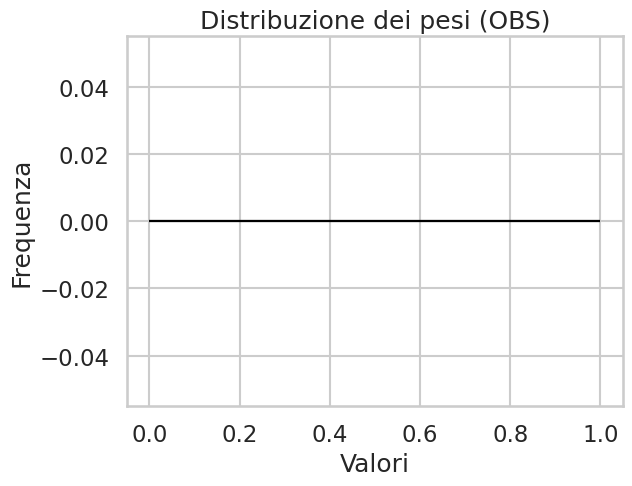

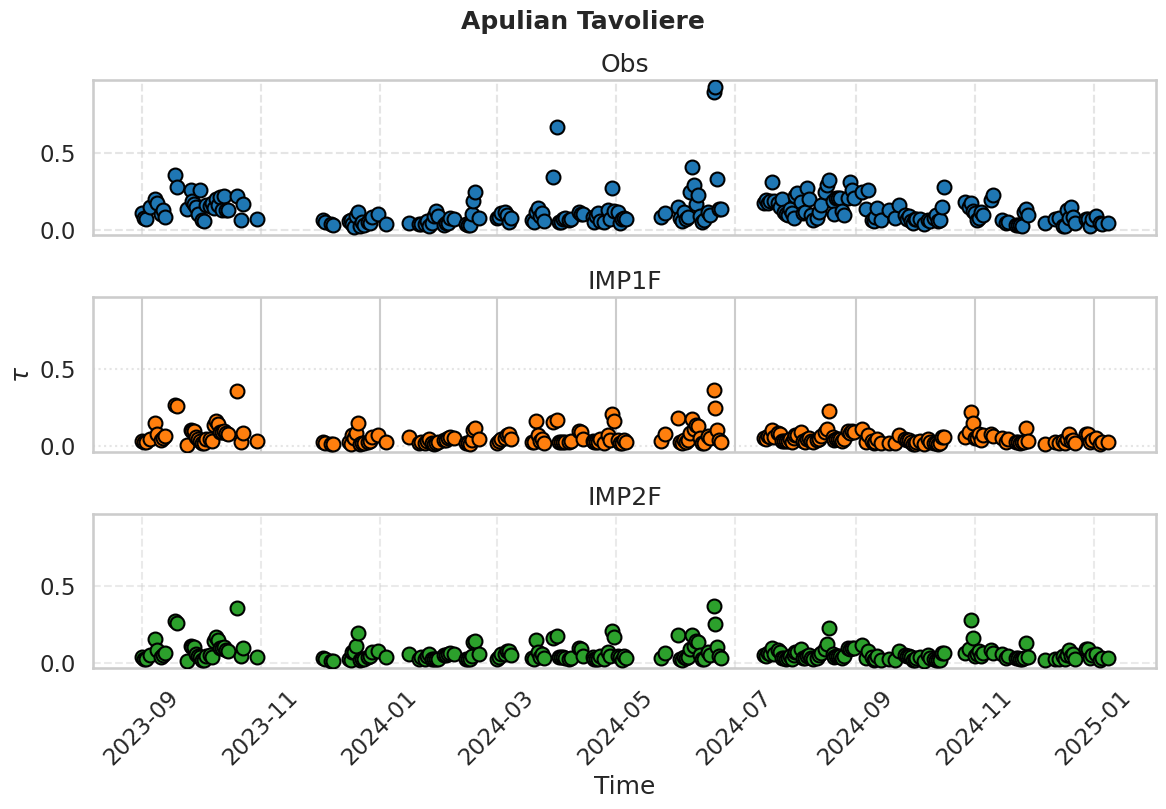

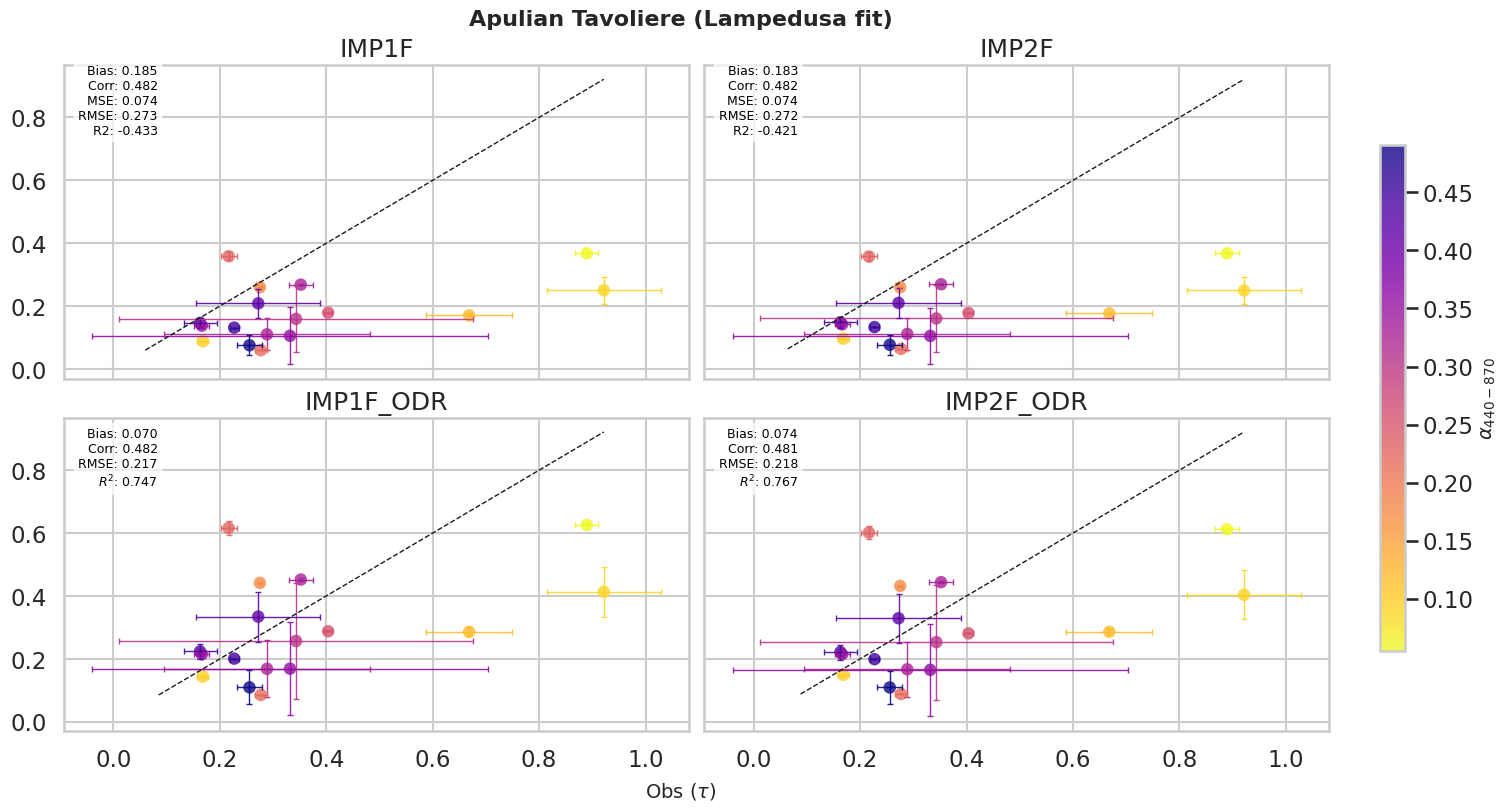

(array([0.74749125]),
 array([0.13825306]),
 array([ 0.0063023 ,  0.02672868,  0.19588366, -0.02903559, -0.09560108,
        -0.32263666,  0.00685182, -0.10405135,  0.01774311, -0.43879272,
        -0.14279381, -0.11403146]),
 <Figure size 1200x800 with 2 Axes>)

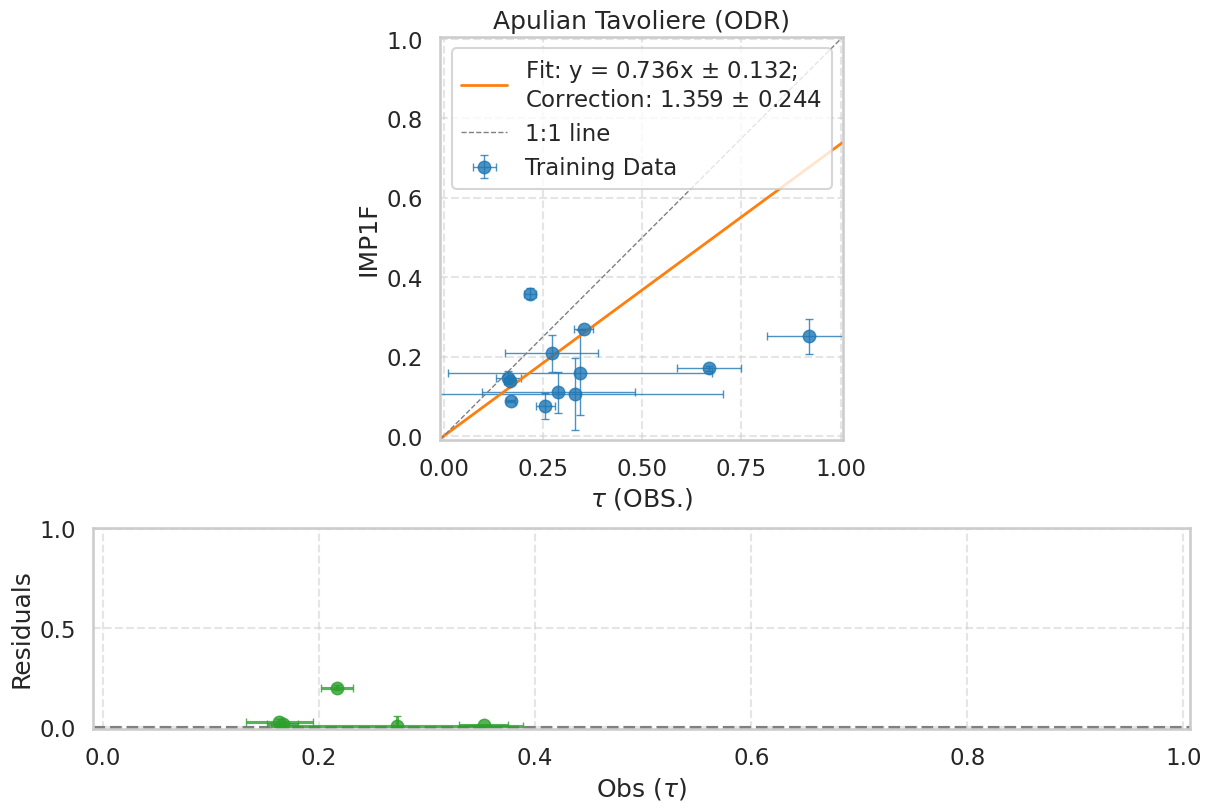

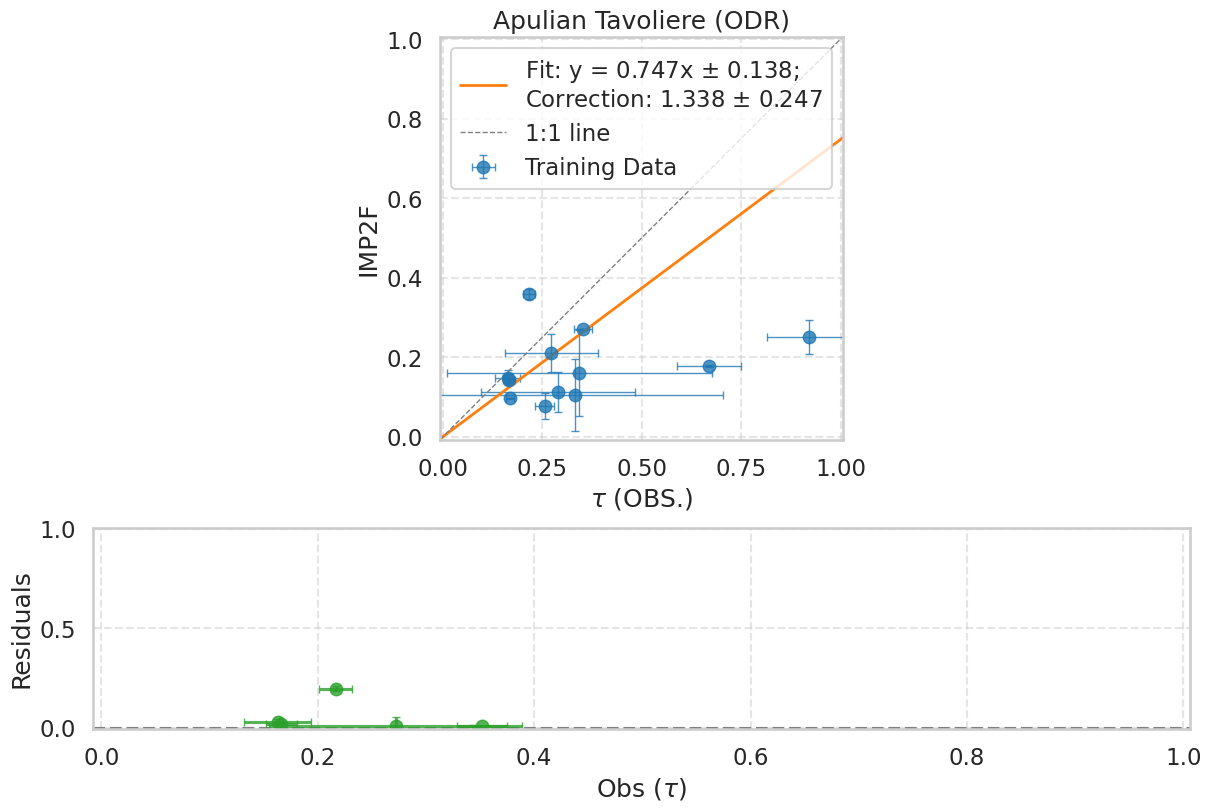

In [4]:
dataframes['apulian_tavoliere_df']['time'] = pd.to_datetime(dataframes['apulian_tavoliere_df']['time'])
dataframes['apulian_tavoliere_DD_filtered']['time'] = pd.to_datetime(dataframes['apulian_tavoliere_DD_filtered']['time'])
t1_apulian_tavoliere = pd.to_datetime(dataframes['apulian_tavoliere_df']['time'].iloc[0])
t2_apulian_tavoliere = pd.to_datetime(pd.Timestamp("2024-08-31"))
t3_apulian_tavoliere = pd.to_datetime(dataframes['apulian_tavoliere_df']['time'].iloc[-1])

# DD events
import numpy as np

apulian_tavoliere_dd = dataframes['apulian_tavoliere_df'][(dataframes['apulian_tavoliere_df']['LMP'] >= 0.15) & (dataframes['apulian_tavoliere_df']['ang_440_870'] <= 0.5)]
mean_obs = np.mean(dataframes['apulian_tavoliere_DD_filtered']['LMP'])
std_obs = np.std(dataframes['apulian_tavoliere_DD_filtered']['LMP'])

k = 2

mean_obs = np.mean(dataframes['apulian_tavoliere_DD_filtered']['LMP'])
std_obs = np.std(dataframes['apulian_tavoliere_DD_filtered']['LMP'])

mean_obs_1 = np.mean(dataframes['apulian_tavoliere_DD_filtered']['IMP1F'])
std_obs_1 = np.std(dataframes['apulian_tavoliere_DD_filtered']['IMP1F'])

mean_obs_2 = np.mean(dataframes['apulian_tavoliere_DD_filtered']['IMP2F'])
std_obs_2 = np.std(dataframes['apulian_tavoliere_DD_filtered']['IMP2F'])

at_dd_trial_f = dataframes["apulian_tavoliere_DD_filtered"][(dataframes["apulian_tavoliere_DD_filtered"]['time'] >= t1_apulian_tavoliere) & (dataframes["apulian_tavoliere_DD_filtered"]['time'] <= t2_apulian_tavoliere)]
at_trial_prova = at_dd_trial_f[(at_dd_trial_f['LMP'] >= 0.35) & (at_dd_trial_f['ang_440_870'] <= 0.3) & (np.abs(at_dd_trial_f['IMP1F']-mean_obs_1) <= k * std_obs_1) &
                               (np.abs(at_dd_trial_f['IMP2F']-mean_obs_2) <= k * std_obs_2) & (np.abs(at_dd_trial_f['LMP']-mean_obs) <= k * std_obs)]

at_dd_trial = apulian_tavoliere_dd[(apulian_tavoliere_dd['time'] >= t1_apulian_tavoliere) & (apulian_tavoliere_dd['time'] <= t2_apulian_tavoliere)]
at_dd_test = apulian_tavoliere_dd[(apulian_tavoliere_dd['time'] >= t2_apulian_tavoliere) & (apulian_tavoliere_dd['time'] <= t3_apulian_tavoliere)]

at_dd_trial_f = dataframes['apulian_tavoliere_DD_filtered'][(dataframes['apulian_tavoliere_DD_filtered']['time'] >= t1_apulian_tavoliere) & (dataframes['apulian_tavoliere_DD_filtered']['time'] <= t2_apulian_tavoliere)]
at_dd_test_f = dataframes['apulian_tavoliere_DD_filtered'][(dataframes['apulian_tavoliere_DD_filtered']['time'] >= t2_apulian_tavoliere) & (dataframes['apulian_tavoliere_DD_filtered']['time'] <= t3_apulian_tavoliere)]

# # filtering daylight hours
# city = LocationInfo("Apulian Tavoliere", "Italy", "Europe/Rome", 41.5, 15.5)  # Use your location
# tz = pytz.timezone(city.timezone)
# at_dd_trial = at_dd_trial.copy()
# at_dd_trial['time'] = pd.to_datetime(at_dd_trial['time'])
# # Apply to DataFrame
# at_dd_trial['max_daylight_hours'] = at_dd_trial.apply(lambda row: compute_max_daylight(city, row), axis=1)
# at_dd_trial_filtered = at_dd_trial[at_dd_trial['n'] >= 0.5 * at_dd_trial['max_daylight_hours']]

df_pesi = dataframes['apulian_tavoliere_DD_filtered'].copy()
df_pesi['pesi_obs'] = np.power(dataframes['apulian_tavoliere_DD_filtered']['LMP'], 2)/(np.power(dataframes['apulian_tavoliere_DD_filtered']['err_day_new'], 2))
df_pesi['pesi_imp1'] = np.power(dataframes['apulian_tavoliere_DD_filtered']['IMP1F'], 2)/(np.power(dataframes['apulian_tavoliere_DD_filtered']['err_IMP1_24'], 2))
df_pesi['pesi_imp2'] = np.power(dataframes['apulian_tavoliere_DD_filtered']['IMP2F'], 2)/(np.power(dataframes['apulian_tavoliere_DD_filtered']['err_IMP2_24'], 2))

mean_pesi_obs = np.mean(df_pesi['pesi_obs'])
std_pesi_obs = np.std(df_pesi['pesi_obs'])

mean_pesi_imp1 = np.mean(df_pesi['pesi_imp1']) 
std_pesi_imp1 = np.std(df_pesi['pesi_imp1'])

mean_pesi_imp2 = np.mean(df_pesi['pesi_imp2']) 
std_pesi_imp2 = np.std(df_pesi['pesi_imp2'])

prova = df_pesi[(np.abs(df_pesi['pesi_obs'] - mean_pesi_obs) <= 2 * std_pesi_obs) & (np.abs(df_pesi['pesi_imp1'] - mean_pesi_imp1) <= 2 * std_pesi_imp1) & (np.abs(df_pesi['pesi_imp2'] - mean_pesi_imp2) <= 2 * std_pesi_imp2)]

plt.hist(df_pesi["pesi_obs"], bins=20, color='skyblue', edgecolor='black')
plt.hist(df_pesi['pesi_imp1'], bins=20, color='green', edgecolor='black')
plt.hist(df_pesi['pesi_imp2'], bins=20, color='red', edgecolor='black')
plt.xlabel("Valori")
plt.ylabel("Frequenza")
plt.title("Distribuzione dei pesi (OBS)")
plt.grid(True)
plt.show()

# Set seaborn style
sns.set(style="whitegrid", context="talk")

# Set up subplots
fig, axs = plt.subplots(3, 1, figsize=(12, 8), sharex=True, sharey=True)
df = dataframes['apulian_tavoliere_df']

# Fancy line plot with smoothing (rolling mean)
axs[0].scatter(df['time'], df['LMP'], label='obs', color='#1f77b4', edgecolor='black', s=100, zorder=3)
# axs[0].set_ylabel(r'${\tau}$')
axs[0].set_title('Obs')
#axs[0].legend(loc='upper left')
axs[0].grid(True, linestyle='--', alpha=0.5)

# Fancy bar plot
axs[1].scatter(df['time'], df['IMP1F'], color='#ff7f0e', edgecolor='black', zorder=3, s=100)
axs[1].set_ylabel(r'${\tau}$')
axs[1].set_title('IMP1F')
axs[1].grid(True, axis='y', linestyle=':', alpha=0.5)

# Fancy scatter plot with annotations
axs[2].scatter(df['time'], df['IMP2F'], s=100, color='#2ca02c', edgecolor='black', zorder=3)
# axs[2].set_ylabel('obs3')
axs[2].set_title('IMP2F')

axs[2].set_xlabel('Time')
axs[2].grid(True, linestyle='--', alpha=0.4)

# Beautify x-axis
plt.xticks(rotation=45)
plt.tight_layout()
plt.suptitle("Apulian Tavoliere", fontsize=18, y=1.02, fontweight='bold')
plt.subplots_adjust(hspace=0.4)

plt.savefig("/home/andrea/enea/lmp_dust_enea/figure/apulian/at_time.png", format='png', dpi=300, bbox_inches='tight')
plt.show()

plot_scatter(
    apulian_tavoliere_dd,
    ['LMP', 'IMP1F', 'IMP2F', 'IMP1F_ODR', 'IMP2F_ODR', 'ang_440_870', 'err_day_new', 'err_IMP1_24', 'err_IMP2_24', 'err_IMP1_24_ODR', 'err_IMP2_24_ODR'],
    cmap='plasma_r',
    stats=True,
    name="Apulian Tavoliere (Lampedusa fit)", 
    save=True, path="/home/andrea/enea/lmp_dust_enea/figure/lampedusa/at_DD_lm_fit.png")

#apulian_tavoliere_dd_err_fil = apulian_tavoliere_dd_err_fil.drop(135, inplace=True)
odr_linear_fit_plot(dataframes['apulian_tavoliere_DD'], "LMP", "IMP1F", "err_day_new", "err_IMP1_24", "Apulian Tavoliere (ODR)", save=True, path="/home/andrea/enea/lmp_dust_enea/figure/apulian/at_DD_no_filt_fit_IMP1.png")
odr_linear_fit_plot(dataframes['apulian_tavoliere_DD'], "LMP", "IMP2F", "err_day_new", "err_IMP2_24", "Apulian Tavoliere (ODR)", save=True, path="/home/andrea/enea/lmp_dust_enea/figure/apulian/at_DD_no_filt_fit_IMP2.png")

# **Capo Granitola**

FileNotFoundError: [Errno 2] No such file or directory: '/home/andrea/enea_project/lmp_dust_enea/figure/capo/at_time.png'

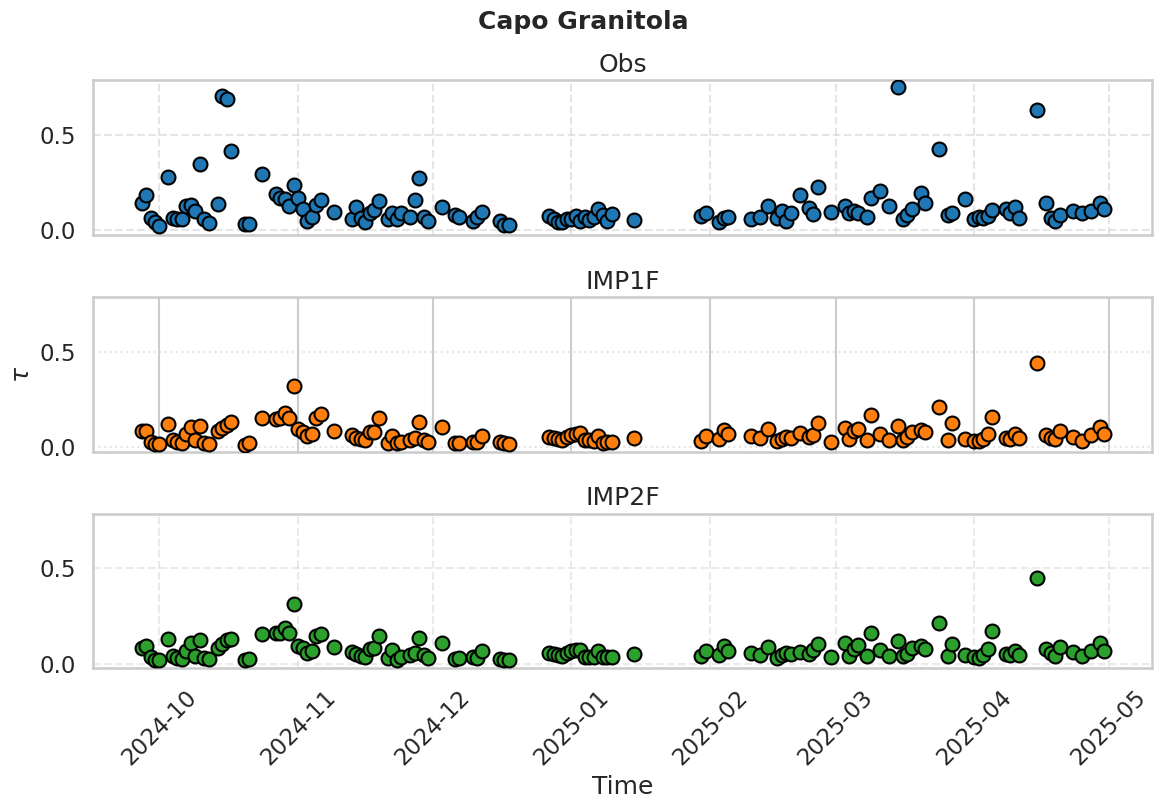

In [5]:
dataframes['capo_granitola_df']['time'] = pd.to_datetime(dataframes['capo_granitola_df']['time'])
t1_capo_granitola = pd.to_datetime(dataframes['capo_granitola_df']['time'].iloc[0])
t2_capo_granitola = pd.to_datetime(pd.Timestamp("2024-08-31"))
t3_capo_granitola = pd.to_datetime(dataframes['capo_granitola_df']['time'].iloc[-1])

# DD events
capo_granitola_dd = dataframes['capo_granitola_df'][(dataframes['capo_granitola_df']['LMP'] >= 0.15) & (dataframes['capo_granitola_df']['ang_440_870'] <= 0.5) & (dataframes['capo_granitola_df']['err_IMP1_24'] != 0) & (dataframes['capo_granitola_df']['err_IMP2_24'] != 0)]
cg_dd_trial = capo_granitola_dd[(capo_granitola_dd['time'] >= t1_capo_granitola) & (capo_granitola_dd['time'] <= t2_capo_granitola)]
cg_dd_test = capo_granitola_dd[(capo_granitola_dd['time'] >= t2_capo_granitola) & (capo_granitola_dd['time'] <= t3_capo_granitola)]

k = 2

mean_obs = np.mean(dataframes['capo_granitola_DD_filtered']['LMP'])
std_obs = np.std(dataframes['capo_granitola_DD_filtered']['LMP'])

mean_obs_1 = np.mean(dataframes['capo_granitola_DD_filtered']['IMP1F'])
std_obs_1 = np.std(dataframes['capo_granitola_DD_filtered']['IMP1F'])

mean_obs_2 = np.mean(dataframes['capo_granitola_DD_filtered']['IMP2F'])
std_obs_2 = np.std(dataframes['capo_granitola_DD_filtered']['IMP2F'])

cp_dd_trial_f = dataframes["capo_granitola_DD_filtered"][(dataframes["capo_granitola_DD_filtered"]['time'] >= t1_capo_granitola) &
                                                         (dataframes["capo_granitola_DD_filtered"]['time'] <= t2_capo_granitola)]
cp_trial_prova = cp_dd_trial_f[(cp_dd_trial_f['LMP'] >= 0.35) & (cp_dd_trial_f['ang_440_870'] <= 0.3) & (np.abs(cp_dd_trial_f['IMP1F']-mean_obs_1) <= k * std_obs_1) &
                               (np.abs(cp_dd_trial_f['IMP2F']-mean_obs_2) <= k * std_obs_2) & (np.abs(cp_dd_trial_f['LMP']-mean_obs) <= k * std_obs)]

# # filtering daylight hours
# city = LocationInfo("Capo Granitola", "Italy", "Europe/Rome", 37.6, 12.7)  # Use your location
# tz = pytz.timezone(city.timezone)
# cg_dd_test = cg_dd_test.copy()
# cg_dd_test['time'] = pd.to_datetime(cg_dd_test['time'])
# # Apply to DataFrame
# cg_dd_test['max_daylight_hours'] = cg_dd_test.apply(lambda row: compute_max_daylight(city, row), axis=1)
# cg_dd_test_filtered = cg_dd_test[cg_dd_test['n'] >= 0.5 * cg_dd_test['max_daylight_hours']]

# df_pesi = dataframes['capo_granitola_DD_filtered'].copy()
# df_pesi['pesi_obs'] = np.power(dataframes['capo_granitola_DD_filtered']['LMP'], 2)/(np.power(dataframes['capo_granitola_DD_filtered']['err_day_new'], 2))
# df_pesi['pesi_imp1'] = np.power(dataframes['capo_granitola_DD_filtered']['IMP1F'], 2)/(np.power(dataframes['capo_granitola_DD_filtered']['err_IMP1_24'], 2))
# df_pesi['pesi_imp2'] = np.power(dataframes['capo_granitola_DD_filtered']['IMP2F'], 2)/(np.power(dataframes['capo_granitola_DD_filtered']['err_IMP2_24'], 2))

# mean_pesi_obs = np.mean(df_pesi['pesi_obs'])
# std_pesi_obs = np.std(df_pesi['pesi_obs'])

# mean_pesi_imp1 = np.mean(df_pesi['pesi_imp1']) 
# std_pesi_imp1 = np.std(df_pesi['pesi_imp1'])

# mean_pesi_imp2 = np.mean(df_pesi['pesi_imp2']) 
# std_pesi_imp2 = np.std(df_pesi['pesi_imp2'])

# prova = df_pesi[(np.abs(df_pesi['pesi_obs'] - mean_pesi_obs) <= 2 * std_pesi_obs) & (np.abs(df_pesi['pesi_imp1'] - mean_pesi_imp1) <= 2 * std_pesi_imp1) & (np.abs(df_pesi['pesi_imp2'] - mean_pesi_imp2) <= 2 * std_pesi_imp2)]

# plt.hist(df_pesi["pesi_obs"], bins=20, color='skyblue', edgecolor='black')
# plt.hist(df_pesi['pesi_imp1'], bins=20, color='green', edgecolor='black')
# plt.hist(df_pesi['pesi_imp2'], bins=20, color='red', edgecolor='black')
# plt.xlabel("Valori")
# plt.ylabel("Frequenza")
# plt.title("Distribuzione dei pesi (OBS)")
# plt.grid(True)
# plt.show()

# Set seaborn style
sns.set(style="whitegrid", context="talk")

# Set up subplots
fig, axs = plt.subplots(3, 1, figsize=(12, 8), sharex=True, sharey=True)
df = dataframes['capo_granitola_df']

# Fancy line plot with smoothing (rolling mean)
axs[0].scatter(df['time'], df['LMP'], label='obs', color='#1f77b4', edgecolor='black', s=100, zorder=3)
# axs[0].set_ylabel(r'${\tau}$')
axs[0].set_title('Obs')
#axs[0].legend(loc='upper left')
axs[0].grid(True, linestyle='--', alpha=0.5)

# Fancy bar plot
axs[1].scatter(df['time'], df['IMP1F'], color='#ff7f0e', edgecolor='black', zorder=3, s=100)
axs[1].set_ylabel(r'${\tau}$')
axs[1].set_title('IMP1F')
axs[1].grid(True, axis='y', linestyle=':', alpha=0.5)

# Fancy scatter plot with annotations
axs[2].scatter(df['time'], df['IMP2F'], s=100, color='#2ca02c', edgecolor='black', zorder=3)
# axs[2].set_ylabel('obs3')
axs[2].set_title('IMP2F')

axs[2].set_xlabel('Time')
axs[2].grid(True, linestyle='--', alpha=0.4)

# Beautify x-axis
plt.xticks(rotation=45)
plt.tight_layout()
plt.suptitle("Capo Granitola", fontsize=18, y=1.02, fontweight='bold')
plt.subplots_adjust(hspace=0.4)

plt.savefig("/home/andrea/enea_project/lmp_dust_enea/figure/capo/at_time.png", format='png', dpi=300, bbox_inches='tight')
plt.show()

plot_scatter(
    dataframes['capo_granitola_DD'],
    ['LMP', 'IMP1F', 'IMP2F', 'IMP1F_ODR', 'IMP2F_ODR', 'ang_440_870', 'err_day_new', 'err_IMP1_24', 'err_IMP2_24', 'err_IMP1_24_ODR', 'err_IMP2_24_ODR'],
    cmap='plasma_r',
    stats=True,
    name="Capo Granitola", 
    save=True, 
    path="/home/andrea/enea_project/lmp_dust_enea/figure/capo/cp_DD_lm_fit.png")


dataframes['capo_granitola_DD'].drop(7, inplace=True)
odr_linear_fit_plot(dataframes['capo_granitola_DD'],
                    "LMP", "IMP1F", "err_day_new", "err_IMP1_24",
                    "Capo Granitola (ODR)", 
                    save=True, 
                    path="/home/andrea/enea_project/lmp_dust_enea/figure/capo/cp_DD_no_fil_fit_IMP1.png")
odr_linear_fit_plot(dataframes['capo_granitola_DD'],
                    "LMP", "IMP2F", "err_day_new", "err_IMP2_24",
                    "Capo Granitola (ODR)", 
                    save=True, 
                    path="/home/andrea/enea_project/lmp_dust_enea/figure/capo/cp_DD_no_fil_fit_IMP2.png")

### Data for trial are not available for Capo Granitola

# **Ersa**

In [ ]:
dataframes['ersa']['time'] = pd.to_datetime(dataframes['ersa']['time'])
dataframes['']['time'] = 
t1_ersa = pd.to_datetime(dataframes['ersa']['time'].iloc[0])
t2_ersa = pd.to_datetime(pd.Timestamp("2024-08-31"))
t3_ersa = pd.to_datetime(dataframes['ersa']['time'].iloc[-1])

# DD events
ersa_dd = dataframes['ersa'][(dataframes['ersa']['LMP'] >= 0.15) & (dataframes['ersa']['ang_440_870'] <= 0.5) & (dataframes['ersa']['err_IMP1_24'] != 0) & (dataframes['ersa']['err_IMP2_24'] != 0)]
er_dd_trial = ersa_dd[(ersa_dd['time'] >= t1_ersa) & (ersa_dd['time'] <= t2_ersa)]
er_dd_test = ersa_dd[(ersa_dd['time'] >= t2_ersa) & (ersa_dd['time'] <= t3_ersa)]

# filtering daylight hours
city = LocationInfo("Ersa", "Italy", "Europe/Rome", 43.0, 9.4)  # Use your location
tz = pytz.timezone(city.timezone)
er_dd_trial = er_dd_trial.copy()
er_dd_trial['time'] = pd.to_datetime(er_dd_trial['time'])
# Apply to DataFrame
# er_dd_trial['max_daylight_hours'] = er_dd_trial.apply(lambda row: compute_max_daylight(city, row), axis=1)
# er_dd_trial_filtered = er_dd_trial[er_dd_trial['n'] >= 0.5 * er_dd_trial['max_daylight_hours']]

# Set seaborn style
sns.set(style="whitegrid", context="talk")

# Set up subplots
fig, axs = plt.subplots(3, 1, figsize=(12, 8), sharex=True, sharey=True)
df = dataframes['ersa']

# Fancy line plot with smoothing (rolling mean)
axs[0].scatter(df['time'], df['LMP'], label='obs', color='#1f77b4', edgecolor='black', s=100, zorder=3)
# axs[0].set_ylabel(r'${\tau}$')
axs[0].set_title('Obs')
#axs[0].legend(loc='upper left')
axs[0].grid(True, linestyle='--', alpha=0.5)

# Fancy bar plot
axs[1].scatter(df['time'], df['IMP1F'], color='#ff7f0e', edgecolor='black', zorder=3, s=100)
axs[1].set_ylabel(r'${\tau}$')
axs[1].set_title('IMP1F')
axs[1].grid(True, axis='y', linestyle=':', alpha=0.5)

# Fancy scatter plot with annotations
axs[2].scatter(df['time'], df['IMP2F'], s=100, color='#2ca02c', edgecolor='black', zorder=3)
# axs[2].set_ylabel('obs3')
axs[2].set_title('IMP2F')

axs[2].set_xlabel('Time')
axs[2].grid(True, linestyle='--', alpha=0.4)

# Beautify x-axis
plt.xticks(rotation=45)
plt.tight_layout()
plt.suptitle("Ersa", fontsize=18, y=1.02, fontweight='bold')
plt.subplots_adjust(hspace=0.4)

plt.show()


plot_scatter(
    ersa_dd,
    ['LMP', 'IMP1F', 'IMP2F', 'IMP1F_ODR', 'IMP2F_ODR', 'ang_440_870'],
    cmap='plasma_r',
    stats=True,
    name="Ersa")

odr_linear_fit_plot(ersa_dd, "LMP", "IMP1F", "err_day_new", "err_IMP1_24", "Ersa (ODR)")
odr_linear_fit_plot(ersa_dd, "LMP", "IMP2F", "err_day_new", "err_IMP2_24", "Ersa (ODR)")

### No data available for Ersa after filtering daylight hours 

# **Lampedusa**

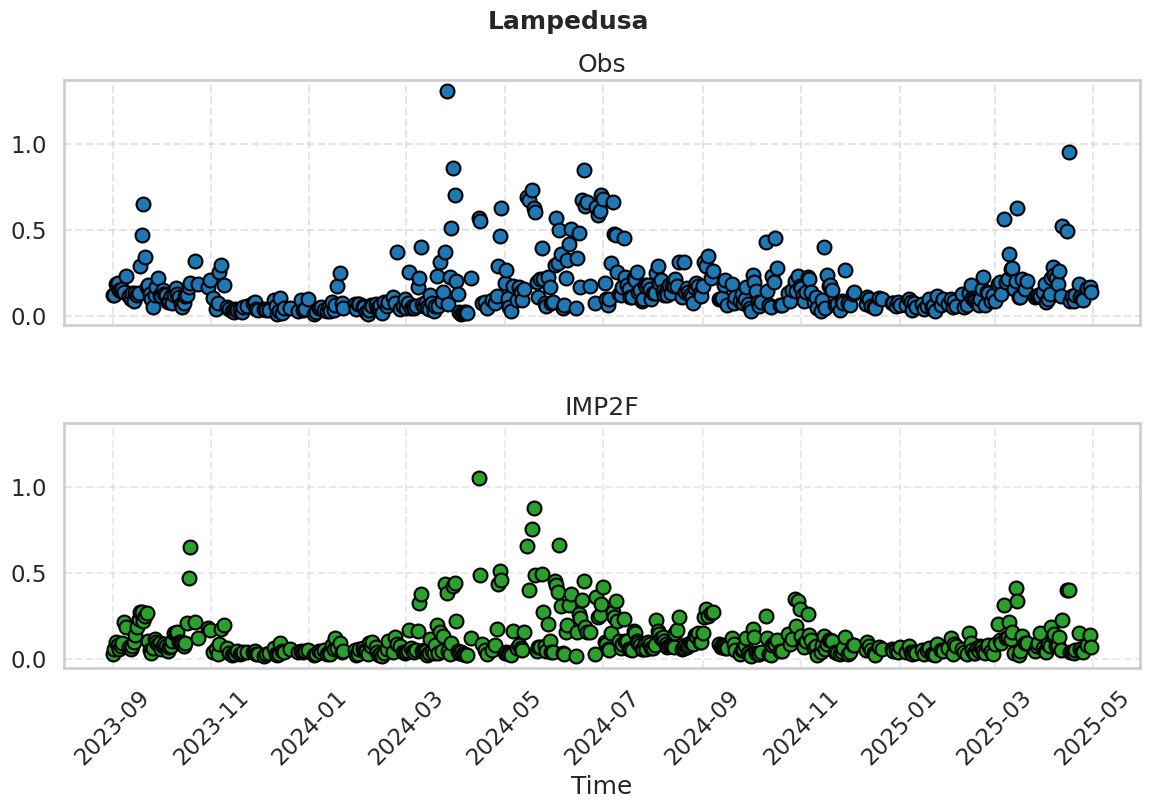

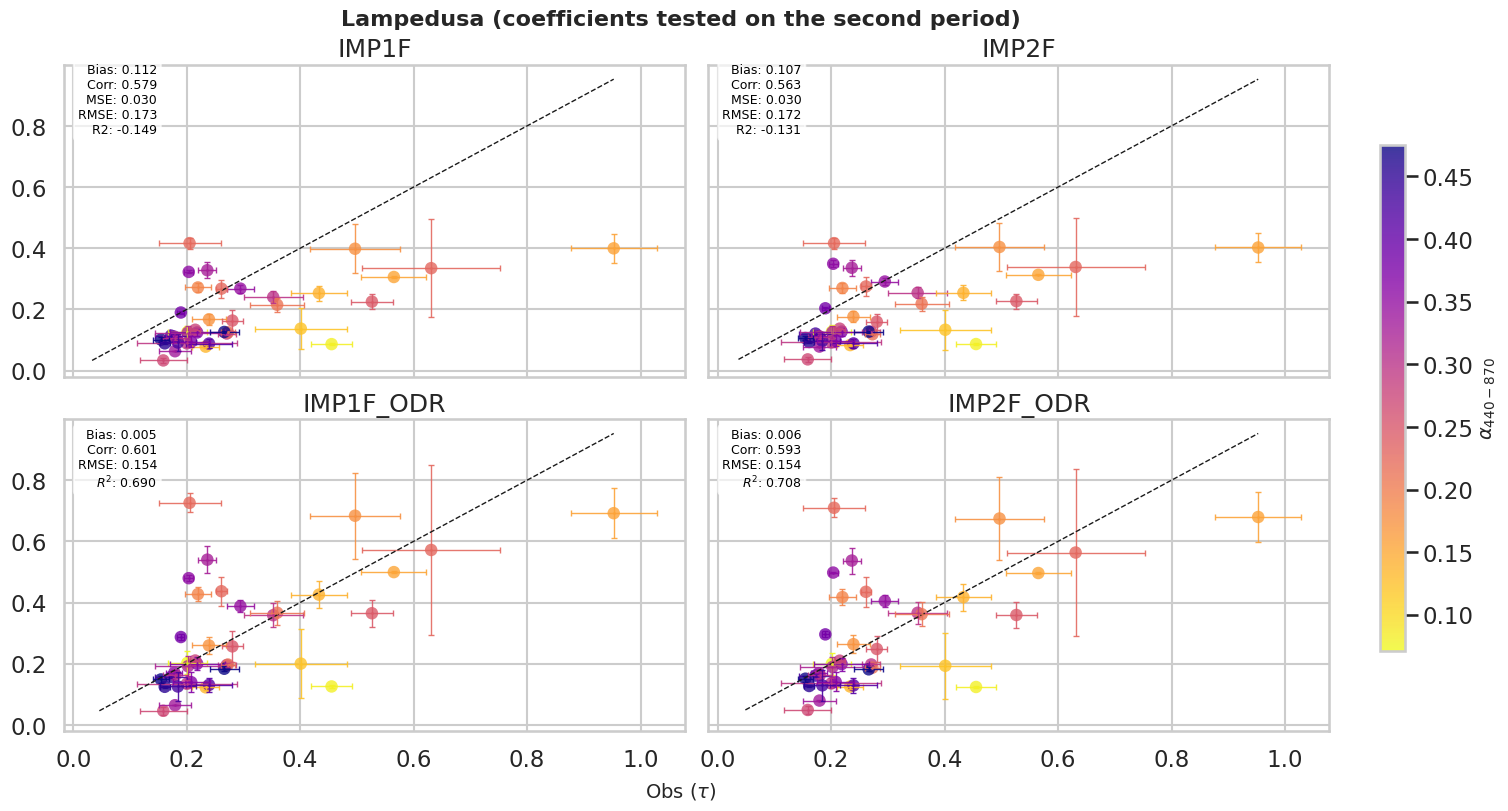

(array([0.57935097]),
 array([0.0455369]),
 array([-0.00027839, -0.20484037,  0.03621735,  0.24421077,  0.09669816,
         0.14106529,  0.09826551,  0.08169941, -0.05030865, -0.18098828,
        -0.00531099, -0.09498519, -0.09598605, -0.08343492,  0.02251906,
        -0.11343025, -0.03237303,  0.06578862, -0.02698737]),
 <Figure size 1200x800 with 2 Axes>)

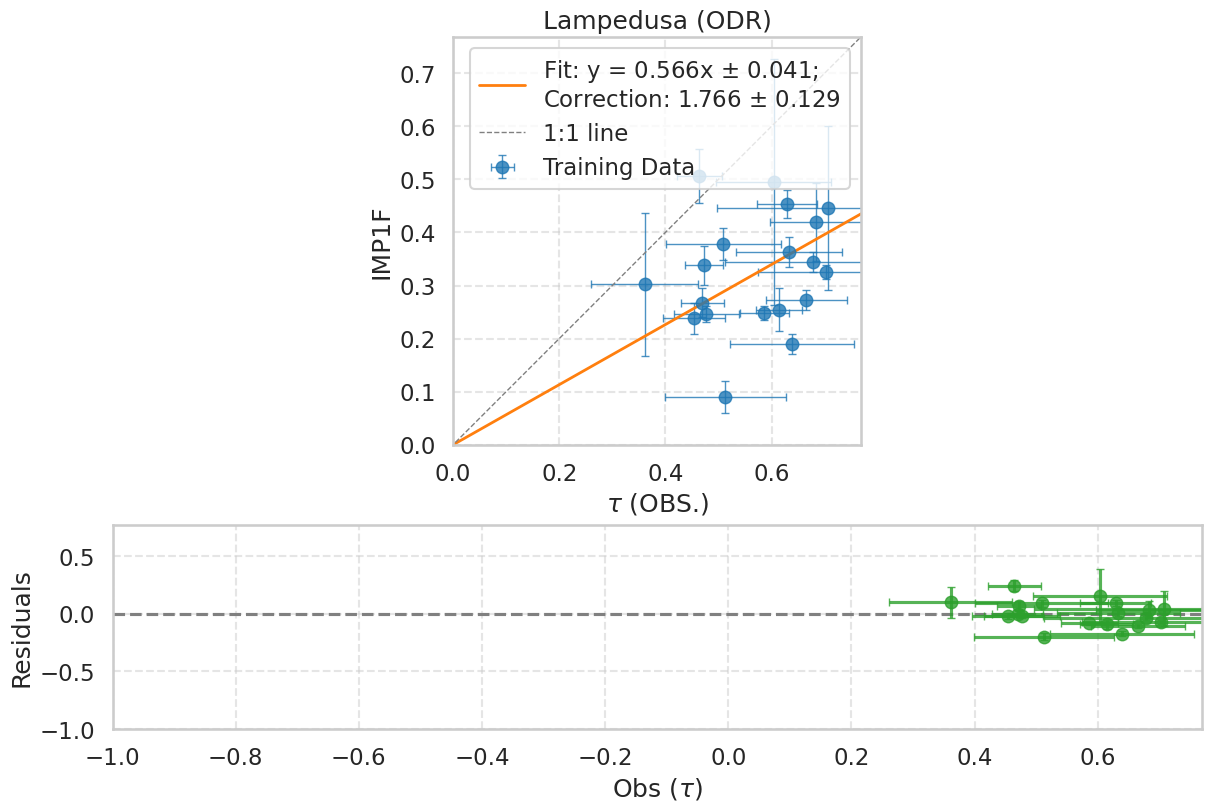

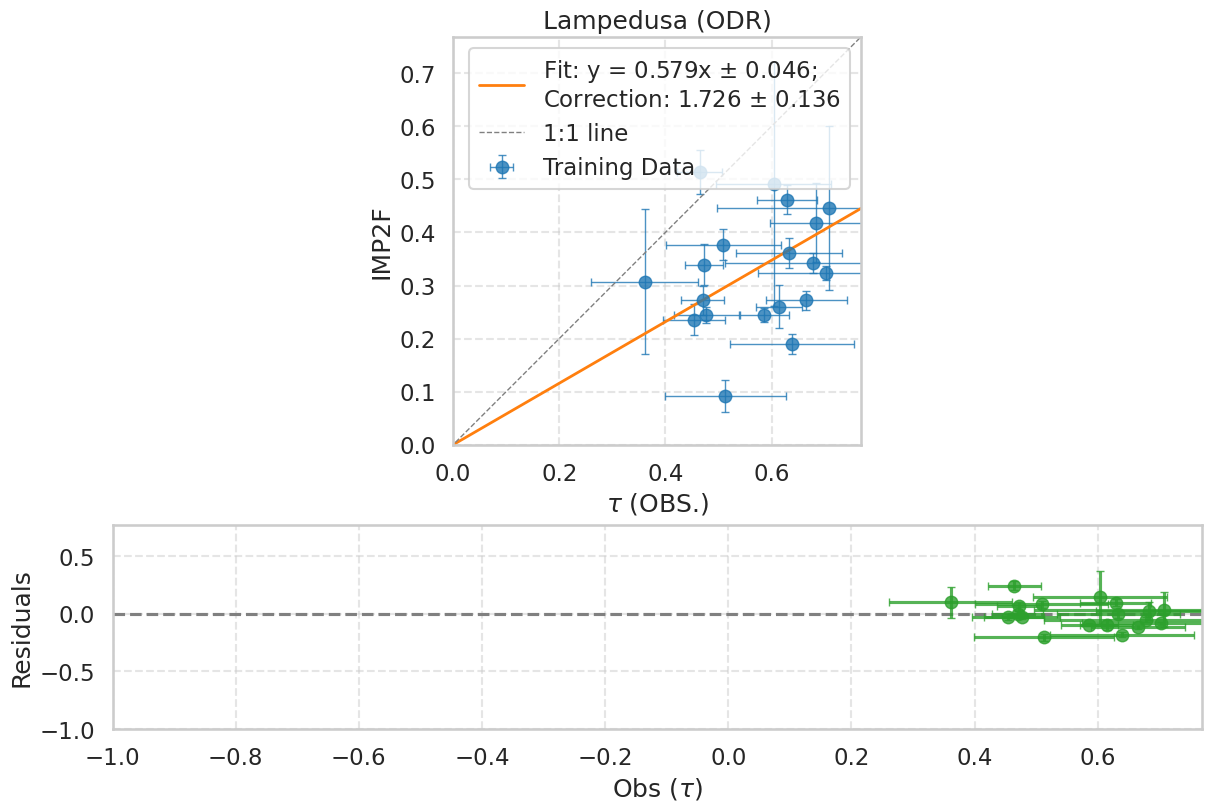

In [4]:
dataframes["lampedusa_df"]['time'] = pd.to_datetime(dataframes["lampedusa_df"]['time'])
dataframes["lampedusa_DD_filtered"]['time'] = pd.to_datetime(dataframes["lampedusa_DD_filtered"]['time'])
t1_lampedusa = pd.to_datetime(dataframes["lampedusa_df"]['time'].iloc[0])
t2_lampedusa = pd.to_datetime(pd.Timestamp("2024-08-31"))
t3_lampedusa = pd.to_datetime(dataframes["lampedusa_df"]['time'].iloc[-1])

# DD events
import numpy as np
lampedusa_dd = dataframes["lampedusa_df"][(dataframes["lampedusa_df"]['LMP'] >= 0.15) & (dataframes["lampedusa_df"]['ang_440_870'] <= 0.5) & (dataframes["lampedusa_df"]['err_IMP1_24'] != 0) & (dataframes["lampedusa_df"]['err_IMP2_24'] != 0) & (dataframes["lampedusa_df"]['err_day_new'] != 0)]
lm_dd_trial = lampedusa_dd[(lampedusa_dd['time'] >= t1_lampedusa) & (lampedusa_dd['time'] <= t2_lampedusa)]
lm_dd_test = lampedusa_dd[(lampedusa_dd['time'] >= t2_lampedusa) & (lampedusa_dd['time'] <= t3_lampedusa)]

k = 2

mean_obs = np.mean(dataframes['lampedusa_DD_filtered']['LMP'])
std_obs = np.std(dataframes['lampedusa_DD_filtered']['LMP'])

mean_obs_1 = np.mean(dataframes['lampedusa_DD_filtered']['IMP1F'])
std_obs_1 = np.std(dataframes['lampedusa_DD_filtered']['IMP1F'])

mean_obs_2 = np.mean(dataframes['lampedusa_DD_filtered']['IMP2F'])
std_obs_2 = np.std(dataframes['lampedusa_DD_filtered']['IMP2F'])

lm_dd_trial_f = dataframes["lampedusa_DD_filtered"][(dataframes["lampedusa_DD_filtered"]['time'] >= t1_lampedusa) & (dataframes["lampedusa_DD_filtered"]['time'] <= t2_lampedusa)]
lm_trial_prova = lm_dd_trial_f[(lm_dd_trial_f['LMP'] >= 0.35) & (lm_dd_trial_f['ang_440_870'] <= 0.25) & (np.abs(lm_dd_trial_f['IMP1F']-mean_obs_1) <= k * std_obs_1) &
                               (np.abs(lm_dd_trial_f['IMP2F']-mean_obs_2) <= k * std_obs_2) & (np.abs(lm_dd_trial_f['LMP']-mean_obs) <= k * std_obs)]

# df_pesi = dataframes['lampedusa_DD_filtered'].copy()
# df_pesi['pesi_obs'] = np.power(dataframes['lampedusa_DD_filtered']['LMP'], 2)/(np.power(dataframes['lampedusa_DD_filtered']['err_day_new'], 2))
# df_pesi['pesi_imp1'] = np.power(dataframes['lampedusa_DD_filtered']['IMP1F'], 2)/(np.power(dataframes['lampedusa_DD_filtered']['err_IMP1_24'], 2))
# df_pesi['pesi_imp2'] = np.power(dataframes['lampedusa_DD_filtered']['IMP2F'], 2)/(np.power(dataframes['lampedusa_DD_filtered']['err_IMP2_24'], 2))

# mean_pesi_obs = np.mean(df_pesi['pesi_obs'])
# std_pesi_obs = np.std(df_pesi['pesi_obs'])

# mean_pesi_imp1 = np.mean(df_pesi['pesi_imp1']) 
# std_pesi_imp1 = np.std(df_pesi['pesi_imp1'])

# mean_pesi_imp2 = np.mean(df_pesi['pesi_imp2']) 
# std_pesi_imp2 = np.std(df_pesi['pesi_imp2'])

# prova = df_pesi[(np.abs(df_pesi['pesi_obs'] - mean_pesi_obs) <= 2 * std_pesi_obs) & (np.abs(df_pesi['pesi_imp1'] - mean_pesi_imp1) <= 2 * std_pesi_imp1) & (np.abs(df_pesi['pesi_imp2'] - mean_pesi_imp2) <= 2 * std_pesi_imp2)]
# prova2 = prova[(prova['LMP'] >= 0.3) & (prova['ang_440_870'] <= 0.3) & (np.abs(prova['IMP1F']-mean_obs_1) <= 2 * std_obs_1) & (np.abs(prova['IMP2F']-mean_obs_2) <= 2 * std_obs_2) & (np.abs(prova['LMP']-mean_obs) <= 2 * std_obs)]


# plt.hist(df_pesi["pesi_obs"], bins=20, color='skyblue', edgecolor='black')
# plt.hist(df_pesi['pesi_imp1'], bins=20, color='green', edgecolor='black')
# plt.hist(df_pesi['pesi_imp2'], bins=20, color='red', edgecolor='black')
# plt.xlabel("Valori")
# plt.ylabel("Frequenza")
# plt.title("Distribuzione dei pesi (OBS)")
# plt.grid(True)
# plt.show()

# filtering daylight hours
city = LocationInfo("Lampedusa", "Italy", "Europe/Rome", 35.5, 12.6)  # Use your location
tz = pytz.timezone(city.timezone)
lm_dd_trial = lm_dd_trial.copy()
lm_dd_trial['time'] = pd.to_datetime(lm_dd_trial['time'])
# Apply to DataFrame
lm_dd_trial['max_daylight_hours'] = lm_dd_trial.apply(lambda row: compute_max_daylight(city, row, tz), axis=1)

# Set seaborn style
sns.set(style="whitegrid", context="talk")

# Set up subplots
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True, sharey=True)
df = dataframes["lampedusa_df"]

# Fancy line plot with smoothing (rolling mean)
axs[0].scatter(df['time'], df['LMP'], label='obs', color='#1f77b4', edgecolor='black', s=100, zorder=3)
# axs[0].set_ylabel(r'${\tau}$')
axs[0].set_title('Obs')
#axs[0].legend(loc='upper left')
axs[0].grid(True, linestyle='--', alpha=0.5)

# Fancy bar plot
# axs[1].scatter(df['time'], df['IMP1F'], color='#ff7f0e', edgecolor='black', zorder=3, s=100)
# axs[1].set_ylabel(r'${\tau}$')
# axs[1].set_title('IMP1F')
# axs[1].grid(True, axis='y', linestyle=':', alpha=0.5)

# Fancy scatter plot with annotations
axs[1].scatter(df['time'], df['IMP2F'], s=100, color='#2ca02c', edgecolor='black', zorder=3)
# axs[2].set_ylabel('obs3')
axs[1].set_title('IMP2F')

axs[1].set_xlabel('Time')
axs[1].grid(True, linestyle='--', alpha=0.4)

# Beautify x-axis
plt.xticks(rotation=45)
plt.tight_layout()
plt.suptitle("Lampedusa", fontsize=18, y=1.02, fontweight='bold')
plt.subplots_adjust(hspace=0.4)

plt.savefig("/home/andrea/enea/lmp_dust_enea/figure/lampedusa/lp_time.png", format='png', dpi=300, bbox_inches='tight')
plt.show()

plot_scatter(
    lm_dd_test,
    ['LMP', 'IMP1F', 'IMP2F', 'IMP1F_ODR', 'IMP2F_ODR', 'ang_440_870', 'err_day_new', 'err_IMP1_24', 'err_IMP2_24', 'err_IMP1_24_ODR', 'err_IMP2_24_ODR'],
    cmap='plasma_r',
    stats=True,
    name="Lampedusa (coefficients tested on the second period)", 
    save=False, path="/home/andrea/enea/lmp_dust_enea/figure/lampedusa/lp_DD_coeff_2425.png")

# prova.drop(5, inplace=True)
odr_linear_fit_plot(lm_trial_prova, "LMP", "IMP1F", "err_day_new", "err_IMP1_24", "Lampedusa (ODR)", save=True, path="/home/andrea/enea/lmp_dust_enea/figure/lampedusa/lp_DD_filt_ODR_IMP1.png")
odr_linear_fit_plot(lm_trial_prova, "LMP", "IMP2F", "err_day_new", "err_IMP2_24", "Lampedusa (ODR)", save=False, path="/home/andrea/enea/lmp_dust_enea/figure/lampedusa/lp_DD_filt_ODR_IMP2.png")

In [7]:
print(len(dataframes['lampedusa_df']['LMP']))
print(len(dataframes['lampedusa_DD']['LMP']))
print(len(dataframes['napoli_DD']['LMP']))
print(len(lm_trial_prova))

466
124
35
19


In [8]:
plot_scatter(
    at_trial_prova,
    ['LMP', 'IMP1F', 'IMP2F', 'IMP1F_ODR', 'IMP2F_ODR', 'ang_440_870', 'err_day_new', 'err_IMP1_24', 'err_IMP2_24', 'err_IMP1_24_ODR', 'err_IMP2_24_ODR'],
    cmap='plasma_r',
    stats=True,
    name="Napoli (Lampedusa fit)", save=False,
    path="/home/andrea/enea_project/lmp_dust_enea/figure/napoli/np_DD_lm_fit.png")

MM = calculate_metrics(dataframes['lampedusa_df']['LMP'], dataframes['lampedusa_df']['IMP2F'], len(dataframes['lampedusa_df']['LMP']))
print(MM[5])

KeyError: 'err_IMP1_24_ODR'

In [ ]:
print(len(dataframes['lampedusa_DD']))

17


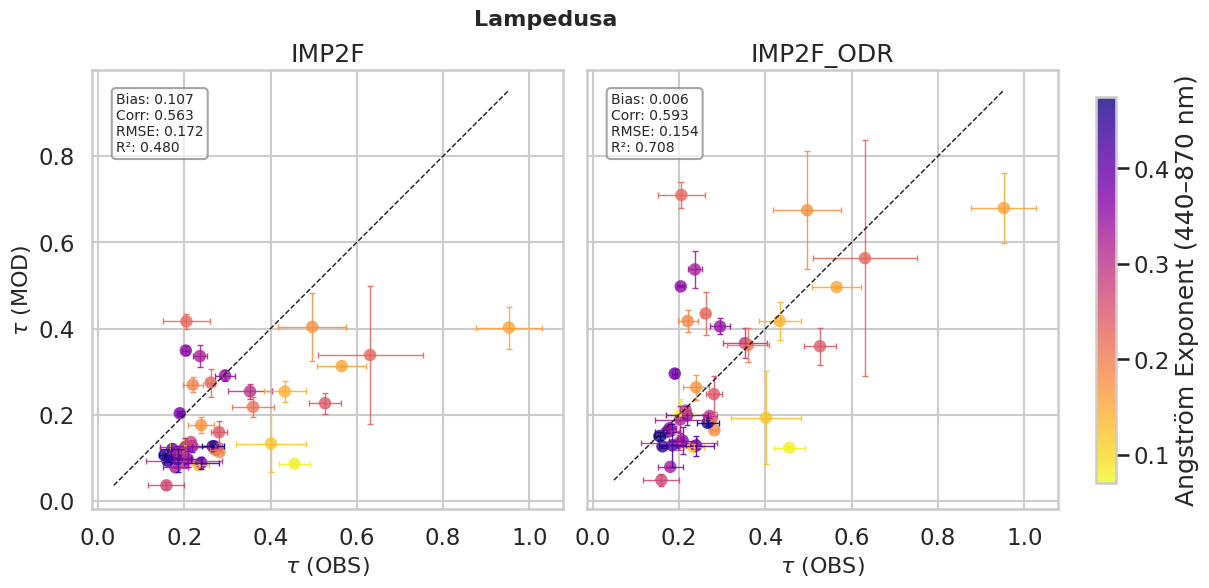

In [ ]:
df_dump = dataframes['lampedusa_DD']
df_dump['time'] = pd.to_datetime(df_dump['time'])
t2_lampedusa = pd.to_datetime(pd.Timestamp("2024-08-31"))
t3_lampedusa = pd.to_datetime(dataframes["lampedusa_df"]['time'].iloc[-1])
df = df_dump[(df_dump['time'] >= t2_lampedusa) & (df_dump['time'] <= t3_lampedusa)]
obs = df['LMP']
ang = df['ang_440_870']
preds = df[['IMP2F', 'IMP2F_ODR']]
err_x = df['err_day_new']
errs = df[['err_IMP2_24', 'err_IMP2_24_ODR']]
cmap = "plasma_r"

f, axs = plt.subplots(1, 2, figsize=(12, 8), constrained_layout=True, sharex=True, sharey=True)
axs = axs.flatten()
plt.suptitle("Lampedusa", fontsize=16, fontweight='bold', x=0.45, y=0.85)

# Normalize color scale for the angstrom values
norm = plt.Normalize(vmin=ang.min(), vmax=ang.max())
colors = plt.colormaps.get_cmap(cmap)(norm(ang))

for i, ax in enumerate(axs):
    pred = preds.iloc[:, i]
    err_y = errs.iloc[:, i]
    
    for k in range(len(df)):
        ax.errorbar(
            obs.iloc[k], pred.iloc[k],
            xerr=err_x.iloc[k], yerr=err_y.iloc[k],
            fmt='o', markersize=1,
            markerfacecolor='none', markeredgecolor=colors[k],
            ecolor=colors[k], elinewidth=1, capsize=2, alpha=0.9
        )
    
    sc = ax.scatter(obs, pred, c=ang, cmap=cmap, norm=norm, edgecolor='none', alpha=0.8)
    
    if i == 0: 

         textstr = '\n'.join((
        f'Bias: 0.107',
        f'Corr: 0.563',
        f'RMSE: 0.172',
        f'R²: 0.480'
        ))
         
    else: 

        textstr = '\n'.join((
            f'Bias: 0.006',
            f'Corr: 0.593',
            f'RMSE: 0.154',
            f'R²: 0.708'
        ))

    props = dict(boxstyle='round', facecolor='white', alpha=0.7, edgecolor='gray')
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=props)
    
    min_val = min(obs.min(), pred.min())
    max_val = max(obs.max(), pred.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', lw=1)
    ax.set_aspect('equal', adjustable='box')
    
    ax.set_title(preds.columns[i])
    ax.set_xlabel(r"$\tau$ (OBS)", fontsize=16)
    if i == 0:
        ax.set_ylabel(r"$\tau$ (MOD)", fontsize=16)
    ax.grid(True)

# Add colorbar
cbar = f.colorbar(sc, ax=axs, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label("Angström Exponent (440–870 nm)")

plt.show()

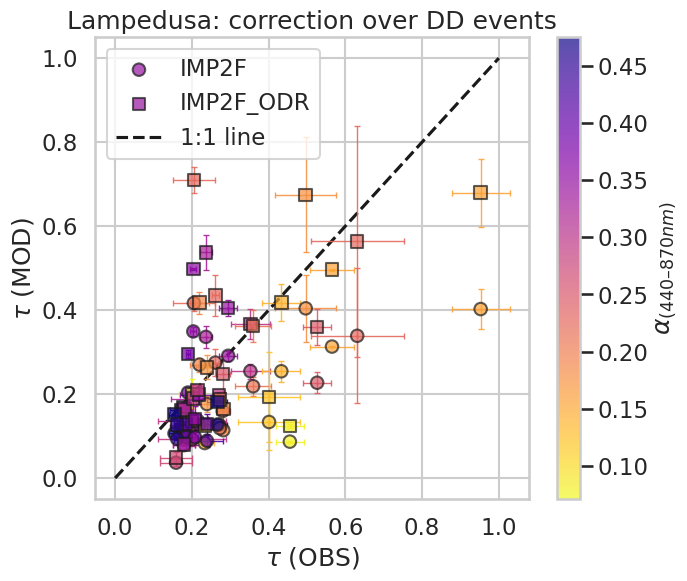

In [ ]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(7,6))

norm = plt.Normalize(vmin=ang.min(), vmax=ang.max())
colors = plt.colormaps.get_cmap(cmap)(norm(ang))

# Scatter plot for Model A
sc1 = ax.scatter(obs, preds.iloc[:, 0], c=ang, cmap=cmap, label='IMP2F', marker='o', edgecolor='k', zorder=3, alpha=0.7)
# Error bars for Model A
for k in range(len(df)):
        ax.errorbar(
            obs.iloc[k], preds.iloc[k, 0],
            xerr=err_x.iloc[k], yerr=errs.iloc[k, 0],
            fmt='o', markersize=1,
            markerfacecolor='none', markeredgecolor=colors[k],
            ecolor=colors[k], elinewidth=1, capsize=2, alpha=0.9
        )
# ax.errorbar(obs, preds.iloc[:, 0], xerr=err_x, yerr=errs.iloc[:, 0],
#             fmt='none', markeredgecolor=colors[0],
#             ecolor=colors[0], alpha=0.6, capsize=2, zorder=2)

# Scatter plot for Model B
sc2 = ax.scatter(obs, preds.iloc[:, 1], c=ang, cmap=cmap, label='IMP2F_ODR', marker='s', edgecolor='k', zorder=3, alpha=0.7)
# Error bars for Model B
for k in range(len(df)):
        ax.errorbar(
            obs.iloc[k], preds.iloc[k, 1],
            xerr=err_x.iloc[k], yerr=errs.iloc[k, 1],
            fmt='o', markersize=1,
            markerfacecolor='none', markeredgecolor=colors[k],
            ecolor=colors[k], elinewidth=1, capsize=2, alpha=0.9
        )
# ax.errorbar(obs, preds.iloc[:, 1], xerr=err_x, yerr=errs.iloc[:, 1],
#             fmt='none', markeredgecolor=colors[1],
#             ecolor=colors[1], alpha=0.6, capsize=2, zorder=2)

# Add 1:1 line
ax.plot([0, 1], [0, 1], 'k--', label='1:1 line', zorder=1)

# Colorbar (shared)
cbar = plt.colorbar(sc1, ax=ax)
cbar.set_label(r'$\alpha_{(440–870 nm)}$')

# Labels, legend, grid
ax.set_xlabel(r'$\tau$ (OBS)')
ax.set_ylabel(r'$\tau$ (MOD)')
ax.legend()
ax.grid(True)
ax.set_title('Lampedusa: correction over DD events')

plt.show()

# **Modena**

In [ ]:
modena_df['time'] = pd.to_datetime(modena_df['time'])
t1_modena = pd.to_datetime(modena_df['time'].iloc[0])
t2_modena = pd.to_datetime(pd.Timestamp("2024-08-31"))
t3_modena = pd.to_datetime(modena_df['time'].iloc[-1])

# DD events
modena_dd = modena_df[(modena_df['LMP'] >= 0.15) & (modena_df['ang_440_870'] <= 0.5)]
md_dd_trial = modena_dd[(modena_dd['time'] >= t1_modena) & (modena_dd['time'] <= t2_modena)]
md_dd_test = modena_dd[(modena_dd['time'] >= t2_modena) & (modena_dd['time'] <= t3_modena)]

# filtering daylight hours
city = LocationInfo("Lampedusa", "Italy", "Europe/Rome", 44.6, 10.9)  # Use your location
tz = pytz.timezone(city.timezone)
md_dd_trial = md_dd_trial.copy()
md_dd_trial['time'] = pd.to_datetime(md_dd_trial['time'])
# Apply to DataFrame
md_dd_trial['max_daylight_hours'] = md_dd_trial.apply(lambda row: compute_max_daylight(city, row), axis=1)
md_dd_trial_filtered = md_dd_trial[md_dd_trial['n'] > 0.5 * md_dd_trial['max_daylight_hours']]

# Set seaborn style
sns.set(style="whitegrid", context="talk")

# Set up subplots
fig, axs = plt.subplots(3, 1, figsize=(12, 8), sharex=True, sharey=True)
df = modena_df

# Fancy line plot with smoothing (rolling mean)
axs[0].scatter(df['time'], df['LMP'], label='obs', color='#1f77b4', edgecolor='black', s=100, zorder=3)
# axs[0].set_ylabel(r'${\tau}$')
axs[0].set_title('Obs')
#axs[0].legend(loc='upper left')
axs[0].grid(True, linestyle='--', alpha=0.5)

# Fancy bar plot
axs[1].scatter(df['time'], df['IMP1F'], color='#ff7f0e', edgecolor='black', zorder=3, s=100)
axs[1].set_ylabel(r'${\tau}$')
axs[1].set_title('IMP1F')
axs[1].grid(True, axis='y', linestyle=':', alpha=0.5)

# Fancy scatter plot with annotations
axs[2].scatter(df['time'], df['IMP2F'], s=100, color='#2ca02c', edgecolor='black', zorder=3)
# axs[2].set_ylabel('obs3')
axs[2].set_title('IMP2F')

axs[2].set_xlabel('Time')
axs[2].grid(True, linestyle='--', alpha=0.4)

# Beautify x-axis
plt.xticks(rotation=45)
plt.tight_layout()
plt.suptitle("Modena", fontsize=18, y=1.02, fontweight='bold')
plt.subplots_adjust(hspace=0.4)

plt.show()


plot_scatter(
    modena_dd,
    ['LMP', 'IMP1F', 'IMP2F', 'IMP1F_ODR', 'IMP2F_ODR', 'ang_440_870'],
    cmap='plasma_r',
    stats=True,
    name="Modena")

odr_linear_fit_plot(md_dd_trial_filtered, "LMP", "IMP1F", "err_day_new", "err_IMP1_24", "Modena (ODR)")
odr_linear_fit_plot(md_dd_trial_filtered, "LMP", "IMP2F", "err_day_new", "err_IMP2_24", "Modena (ODR)")

NameError: name 'modena_df' is not defined

# **Napoli**

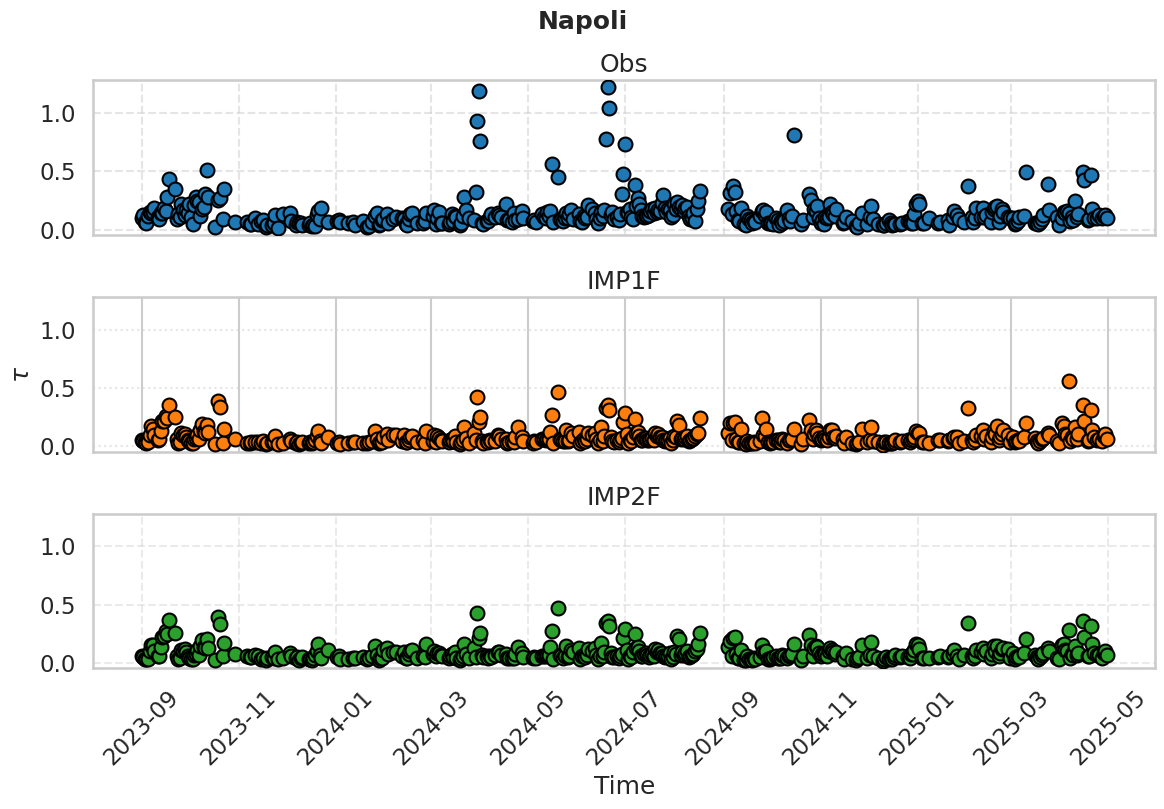

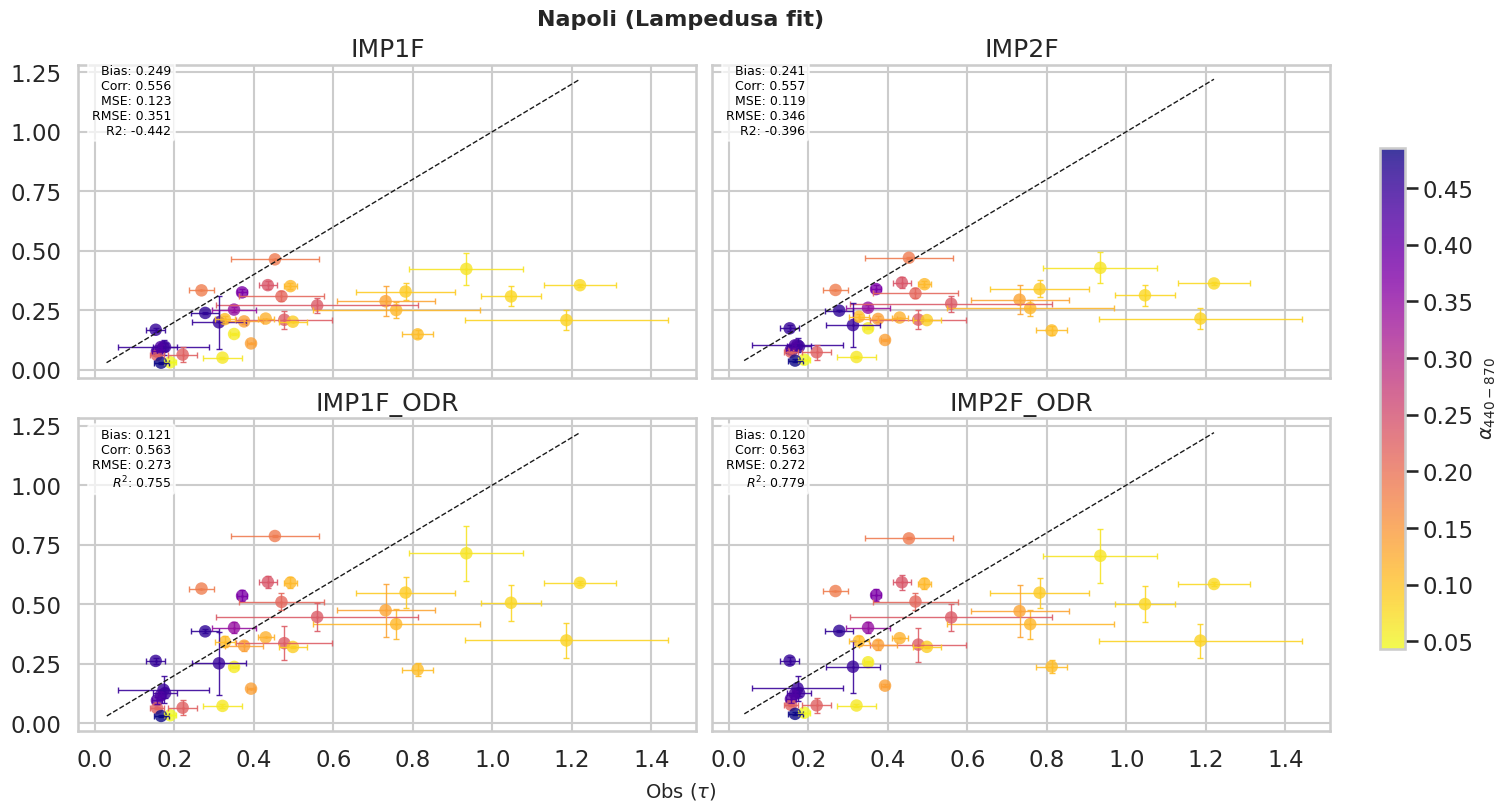

(array([0.30368866]),
 array([0.01073507]),
 array([ 0.0509176 ,  0.14442253,  0.02877205,  0.03634145,  0.10721163,
         0.04427087, -0.00805661, -0.00516282,  0.06576501]),
 <Figure size 1200x800 with 2 Axes>)

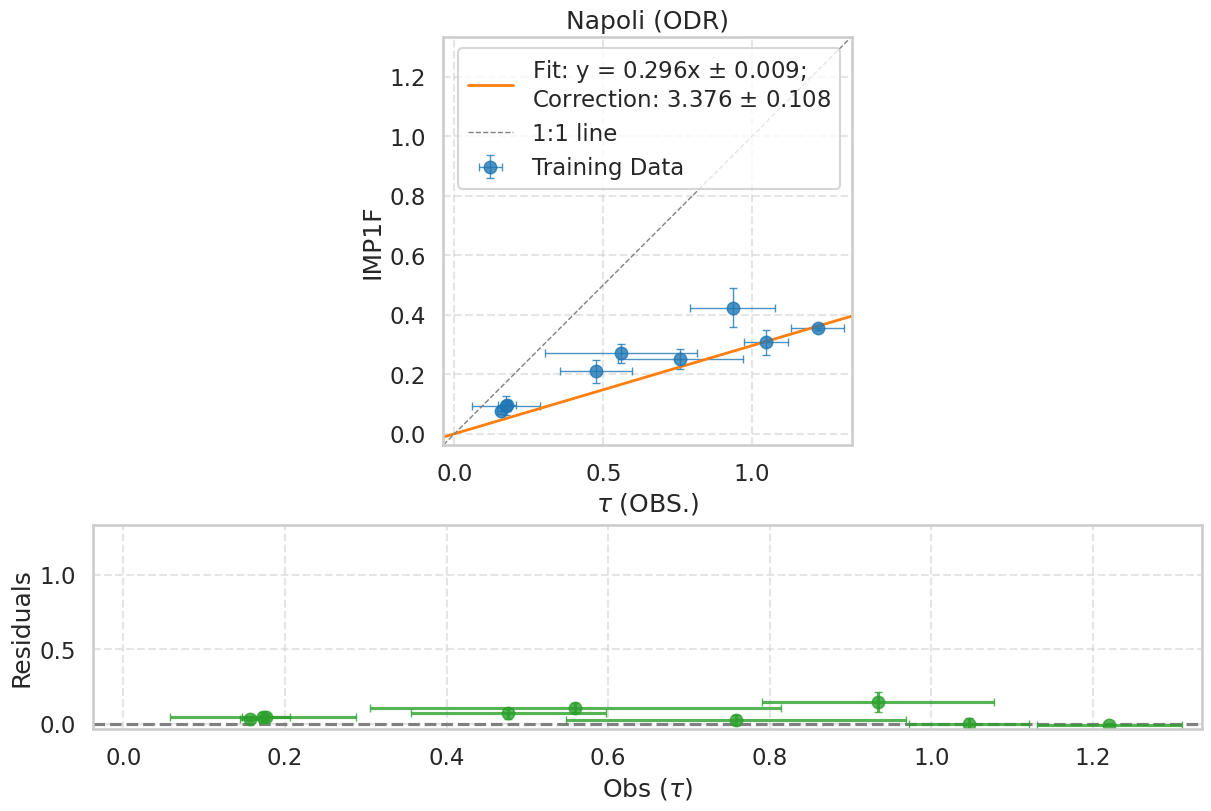

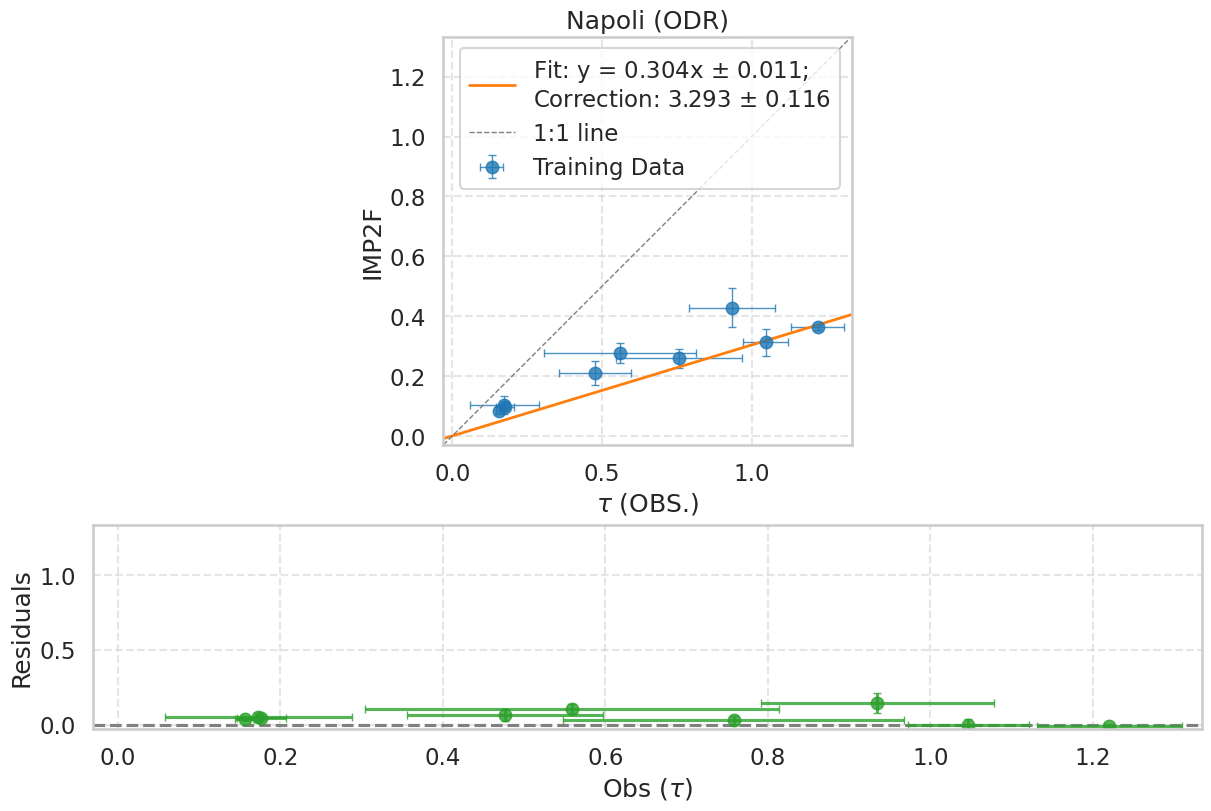

In [9]:
dataframes['napoli_df']['time'] = pd.to_datetime(dataframes['napoli_df']['time'])
dataframes['napoli_DD_filtered']['time'] = pd.to_datetime(dataframes['napoli_DD_filtered']['time'])
t1_napoli = pd.to_datetime(dataframes['napoli_df']['time'].iloc[0])
t2_napoli = pd.to_datetime(pd.Timestamp("2024-08-31"))
t3_napoli = pd.to_datetime(dataframes['napoli_df']['time'].iloc[-1])

# DD events
import numpy as np
mean_obs = np.mean(dataframes['napoli_DD_filtered']['LMP'])
std_obs = np.mean(dataframes['napoli_DD_filtered']['LMP'])

napoli_dd = dataframes['napoli_df'][(dataframes['napoli_df']['LMP'] >= 0.15) & (dataframes['napoli_df']['ang_440_870'] <= 0.5)]

np_dd_trial_f = dataframes['napoli_DD_filtered'][(dataframes['napoli_DD_filtered']['time'] >= t1_napoli) & (dataframes['napoli_DD_filtered']['time'] <= t2_napoli)]
np_dd_test_f = dataframes['napoli_DD_filtered'][(dataframes['napoli_DD_filtered']['time'] >= t2_napoli) & (dataframes['napoli_DD_filtered']['time'] <= t3_napoli)]

np_dd_trial_f = dataframes['napoli_DD_filtered'][(np.abs(dataframes['napoli_DD_filtered']['LMP']-mean_obs) <= 3 * std_obs)]

np_dd_trial = napoli_dd[(napoli_dd['time'] >= t1_napoli) & (napoli_dd['time'] <= t2_napoli)]
np_dd_test = napoli_dd[(napoli_dd['time'] >= t2_napoli) & (napoli_dd['time'] <= t3_napoli)]

# # filtering daylight hours
# city = LocationInfo("Lampedusa", "Italy", "Europe/Rome", 40.8, 14.3)  # Use your location
# tz = pytz.timezone(city.timezone)
# np_dd_trial = np_dd_trial.copy()
# np_dd_trial['time'] = pd.to_datetime(np_dd_trial['time'])
# # Apply to DataFrame
# np_dd_trial['max_daylight_hours'] = np_dd_trial.apply(lambda row: compute_max_daylight(city, row), axis=1)
# np_dd_trial_filtered = np_dd_trial[np_dd_trial['n'] > 0.5 * np_dd_trial['max_daylight_hours']]

k = 2

mean_obs = np.mean(dataframes['napoli_DD_filtered']['LMP'])
std_obs = np.std(dataframes['napoli_DD_filtered']['LMP'])

mean_obs_1 = np.mean(dataframes['napoli_DD_filtered']['IMP1F'])
std_obs_1 = np.std(dataframes['napoli_DD_filtered']['IMP1F'])

mean_obs_2 = np.mean(dataframes['napoli_DD_filtered']['IMP2F'])
std_obs_2 = np.std(dataframes['napoli_DD_filtered']['IMP2F'])

np_dd_trial_f = dataframes["napoli_DD_filtered"][(dataframes["napoli_DD_filtered"]['time'] >= t1_napoli) & (dataframes["napoli_DD_filtered"]['time'] <= t2_napoli)]
np_trial_prova = np_dd_trial_f[(np_dd_trial_f['LMP'] >= 0.35) & (np_dd_trial_f['ang_440_870'] <= 0.3) & (np.abs(np_dd_trial_f['IMP1F']-mean_obs_1) <= k * std_obs_1) &
                               (np.abs(np_dd_trial_f['IMP2F']-mean_obs_2) <= k * std_obs_2) & (np.abs(np_dd_trial_f['LMP']-mean_obs) <= k * std_obs)]

# df_pesi = dataframes['napoli_DD_filtered'].copy()
# df_pesi['pesi_obs'] = np.power(dataframes['napoli_DD_filtered']['LMP'], 2)/(np.power(dataframes['napoli_DD_filtered']['err_day_new'], 2))
# df_pesi['pesi_imp1'] = np.power(dataframes['napoli_DD_filtered']['IMP1F'], 2)/(np.power(dataframes['napoli_DD_filtered']['err_IMP1_24'], 2))
# df_pesi['pesi_imp2'] = np.power(dataframes['napoli_DD_filtered']['IMP2F'], 2)/(np.power(dataframes['napoli_DD_filtered']['err_IMP2_24'], 2))

# mean_pesi_obs = np.mean(df_pesi['pesi_obs'])
# std_pesi_obs = np.std(df_pesi['pesi_obs'])

# mean_pesi_imp1 = np.mean(df_pesi['pesi_imp1']) 
# std_pesi_imp1 = np.std(df_pesi['pesi_imp1'])

# mean_pesi_imp2 = np.mean(df_pesi['pesi_imp2']) 
# std_pesi_imp2 = np.std(df_pesi['pesi_imp2'])

# prova = df_pesi[(np.abs(df_pesi['pesi_obs'] - mean_pesi_obs) <= 2 * std_pesi_obs) & (np.abs(df_pesi['pesi_imp1'] - mean_pesi_imp1) <= 2 * std_pesi_imp1) & (np.abs(df_pesi['pesi_imp2'] - mean_pesi_imp2) <= 2 * std_pesi_imp2)]

# plt.hist(df_pesi["pesi_obs"], bins=20, color='skyblue', edgecolor='black')
# plt.hist(df_pesi['pesi_imp1'], bins=20, color='green', edgecolor='black')
# plt.hist(df_pesi['pesi_imp2'], bins=20, color='red', edgecolor='black')
# plt.xlabel("Valori")
# plt.ylabel("Frequenza")
# plt.title("Distribuzione dei pesi (OBS)")
# plt.grid(True)
# plt.show()

# Set seaborn style
sns.set(style="whitegrid", context="talk")

# Set up subplots
fig, axs = plt.subplots(3, 1, figsize=(12, 8), sharex=True, sharey=True)
df = dataframes['napoli_df']

# Fancy line plot with smoothing (rolling mean)
axs[0].scatter(df['time'], df['LMP'], label='obs', color='#1f77b4', edgecolor='black', s=100, zorder=3)
# axs[0].set_ylabel(r'${\tau}$')
axs[0].set_title('Obs')
#axs[0].legend(loc='upper left')
axs[0].grid(True, linestyle='--', alpha=0.5)

# Fancy bar plot
axs[1].scatter(df['time'], df['IMP1F'], color='#ff7f0e', edgecolor='black', zorder=3, s=100)
axs[1].set_ylabel(r'${\tau}$')
axs[1].set_title('IMP1F')
axs[1].grid(True, axis='y', linestyle=':', alpha=0.5)

# Fancy scatter plot with annotations
axs[2].scatter(df['time'], df['IMP2F'], s=100, color='#2ca02c', edgecolor='black', zorder=3)
# axs[2].set_ylabel('obs3')
axs[2].set_title('IMP2F')

axs[2].set_xlabel('Time')
axs[2].grid(True, linestyle='--', alpha=0.4)

# Beautify x-axis
plt.xticks(rotation=45)
plt.tight_layout()
plt.suptitle("Napoli", fontsize=18, y=1.02, fontweight='bold')
plt.subplots_adjust(hspace=0.4)

plt.savefig("/home/andrea/enea/lmp_dust_enea/figure/napoli/np_time.png", format='png', dpi=300, bbox_inches='tight')
plt.show()


plot_scatter(
    dataframes['napoli_DD'],
    ['LMP', 'IMP1F', 'IMP2F', 'IMP1F_ODR', 'IMP2F_ODR', 'ang_440_870', 'err_day_new', 'err_IMP1_24', 'err_IMP2_24', 'err_IMP1_24_ODR', 'err_IMP2_24_ODR'],
    cmap='plasma_r',
    stats=True,
    name="Napoli (Lampedusa fit)", save=True,
    path="/home/andrea/enea/lmp_dust_enea/figure/napoli/np_DD_lm_fit.png")

odr_linear_fit_plot(np_dd_trial_f, "LMP", "IMP1F", "err_day_new", "err_IMP1_24", "Napoli (ODR)", save=True,
                    path="/home/andrea/enea/lmp_dust_enea/figure/lampedusa/np_DD_fit_IMP1.png")
odr_linear_fit_plot(np_dd_trial_f, "LMP", "IMP2F", "err_day_new", "err_IMP2_24", "Napoli (ODR)", save=True,
                    path="/home/andrea/enea/lmp_dust_enea/figure/lampedusa/np_DD_fit_IMP2.png")

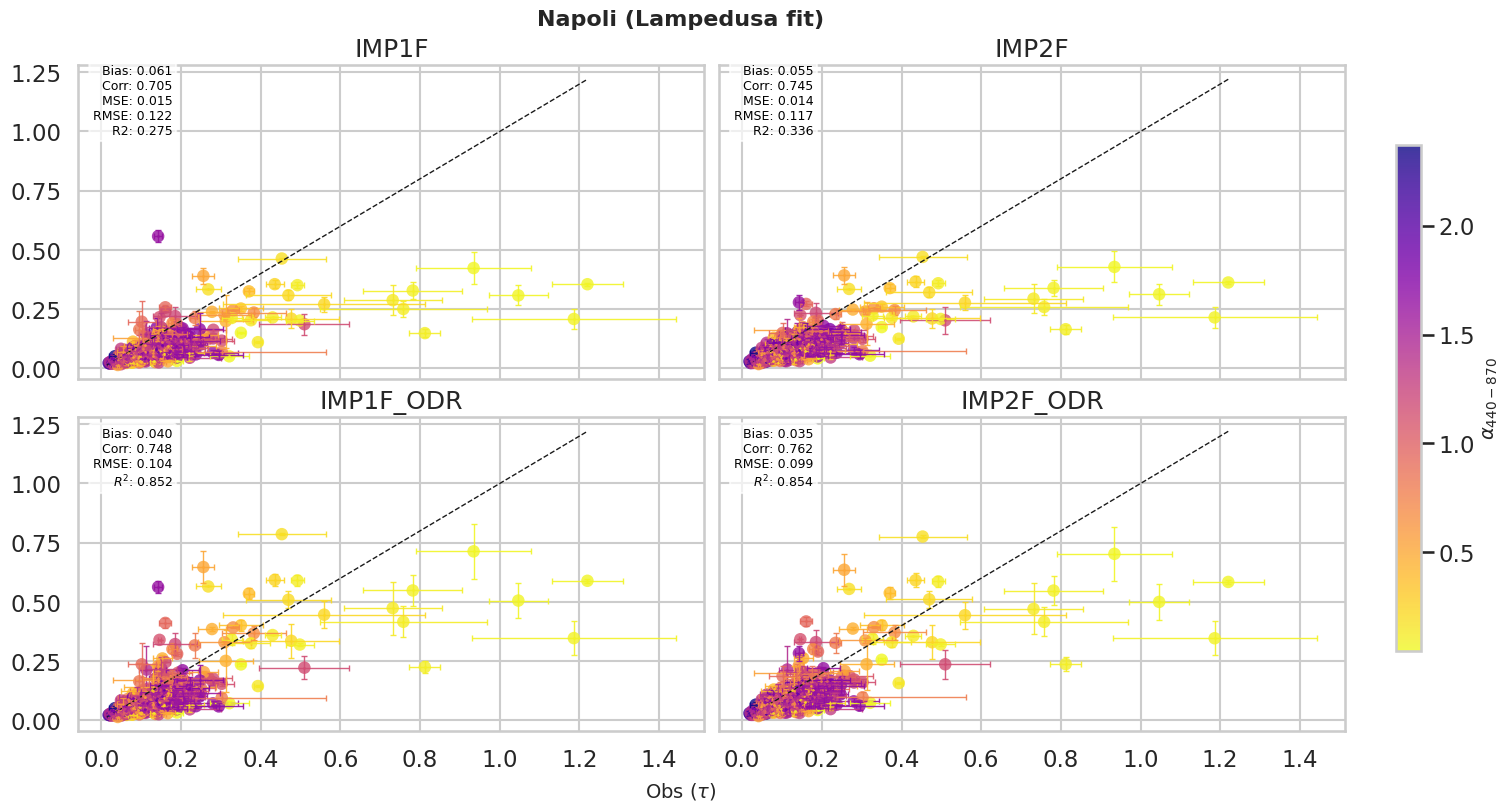

In [10]:
plot_scatter(
    dataframes['napoli_df'],
    ['LMP', 'IMP1F', 'IMP2F', 'IMP1F_ODR', 'IMP2F_ODR', 'ang_440_870', 'err_day_new', 'err_IMP1_24', 'err_IMP2_24', 'err_IMP1_24_ODR', 'err_IMP2_24_ODR'],
    cmap='plasma_r',
    stats=True,
    name="Napoli (Lampedusa fit)", save=False,
    path="/home/andrea/enea_project/lmp_dust_enea/figure/napoli/np_DD_lm_fit.png")

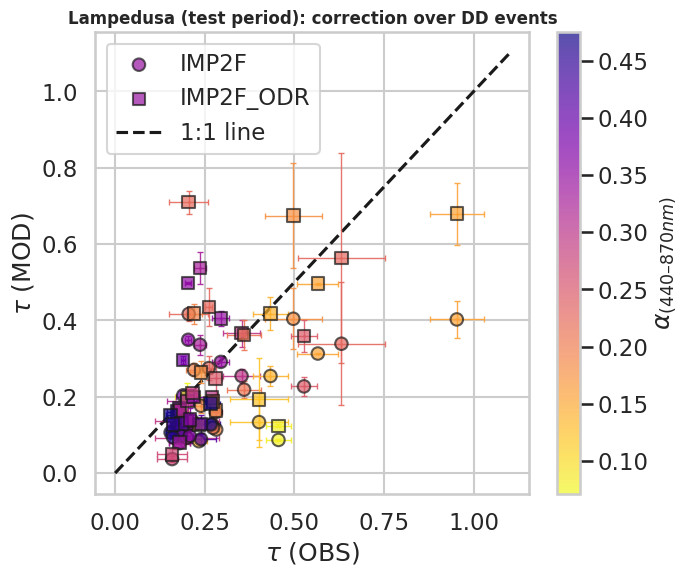

In [11]:
df_dump = dataframes['lampedusa_DD']
df_dump['time'] = pd.to_datetime(df_dump['time'])
t2_lampedusa = pd.to_datetime(pd.Timestamp("2024-08-31"))
t3_lampedusa = pd.to_datetime(dataframes["lampedusa_df"]['time'].iloc[-1])
df = df_dump[(df_dump['time'] >= t2_lampedusa) & (df_dump['time'] <= t3_lampedusa)]
obs = df['LMP']
ang = df['ang_440_870']
preds = df[['IMP2F', 'IMP2F_ODR']]
err_x = df['err_day_new']
errs = df[['err_IMP2_24', 'err_IMP2_24_ODR']]
cmap = "plasma_r"

# Create figure and axis
fig, ax = plt.subplots(figsize=(7,6))

norm = plt.Normalize(vmin=ang.min(), vmax=ang.max())
colors = plt.colormaps.get_cmap(cmap)(norm(ang))

# Scatter plot for Model A
sc1 = ax.scatter(obs, preds.iloc[:, 0], c=ang, cmap=cmap, label='IMP2F', marker='o', edgecolor='k', zorder=3, alpha=0.7)
# Error bars for Model A
for k in range(len(df)):
        ax.errorbar(
            obs.iloc[k], preds.iloc[k, 0],
            xerr=err_x.iloc[k], yerr=errs.iloc[k, 0],
            fmt='o', markersize=1,
            markerfacecolor='none', markeredgecolor=colors[k],
            ecolor=colors[k], elinewidth=1, capsize=2, alpha=0.9
        )
# ax.errorbar(obs, preds.iloc[:, 0], xerr=err_x, yerr=errs.iloc[:, 0],
#             fmt='none', markeredgecolor=colors[0],
#             ecolor=colors[0], alpha=0.6, capsize=2, zorder=2)

# Scatter plot for Model B
sc2 = ax.scatter(obs, preds.iloc[:, 1], c=ang, cmap=cmap, label='IMP2F_ODR', marker='s', edgecolor='k', zorder=3, alpha=0.7)
# Error bars for Model B
for k in range(len(df)):
        ax.errorbar(
            obs.iloc[k], preds.iloc[k, 1],
            xerr=err_x.iloc[k], yerr=errs.iloc[k, 1],
            fmt='o', markersize=1,
            markerfacecolor='none', markeredgecolor=colors[k],
            ecolor=colors[k], elinewidth=1, capsize=2, alpha=0.9
        )
# ax.errorbar(obs, preds.iloc[:, 1], xerr=err_x, yerr=errs.iloc[:, 1],
#             fmt='none', markeredgecolor=colors[1],
#             ecolor=colors[1], alpha=0.6, capsize=2, zorder=2)

# Add 1:1 line
ax.plot([0, 1.1], [0, 1.1], 'k--', label='1:1 line', zorder=1)

# Colorbar (shared)
cbar = plt.colorbar(sc1, ax=ax)
cbar.set_label(r'$\alpha_{(440–870 nm)}$')

# Labels, legend, grid
ax.set_xlabel(r'$\tau$ (OBS)')
ax.set_ylabel(r'$\tau$ (MOD)')
ax.legend()
ax.grid(True)
ax.set_title('Lampedusa (test period): correction over DD events', fontweight="bold", fontsize=12)

plt.savefig("/home/andrea/enea/lmp_dust_enea/figure/lampedusa_obs_mod_unite.png", dpi=300, format='png', bbox_inches='tight')
plt.show()

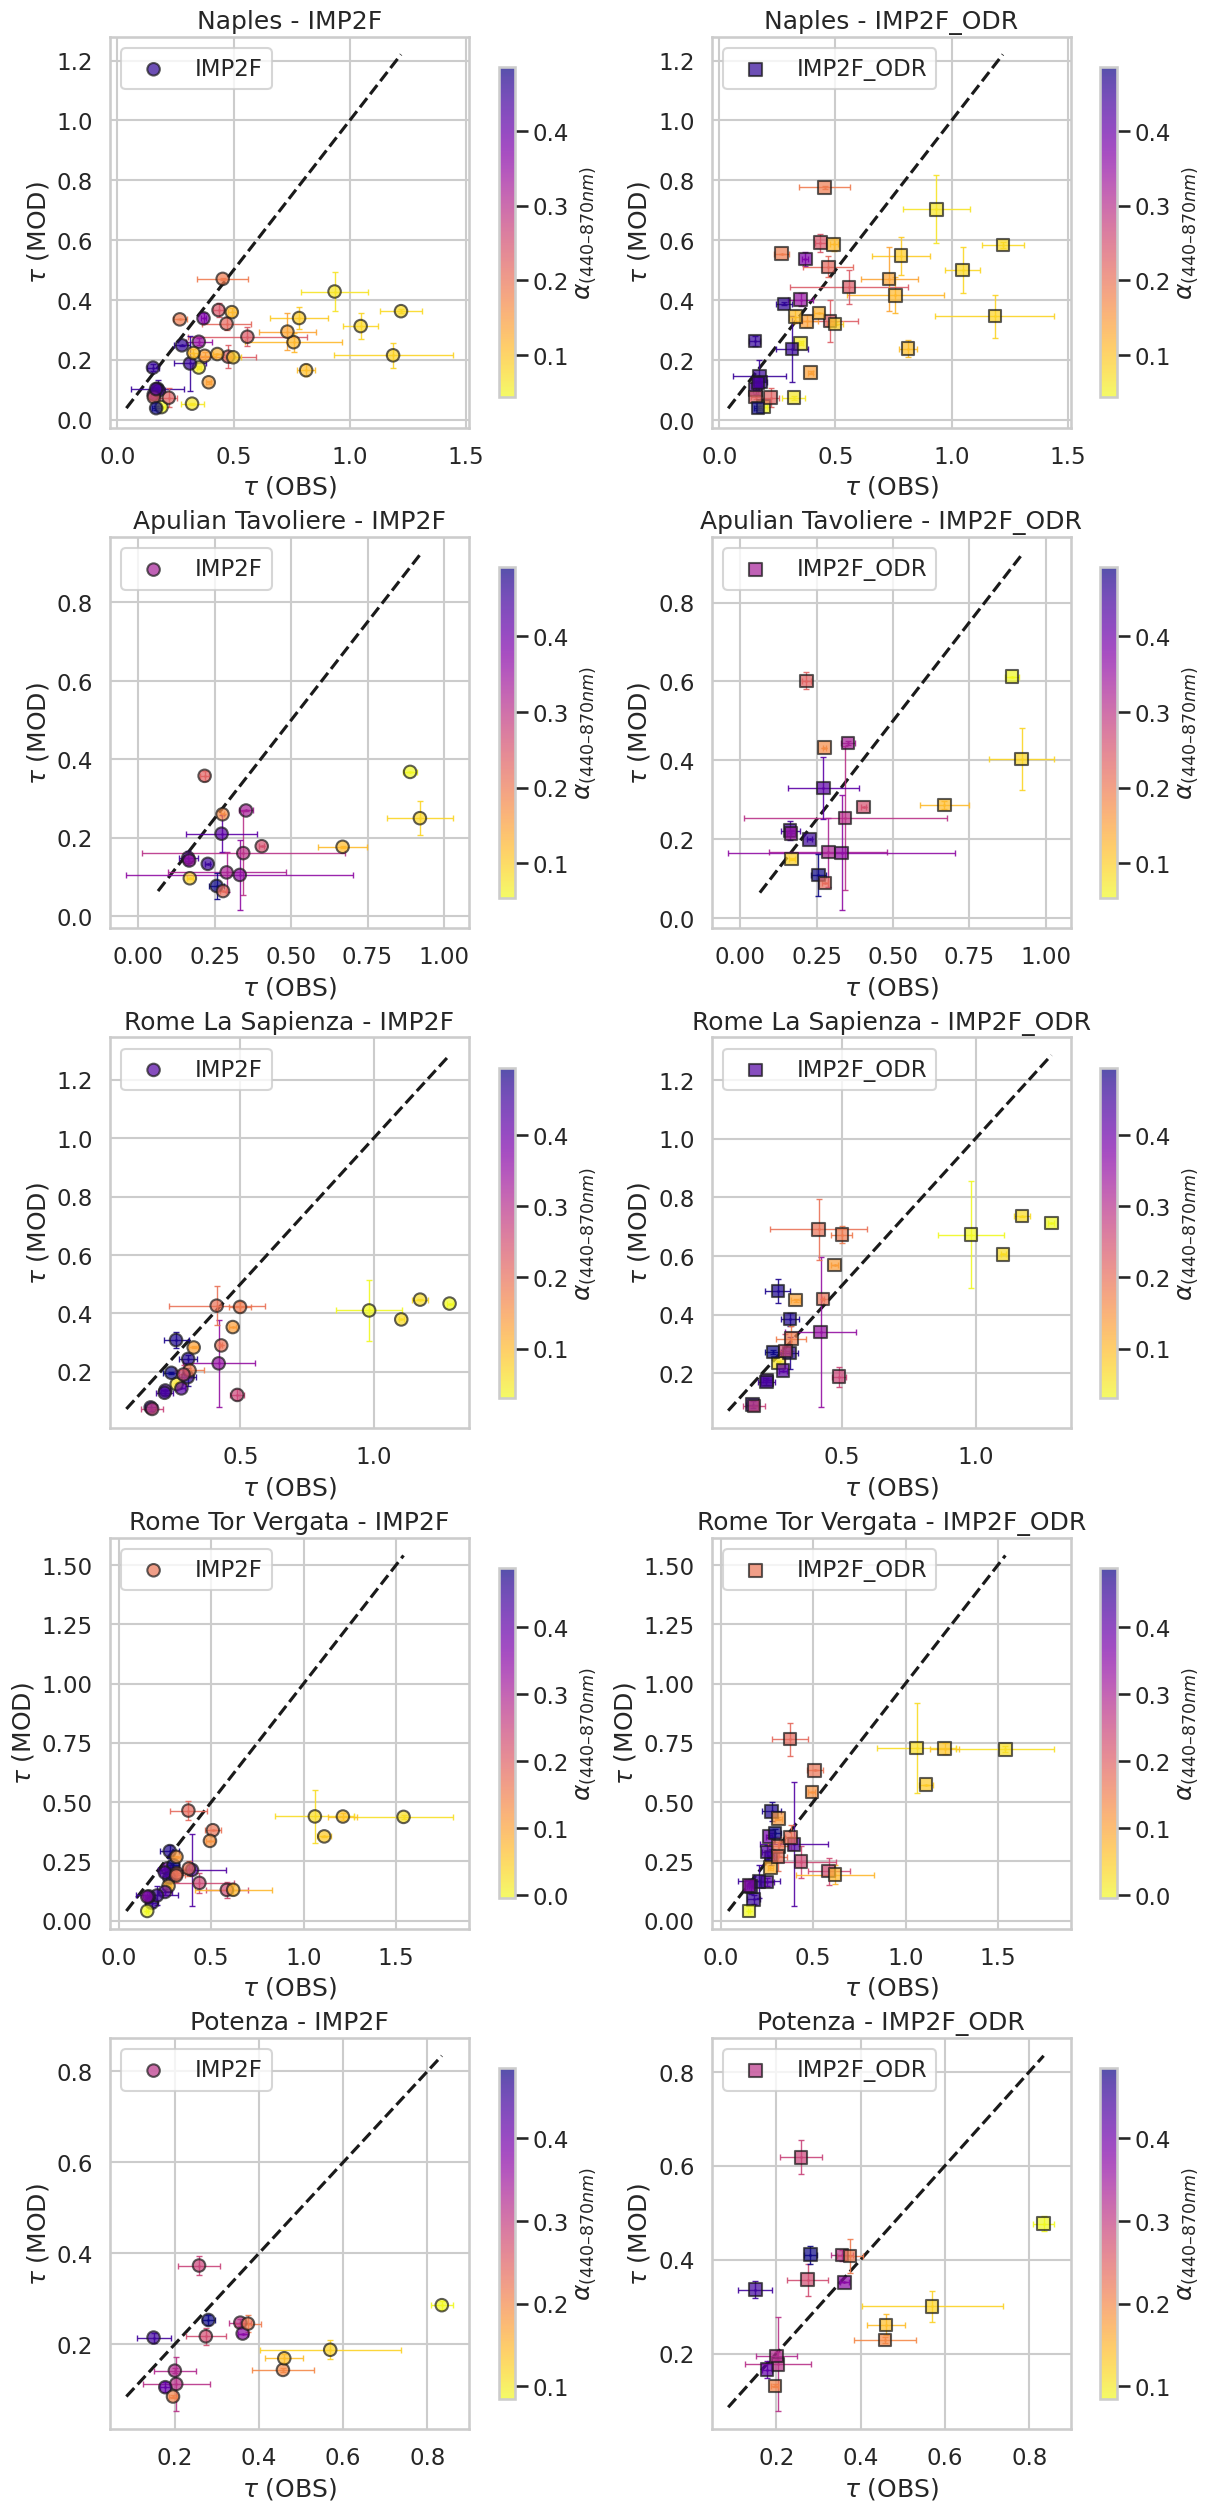

In [12]:
import matplotlib.pyplot as plt
import numpy as np

places = ['napoli_DD', 'apulian_tavoliere_DD', 'roma_la_sapienza_DD', 'roma_tor_vergata_DD', 'potenza_DD']  # extend as needed
models = ['IMP2F', 'IMP2F_ODR']
cmap = 'plasma_r'

place_names = {
    'napoli_DD': 'Naples',
    'apulian_tavoliere_DD': 'Apulian Tavoliere',
    'roma_la_sapienza_DD': 'Rome La Sapienza',
    'roma_tor_vergata_DD': 'Rome Tor Vergata',
    'potenza_DD': 'Potenza'
}

fig, axs = plt.subplots(len(places), 2, figsize=(12, 5*len(places)), constrained_layout=True)

# flatten axs if needed for easy indexing
axs = np.array(axs)

for i, place in enumerate(places):
    df = dataframes[place]
    obs = df['LMP']
    ang = df['ang_440_870']
    preds = df[models]
    err_x = df['err_day_new']
    errs = df[['err_IMP2_24', 'err_IMP2_24_ODR']]

    norm = plt.Normalize(vmin=ang.min(), vmax=ang.max())
    colors = plt.colormaps.get_cmap(cmap)(norm(ang))

    for j, model in enumerate(models):
        ax = axs[i, j]

        # Scatter plot with error bars
        sc = ax.scatter(obs, preds.iloc[:, j], c=ang, cmap=cmap, label=model,
                        marker='o' if j==0 else 's', edgecolor='k', zorder=3, alpha=0.7)
        for k in range(len(df)):
            ax.errorbar(
                obs.iloc[k], preds.iloc[k, j],
                xerr=err_x.iloc[k], yerr=errs.iloc[k, j],
                fmt='o', markersize=1,
                markerfacecolor='none', markeredgecolor=colors[k],
                ecolor=colors[k], elinewidth=1, capsize=2, alpha=0.9
            )

        # 1:1 line
        min_val = min(obs.min(), preds.min().min())
        max_val = max(obs.max(), preds.max().max())
        ax.plot([min_val, max_val], [min_val, max_val], 'k--', zorder=1)

        ax.set_title(f"{place_names[place]} - {model}")
        ax.set_xlabel(r'$\tau$ (OBS)')
        ax.set_ylabel(r'$\tau$ (MOD)')
        ax.grid(True)
        ax.legend()

        # Add colorbar
        cbar = fig.colorbar(sc, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label(r'$\alpha_{(440–870 nm)}$')

plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import math

places = ['lampedusa_DD', 'napoli_DD', 'apulian_tavoliere_DD', 'roma_la_sapienza_DD', 
          'roma_tor_vergata_DD', 'potenza_DD']
models = ['IMP2F', 'IMP2F_ODR']
markers = ['o', 's']

place_names = {
    'lampedusa_DD': 'Lampedusa',
    'napoli_DD': 'Naples',
    'apulian_tavoliere_DD': 'Apulian Tavoliere',
    'roma_la_sapienza_DD': 'Rome La Sapienza',
    'roma_tor_vergata_DD': 'Rome Tor Vergata',
    'potenza_DD': 'Potenza'
}

cmap = "plasma_r"
n_cols = 3
n_rows = math.ceil(len(places)/n_cols)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*4), constrained_layout=True)
axs = axs.flatten()  # Flatten in case of multiple rows

for i, place in enumerate(places):

    if place == 'lampedusa_DD':
        df_dump = dataframes[place]
        df_dump['time'] = pd.to_datetime(df_dump['time'])
        t2_lampedusa = pd.Timestamp("2024-08-31")
        t3_lampedusa = dataframes["lampedusa_df"]['time'].iloc[-1]
        df = df_dump[(df_dump['time'] >= t2_lampedusa) & (df_dump['time'] <= t3_lampedusa)]
        print(len(df))
    else:
        df = dataframes[place]
        
    obs = df['LMP']
    ang = df['ang_440_870']
    preds = df[models]
    err_x = df['err_day_new']
    errs = df[['err_IMP2_24', 'err_IMP2_24_ODR']]

    norm = plt.Normalize(vmin=ang.min(), vmax=ang.max())
    colors = plt.colormaps.get_cmap(cmap)(norm(ang))

    ax = axs[i]

    for j, model in enumerate(models):
        # Scatter points
        sc = ax.scatter(obs, preds.iloc[:, j], c=ang, cmap=cmap, marker=markers[j],
                        edgecolor='k', alpha=0.7, label=model)

        # Error bars
        for k in range(len(df)):
            ax.errorbar(
                obs.iloc[k], preds.iloc[k, j],
                xerr=err_x.iloc[k], yerr=errs.iloc[k, j],
                fmt='o', markersize=1,
                markerfacecolor='none', markeredgecolor=colors[k],
                ecolor=colors[k], elinewidth=1, capsize=2, alpha=0.9
            )

    min_val = min(obs.min(), preds.min().min())
    max_val = max(obs.max(), preds.max().max())
    ax.plot([min_val, max_val], [min_val, max_val], 'k--')
    
    ax.set_title(f"{place_names[place]}", fontweight="bold", fontsize=12)
    ax.set_xlabel(r'$\tau$ (OBS)')
    ax.set_ylabel(r'$\tau$ (MOD)')
    ax.legend()
    ax.grid(True)

# Remove empty subplots if any
for j in range(len(places), n_rows*n_cols):
    fig.delaxes(axs[j])

# Shared colorbar for all subplots
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=axs, orientation='vertical', fraction=0.02, pad=0.02)
cbar.set_label(r'$\alpha_{(440–870 nm)}$')

#plt.savefig("/home/andrea/enea/lmp_dust_enea/figure/stations_obs_mod_unite.png", dpi=300, format='png', bbox_inches='tight')
plt.show()


SyntaxError: invalid syntax (722401863.py, line 67)

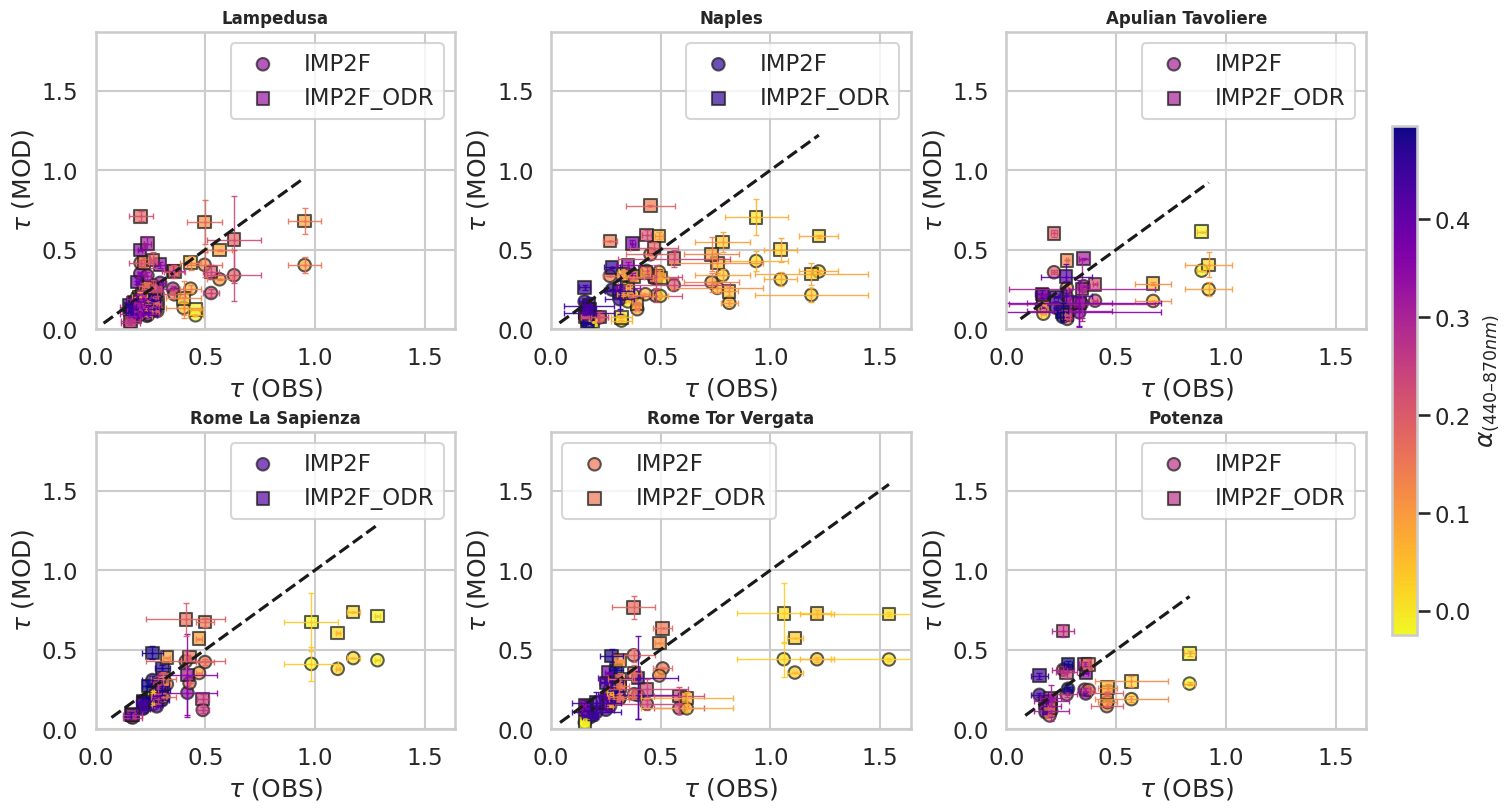

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import math

places = ['lampedusa_DD', 'napoli_DD', 'apulian_tavoliere_DD', 'roma_la_sapienza_DD', 
          'roma_tor_vergata_DD', 'potenza_DD']
models = ['IMP2F', 'IMP2F_ODR']
markers = ['o', 's']

place_names = {
    'lampedusa_DD': 'Lampedusa',
    'napoli_DD': 'Naples',
    'apulian_tavoliere_DD': 'Apulian Tavoliere',
    'roma_la_sapienza_DD': 'Rome La Sapienza',
    'roma_tor_vergata_DD': 'Rome Tor Vergata',
    'potenza_DD': 'Potenza'
}

cmap = "plasma_r"
n_cols = 3
n_rows = math.ceil(len(places)/n_cols)

# Compute global min/max for Angström exponent
all_ang = np.concatenate([dataframes[p]['ang_440_870'].values for p in places])
all_obs = np.concatenate([dataframes[p]['LMP'].values for p in places])
all_pred = np.concatenate([dataframes[p][mod].values for p in places for mod in models])
global_min_ang = all_ang.min()
global_max_ang = all_ang.max()
norm = plt.Normalize(vmin=global_min_ang, vmax=global_max_ang)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*4), constrained_layout=True)
axs = axs.flatten()

for i, place in enumerate(places):
     
    if place == 'lampedusa_DD':
        df_dump = dataframes[place]
        df_dump['time'] = pd.to_datetime(df_dump['time'])
        t2_lampedusa = pd.Timestamp("2024-08-31")
        t3_lampedusa = dataframes["lampedusa_df"]['time'].iloc[-1]
        df = df_dump[(df_dump['time'] >= t2_lampedusa) & (df_dump['time'] <= t3_lampedusa)]

    else:
        df = dataframes[place]

    obs = df['LMP']
    ang = df['ang_440_870']
    preds = df[models]
    err_x = df['err_day_new']
    errs = df[['err_IMP2_24', 'err_IMP2_24_ODR']]

    colors = plt.colormaps.get_cmap(cmap)(norm(ang))
    ax = axs[i]

    for j, model in enumerate(models):
        sc = ax.scatter(obs, preds.iloc[:, j], c=ang, cmap=cmap, marker=markers[j],
                        edgecolor='k', alpha=0.7, label=model)

        for k in range(len(df)):
            ax.errorbar(
                obs.iloc[k], preds.iloc[k, j],
                xerr=err_x.iloc[k], yerr=errs.iloc[k, j],
                fmt='o', markersize=1,
                markerfacecolor='none', markeredgecolor=colors[k],
                ecolor=colors[k], elinewidth=1, capsize=2, alpha=0.9
            )

    min_val = min(obs.min(), preds.min().min())
    max_val = max(obs.max(), preds.max().max())
    ax.plot([min_val, max_val], [min_val, max_val], 'k--')
    ax.set_xlim(0., all_obs.max()+0.1)
    ax.set_ylim(0., all_pred.max()+0.1)
    
    ax.set_title(f"{place_names[place]}", fontweight="bold", fontsize=12)
    ax.set_xlabel(r'$\tau$ (OBS)')
    ax.set_ylabel(r'$\tau$ (MOD)')
    ax.legend()
    ax.grid(True)

for j in range(len(places), n_rows*n_cols):
    fig.delaxes(axs[j])

# Shared colorbar with global normalization
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=axs, orientation='vertical', fraction=0.02, pad=0.02)
cbar.set_label(r'$\alpha_{(440–870 nm)}$')

plt.savefig("/home/andrea/enea/lmp_dust_enea/figure/stations_obs_mod_unite.png", dpi=300, format='png', bbox_inches='tight')
plt.show()


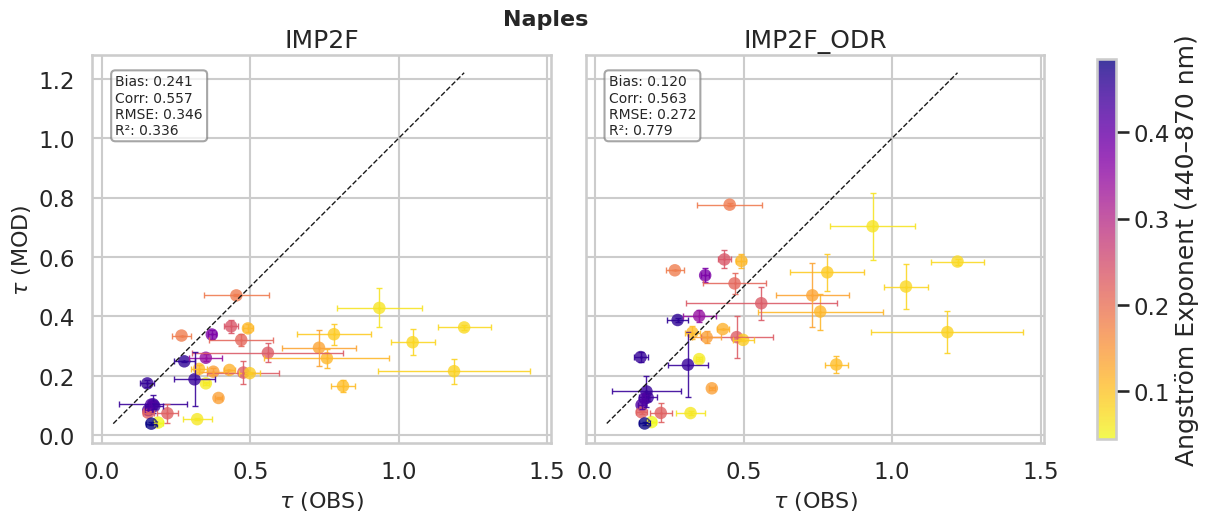

In [ ]:
df = dataframes['napoli_DD']
obs = df['LMP']
ang = df['ang_440_870']
preds = df[['IMP2F', 'IMP2F_ODR']]
err_x = df['err_day_new']
errs = df[['err_IMP2_24', 'err_IMP2_24_ODR']]
cmap = "plasma_r"

f, axs = plt.subplots(1, 2, figsize=(12, 8), constrained_layout=True, sharex=True, sharey=True)
axs = axs.flatten()
plt.suptitle("Naples", fontsize=16, fontweight='bold', x=0.45, y=0.80)

# Normalize color scale for the angstrom values
norm = plt.Normalize(vmin=ang.min(), vmax=ang.max())
colors = plt.colormaps.get_cmap(cmap)(norm(ang))

for i, ax in enumerate(axs):
    pred = preds.iloc[:, i]
    err_y = errs.iloc[:, i]
    
    for k in range(len(df)):
        ax.errorbar(
            obs.iloc[k], pred.iloc[k],
            xerr=err_x.iloc[k], yerr=err_y.iloc[k],
            fmt='o', markersize=1,
            markerfacecolor='none', markeredgecolor=colors[k],
            ecolor=colors[k], elinewidth=1, capsize=2, alpha=0.9
        )
    
    sc = ax.scatter(obs, pred, c=ang, cmap=cmap, norm=norm, edgecolor='none', alpha=0.8)

    n = len(df)
    metrics = calculate_metrics(obs.values, pred.values, n)
    bias, corr, rmse, var_y, mse, r2, adj_r2 = metrics

    if i == 0:
        textstr = '\n'.join((
            f'Bias: 0.241',
            f'Corr: 0.557',
            f'RMSE: 0.346', 
            f'R²: 0.336'
        ))
    else:
        textstr = '\n'.join((
            f'Bias: 0.120',
            f'Corr: 0.563',
            f'RMSE: 0.272', 
            f'R²: 0.779'
        ))

    props = dict(boxstyle='round', facecolor='white', alpha=0.7, edgecolor='gray')
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=props)
    
    min_val = min(obs.min(), pred.min())
    max_val = max(obs.max(), pred.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', lw=1)
    ax.set_aspect('equal', adjustable='box')
    
    ax.set_title(preds.columns[i])
    ax.set_xlabel(r"$\tau$ (OBS)", fontsize=16)
    if i == 0:
        ax.set_ylabel(r"$\tau$ (MOD)", fontsize=16)
    ax.grid(True)

# Add colorbar
cbar = f.colorbar(sc, ax=axs, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label("Angström Exponent (440–870 nm)")

plt.show()

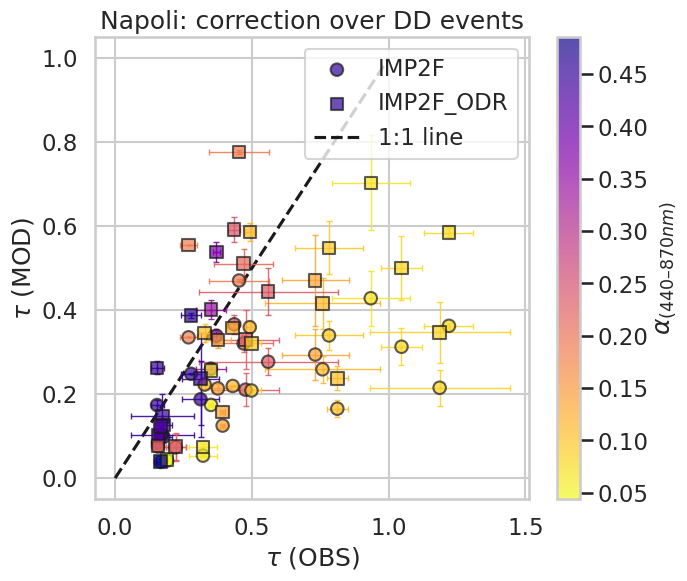

In [ ]:
df = dataframes['napoli_DD']
obs = df['LMP']
ang = df['ang_440_870']
preds = df[['IMP2F', 'IMP2F_ODR']]
err_x = df['err_day_new']
errs = df[['err_IMP2_24', 'err_IMP2_24_ODR']]
cmap = "plasma_r"

# Create figure and axis
fig, ax = plt.subplots(figsize=(7,6))

norm = plt.Normalize(vmin=ang.min(), vmax=ang.max())
colors = plt.colormaps.get_cmap(cmap)(norm(ang))

# Scatter plot for Model A
sc1 = ax.scatter(obs, preds.iloc[:, 0], c=ang, cmap=cmap, label='IMP2F', marker='o', edgecolor='k', zorder=3, alpha=0.7)
# Error bars for Model A
for k in range(len(df)):
        ax.errorbar(
            obs.iloc[k], preds.iloc[k, 0],
            xerr=err_x.iloc[k], yerr=errs.iloc[k, 0],
            fmt='o', markersize=1,
            markerfacecolor='none', markeredgecolor=colors[k],
            ecolor=colors[k], elinewidth=1, capsize=2, alpha=0.9
        )
# ax.errorbar(obs, preds.iloc[:, 0], xerr=err_x, yerr=errs.iloc[:, 0],
#             fmt='none', markeredgecolor=colors[0],
#             ecolor=colors[0], alpha=0.6, capsize=2, zorder=2)

# Scatter plot for Model B
sc2 = ax.scatter(obs, preds.iloc[:, 1], c=ang, cmap=cmap, label='IMP2F_ODR', marker='s', edgecolor='k', zorder=3, alpha=0.7)
# Error bars for Model B
for k in range(len(df)):
        ax.errorbar(
            obs.iloc[k], preds.iloc[k, 1],
            xerr=err_x.iloc[k], yerr=errs.iloc[k, 1],
            fmt='o', markersize=1,
            markerfacecolor='none', markeredgecolor=colors[k],
            ecolor=colors[k], elinewidth=1, capsize=2, alpha=0.9
        )
# ax.errorbar(obs, preds.iloc[:, 1], xerr=err_x, yerr=errs.iloc[:, 1],
#             fmt='none', markeredgecolor=colors[1],
#             ecolor=colors[1], alpha=0.6, capsize=2, zorder=2)

# Add 1:1 line
ax.plot([0, 1], [0, 1], 'k--', label='1:1 line', zorder=1)

# Colorbar (shared)
cbar = plt.colorbar(sc1, ax=ax)
cbar.set_label(r'$\alpha_{(440–870 nm)}$')

# Labels, legend, grid
ax.set_xlabel(r'$\tau$ (OBS)')
ax.set_ylabel(r'$\tau$ (MOD)')
ax.legend()
ax.grid(True)
ax.set_title('Napoli: correction over DD events')

plt.show()

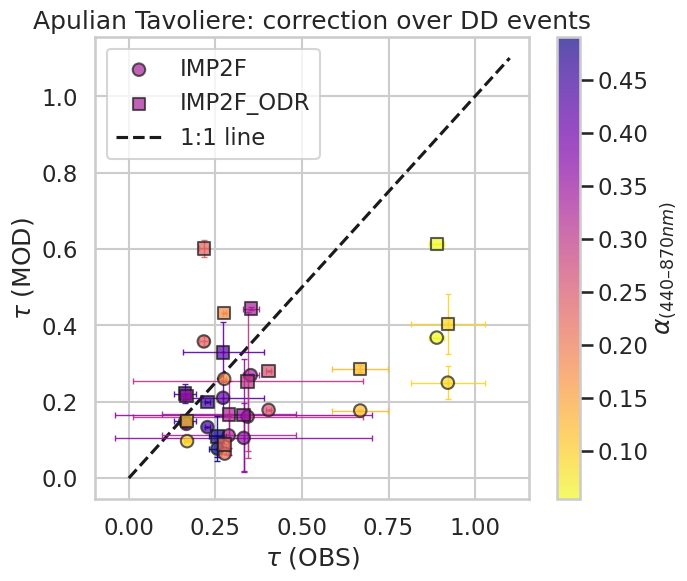

In [ ]:
df = dataframes['apulian_tavoliere_DD']
obs = df['LMP']
ang = df['ang_440_870']
preds = df[['IMP2F', 'IMP2F_ODR']]
err_x = df['err_day_new']
errs = df[['err_IMP2_24', 'err_IMP2_24_ODR']]
cmap = "plasma_r"

# Create figure and axis
fig, ax = plt.subplots(figsize=(7,6))

norm = plt.Normalize(vmin=ang.min(), vmax=ang.max())
colors = plt.colormaps.get_cmap(cmap)(norm(ang))

# Scatter plot for Model A
sc1 = ax.scatter(obs, preds.iloc[:, 0], c=ang, cmap=cmap, label='IMP2F', marker='o', edgecolor='k', zorder=3, alpha=0.7)
# Error bars for Model A
for k in range(len(df)):
        ax.errorbar(
            obs.iloc[k], preds.iloc[k, 0],
            xerr=err_x.iloc[k], yerr=errs.iloc[k, 0],
            fmt='o', markersize=1,
            markerfacecolor='none', markeredgecolor=colors[k],
            ecolor=colors[k], elinewidth=1, capsize=2, alpha=0.9
        )
# ax.errorbar(obs, preds.iloc[:, 0], xerr=err_x, yerr=errs.iloc[:, 0],
#             fmt='none', markeredgecolor=colors[0],
#             ecolor=colors[0], alpha=0.6, capsize=2, zorder=2)

# Scatter plot for Model B
sc2 = ax.scatter(obs, preds.iloc[:, 1], c=ang, cmap=cmap, label='IMP2F_ODR', marker='s', edgecolor='k', zorder=3, alpha=0.7)
# Error bars for Model B
for k in range(len(df)):
        ax.errorbar(
            obs.iloc[k], preds.iloc[k, 1],
            xerr=err_x.iloc[k], yerr=errs.iloc[k, 1],
            fmt='o', markersize=1,
            markerfacecolor='none', markeredgecolor=colors[k],
            ecolor=colors[k], elinewidth=1, capsize=2, alpha=0.9
        )
# ax.errorbar(obs, preds.iloc[:, 1], xerr=err_x, yerr=errs.iloc[:, 1],
#             fmt='none', markeredgecolor=colors[1],
#             ecolor=colors[1], alpha=0.6, capsize=2, zorder=2)

# Add 1:1 line
ax.plot([0, 1.1], [0, 1.1], 'k--', label='1:1 line', zorder=1)

# Colorbar (shared)
cbar = plt.colorbar(sc1, ax=ax)
cbar.set_label(r'$\alpha_{(440–870 nm)}$')

# Labels, legend, grid
ax.set_xlabel(r'$\tau$ (OBS)')
ax.set_ylabel(r'$\tau$ (MOD)')
ax.legend()
ax.grid(True)
ax.set_title('Apulian Tavoliere: correction over DD events')

plt.show()

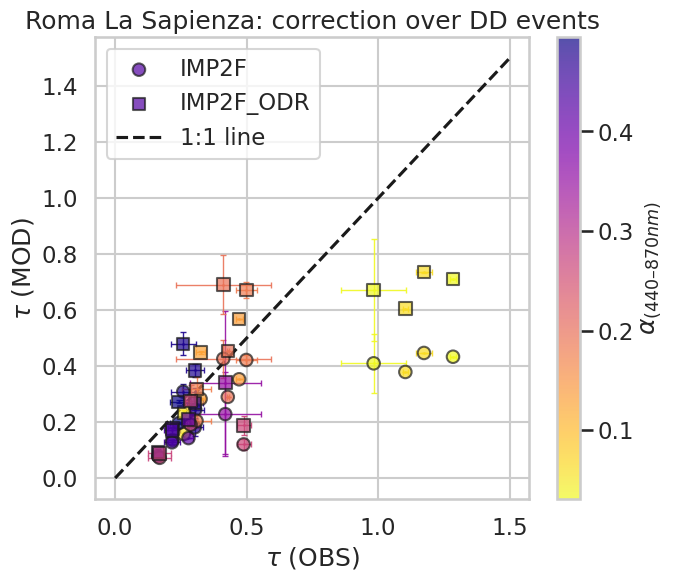

In [ ]:
df = dataframes['roma_la_sapienza_DD']
obs = df['LMP']
ang = df['ang_440_870']
preds = df[['IMP2F', 'IMP2F_ODR']]
err_x = df['err_day_new']
errs = df[['err_IMP2_24', 'err_IMP2_24_ODR']]
cmap = "plasma_r"

# Create figure and axis
fig, ax = plt.subplots(figsize=(7,6))

norm = plt.Normalize(vmin=ang.min(), vmax=ang.max())
colors = plt.colormaps.get_cmap(cmap)(norm(ang))

# Scatter plot for Model A
sc1 = ax.scatter(obs, preds.iloc[:, 0], c=ang, cmap=cmap, label='IMP2F', marker='o', edgecolor='k', zorder=3, alpha=0.7)
# Error bars for Model A
for k in range(len(df)):
        ax.errorbar(
            obs.iloc[k], preds.iloc[k, 0],
            xerr=err_x.iloc[k], yerr=errs.iloc[k, 0],
            fmt='o', markersize=1,
            markerfacecolor='none', markeredgecolor=colors[k],
            ecolor=colors[k], elinewidth=1, capsize=2, alpha=0.9
        )
# ax.errorbar(obs, preds.iloc[:, 0], xerr=err_x, yerr=errs.iloc[:, 0],
#             fmt='none', markeredgecolor=colors[0],
#             ecolor=colors[0], alpha=0.6, capsize=2, zorder=2)

# Scatter plot for Model B
sc2 = ax.scatter(obs, preds.iloc[:, 1], c=ang, cmap=cmap, label='IMP2F_ODR', marker='s', edgecolor='k', zorder=3, alpha=0.7)
# Error bars for Model B
for k in range(len(df)):
        ax.errorbar(
            obs.iloc[k], preds.iloc[k, 1],
            xerr=err_x.iloc[k], yerr=errs.iloc[k, 1],
            fmt='o', markersize=1,
            markerfacecolor='none', markeredgecolor=colors[k],
            ecolor=colors[k], elinewidth=1, capsize=2, alpha=0.9
        )
# ax.errorbar(obs, preds.iloc[:, 1], xerr=err_x, yerr=errs.iloc[:, 1],
#             fmt='none', markeredgecolor=colors[1],
#             ecolor=colors[1], alpha=0.6, capsize=2, zorder=2)

# Add 1:1 line
ax.plot([0, 1.5], [0, 1.5], 'k--', label='1:1 line', zorder=1)

# Colorbar (shared)
cbar = plt.colorbar(sc1, ax=ax)
cbar.set_label(r'$\alpha_{(440–870 nm)}$')

# Labels, legend, grid
ax.set_xlabel(r'$\tau$ (OBS)')
ax.set_ylabel(r'$\tau$ (MOD)')
ax.legend()
ax.grid(True)
ax.set_title('Roma La Sapienza: correction over DD events')

plt.show()

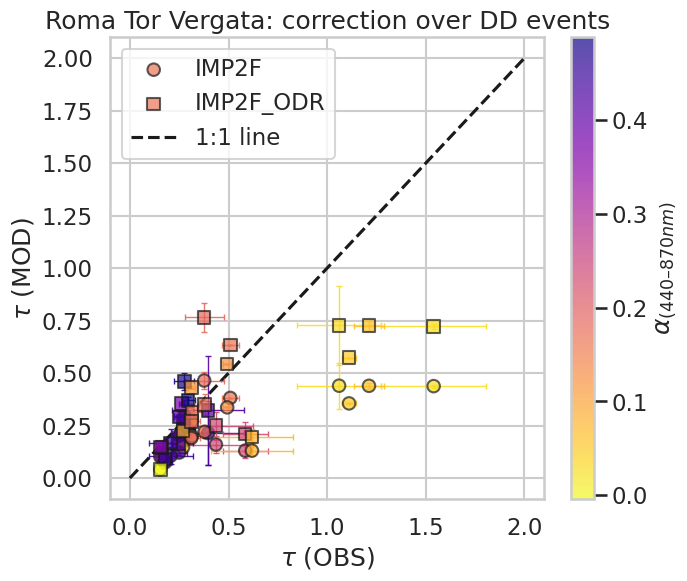

In [ ]:
df = dataframes['roma_tor_vergata_DD']
obs = df['LMP']
ang = df['ang_440_870']
preds = df[['IMP2F', 'IMP2F_ODR']]
err_x = df['err_day_new']
errs = df[['err_IMP2_24', 'err_IMP2_24_ODR']]
cmap = "plasma_r"

# Create figure and axis
fig, ax = plt.subplots(figsize=(7,6))

norm = plt.Normalize(vmin=ang.min(), vmax=ang.max())
colors = plt.colormaps.get_cmap(cmap)(norm(ang))

# Scatter plot for Model A
sc1 = ax.scatter(obs, preds.iloc[:, 0], c=ang, cmap=cmap, label='IMP2F', marker='o', edgecolor='k', zorder=3, alpha=0.7)
# Error bars for Model A
for k in range(len(df)):
        ax.errorbar(
            obs.iloc[k], preds.iloc[k, 0],
            xerr=err_x.iloc[k], yerr=errs.iloc[k, 0],
            fmt='o', markersize=1,
            markerfacecolor='none', markeredgecolor=colors[k],
            ecolor=colors[k], elinewidth=1, capsize=2, alpha=0.9
        )
# ax.errorbar(obs, preds.iloc[:, 0], xerr=err_x, yerr=errs.iloc[:, 0],
#             fmt='none', markeredgecolor=colors[0],
#             ecolor=colors[0], alpha=0.6, capsize=2, zorder=2)

# Scatter plot for Model B
sc2 = ax.scatter(obs, preds.iloc[:, 1], c=ang, cmap=cmap, label='IMP2F_ODR', marker='s', edgecolor='k', zorder=3, alpha=0.7)
# Error bars for Model B
for k in range(len(df)):
        ax.errorbar(
            obs.iloc[k], preds.iloc[k, 1],
            xerr=err_x.iloc[k], yerr=errs.iloc[k, 1],
            fmt='o', markersize=1,
            markerfacecolor='none', markeredgecolor=colors[k],
            ecolor=colors[k], elinewidth=1, capsize=2, alpha=0.9
        )
# ax.errorbar(obs, preds.iloc[:, 1], xerr=err_x, yerr=errs.iloc[:, 1],
#             fmt='none', markeredgecolor=colors[1],
#             ecolor=colors[1], alpha=0.6, capsize=2, zorder=2)

# Add 1:1 line
ax.plot([0, 2], [0, 2], 'k--', label='1:1 line', zorder=1)

# Colorbar (shared)
cbar = plt.colorbar(sc1, ax=ax)
cbar.set_label(r'$\alpha_{(440–870 nm)}$')

# Labels, legend, grid
ax.set_xlabel(r'$\tau$ (OBS)')
ax.set_ylabel(r'$\tau$ (MOD)')
ax.legend()
ax.grid(True)
ax.set_title('Roma Tor Vergata: correction over DD events')

plt.show()

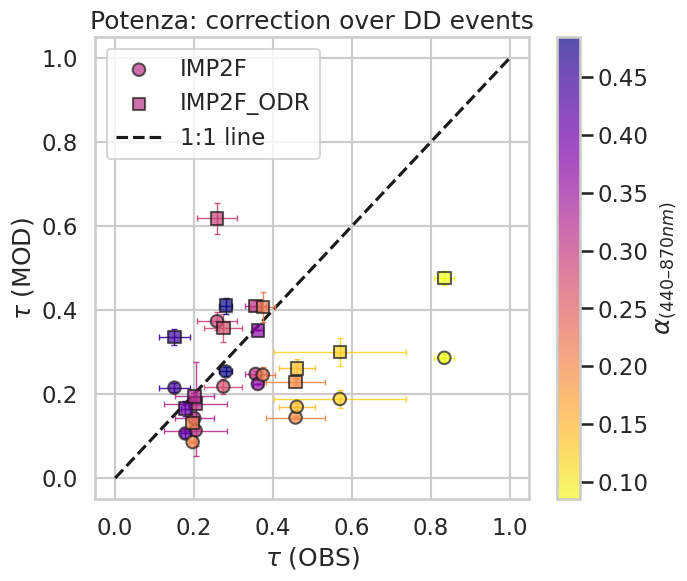

In [ ]:
df = dataframes['potenza_DD']
obs = df['LMP']
ang = df['ang_440_870']
preds = df[['IMP2F', 'IMP2F_ODR']]
err_x = df['err_day_new']
errs = df[['err_IMP2_24', 'err_IMP2_24_ODR']]
cmap = "plasma_r"

# Create figure and axis
fig, ax = plt.subplots(figsize=(7,6))

norm = plt.Normalize(vmin=ang.min(), vmax=ang.max())
colors = plt.colormaps.get_cmap(cmap)(norm(ang))

# Scatter plot for Model A
sc1 = ax.scatter(obs, preds.iloc[:, 0], c=ang, cmap=cmap, label='IMP2F', marker='o', edgecolor='k', zorder=3, alpha=0.7)
# Error bars for Model A
for k in range(len(df)):
        ax.errorbar(
            obs.iloc[k], preds.iloc[k, 0],
            xerr=err_x.iloc[k], yerr=errs.iloc[k, 0],
            fmt='o', markersize=1,
            markerfacecolor='none', markeredgecolor=colors[k],
            ecolor=colors[k], elinewidth=1, capsize=2, alpha=0.9
        )
# ax.errorbar(obs, preds.iloc[:, 0], xerr=err_x, yerr=errs.iloc[:, 0],
#             fmt='none', markeredgecolor=colors[0],
#             ecolor=colors[0], alpha=0.6, capsize=2, zorder=2)

# Scatter plot for Model B
sc2 = ax.scatter(obs, preds.iloc[:, 1], c=ang, cmap=cmap, label='IMP2F_ODR', marker='s', edgecolor='k', zorder=3, alpha=0.7)
# Error bars for Model B
for k in range(len(df)):
        ax.errorbar(
            obs.iloc[k], preds.iloc[k, 1],
            xerr=err_x.iloc[k], yerr=errs.iloc[k, 1],
            fmt='o', markersize=1,
            markerfacecolor='none', markeredgecolor=colors[k],
            ecolor=colors[k], elinewidth=1, capsize=2, alpha=0.9
        )
# ax.errorbar(obs, preds.iloc[:, 1], xerr=err_x, yerr=errs.iloc[:, 1],
#             fmt='none', markeredgecolor=colors[1],
#             ecolor=colors[1], alpha=0.6, capsize=2, zorder=2)

# Add 1:1 line
ax.plot([0, 1], [0, 1], 'k--', label='1:1 line', zorder=1)

# Colorbar (shared)
cbar = plt.colorbar(sc1, ax=ax)
cbar.set_label(r'$\alpha_{(440–870 nm)}$')

# Labels, legend, grid
ax.set_xlabel(r'$\tau$ (OBS)')
ax.set_ylabel(r'$\tau$ (MOD)')
ax.legend()
ax.grid(True)
ax.set_title('Potenza: correction over DD events')

plt.show()

# IMPROVE with coefficients for Lampedusa and Naples

In [ ]:
df_lm = dataframes['napoli_df']
df_np = pd.read_csv("/home/andrea/enea/lmp_dust_enea/DD_data_stations/napoli_new_df.csv")

obss = pd.concat([df_lm['IMP1F'], df_lm['IMP2F_ODR']], axis=1)
angs = pd.concat([df_lm['ang_440_870'], df_np['ang_440_870']], axis=1)
preds = pd.concat([df_np['IMP1F_ODR'], df_np['IMP2F_ODR']], axis=1)
# err_x = df['err_day_new']
# errs = df[['err_IMP2_24', 'err_IMP2_24_ODR']]
cmap = "plasma_r"

f, axs = plt.subplots(1, 2, figsize=(12, 8), constrained_layout=True, sharex=True, sharey=True)
axs = axs.flatten()
plt.suptitle("Lampedusa coeff. vs Napoli coeff.", fontsize=16, fontweight='bold', x=0.45, y=0.88)

# Normalize color scale for the angstrom values

#colors = plt.colormaps.get_cmap(cmap)(norm(ang))

for i, ax in enumerate(axs):
    pred = preds.iloc[:, i]
    obs = obss.iloc[:, i]
    ang = angs.iloc[:, i]
    # err_y = errs.iloc[:, i]
    norm = plt.Normalize(vmin=ang.min(), vmax=ang.max())
    # for k in range(len(df)):
    #     ax.errorbar(
    #         obs.iloc[k], pred.iloc[k],
    #         xerr=err_x.iloc[k], yerr=err_y.iloc[k],
    #         fmt='o', markersize=1,
    #         markerfacecolor='none', markeredgecolor=colors[k],
    #         ecolor=colors[k], elinewidth=1, capsize=2, alpha=0.9
    #     )
    
    sc = ax.scatter(obs, pred, c=ang, cmap=cmap, norm=norm, edgecolor='none', alpha=0.8)

    # n = len(df)
    # metrics = calculate_metrics(obs.values, pred.values, n)
    # bias, corr, rmse, var_y, mse, r2, adj_r2 = metrics

    # textstr = '\n'.join((
    #     f'Bias: {bias:.3f}',
    #     f'Corr: {corr:.3f}',
    #     f'RMSE: {rmse:.3f}',
    #     f'R²: {r2:.3f}'
    # ))

    # props = dict(boxstyle='round', facecolor='white', alpha=0.7, edgecolor='gray')
    # ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,
    #         verticalalignment='top', bbox=props)
    
    min_val = min(obs.min(), pred.min())
    max_val = max(obs.max(), pred.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', lw=1)
    ax.set_aspect('equal', adjustable='box')
    if i==0:
        ax.set_title("IMPROVE1F")
    else: 
        ax.set_title("IMPROVE2F")
    ax.set_xlabel(r"$\tau$ (Lampedusa coeff.)", fontsize=16)
    if i == 0:
        ax.set_ylabel(r"$\tau$ (Naples coeff.)", fontsize=16)
    ax.grid(True)

# Add colorbar
cbar = f.colorbar(sc, ax=axs, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label("Angström Exponent (440-870 nm)")

plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/home/andrea/enea_project/lmp_dust_enea/DD_data_stations/napoli_new_df.csv'

# **Potenza**

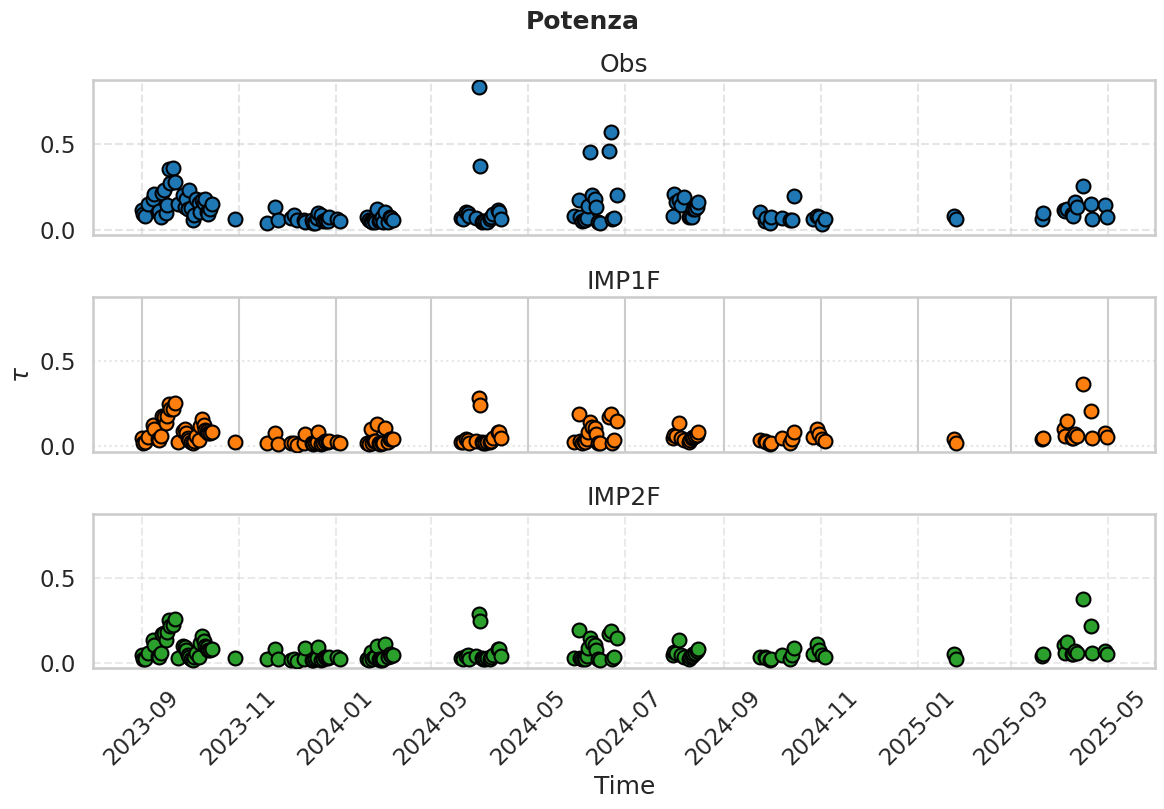

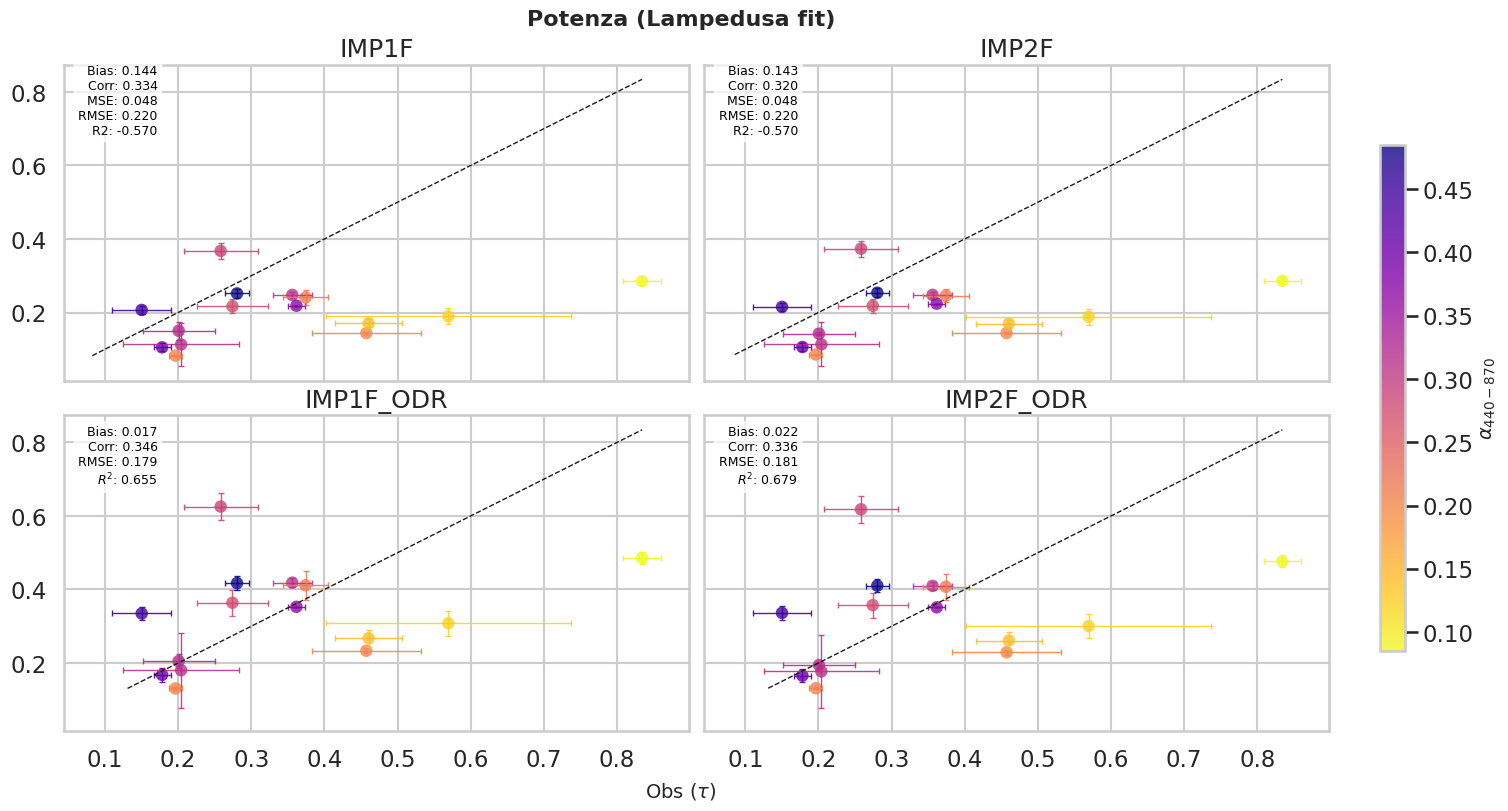

(array([0.45454301]),
 array([0.04957165]),
 array([ 0.08611971,  0.09338324,  0.12633502, -0.09283868,  0.07571226,
        -0.06368578,  0.02054381,  0.02523016, -0.03952901, -0.07044972,
         0.05123685, -0.00356894,  0.25616212,  0.14695999]),
 <Figure size 1200x800 with 2 Axes>)

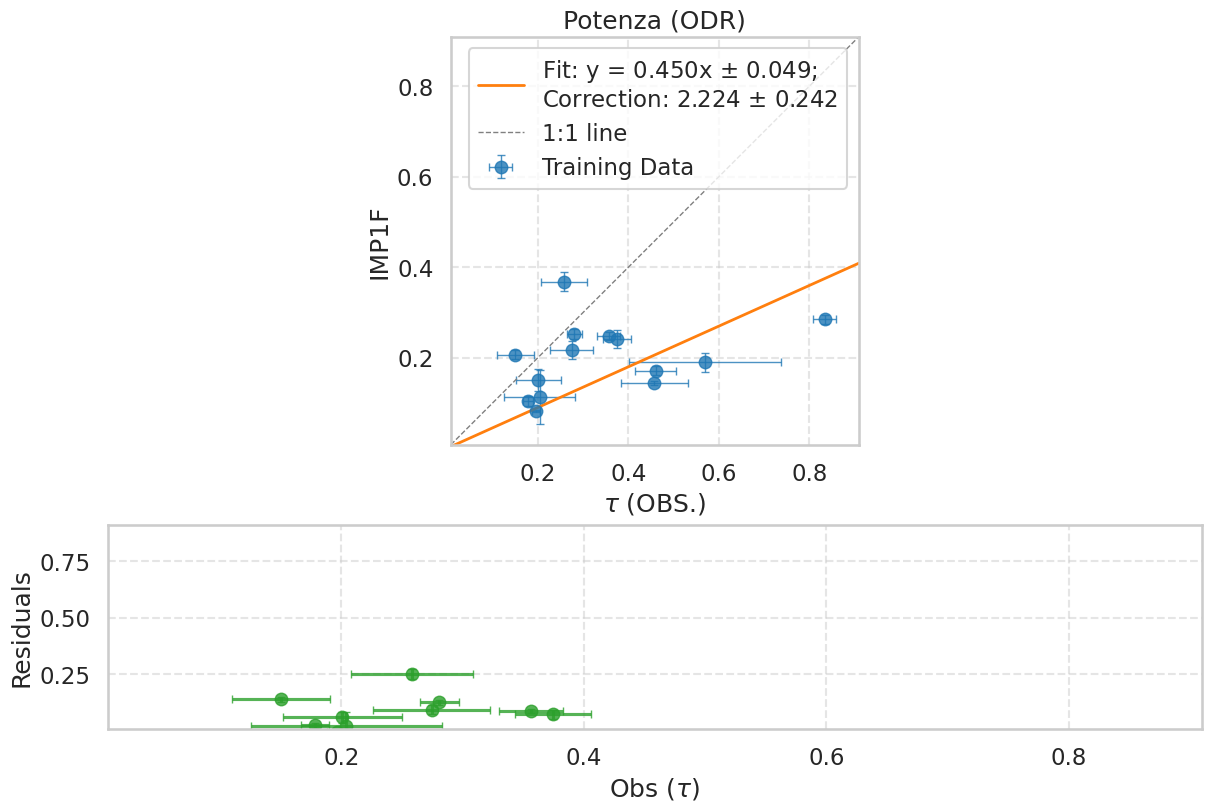

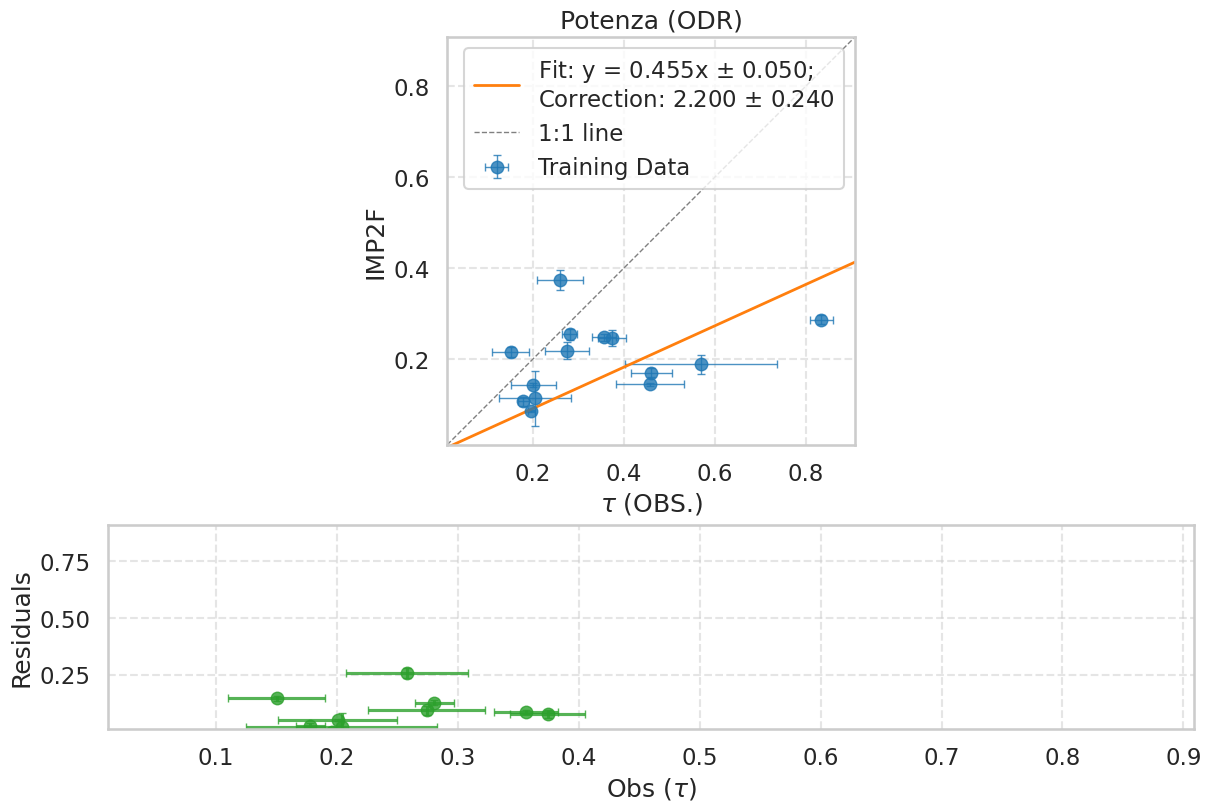

In [ ]:
dataframes['potenza_df']['time'] = pd.to_datetime(dataframes['potenza_df']['time'])
dataframes['potenza_DD_filtered']['time'] = pd.to_datetime(dataframes['potenza_DD_filtered']['time'])
t1_potenza = pd.to_datetime(dataframes['potenza_df']['time'].iloc[0])
t2_potenza = pd.to_datetime(pd.Timestamp("2024-08-31"))
t3_potenza = pd.to_datetime(dataframes['potenza_df']['time'].iloc[-1])

# DD events
import numpy as np

potenza_dd = dataframes['potenza_df'][(dataframes['potenza_df']['LMP'] >= 0.15) & (dataframes['potenza_df']['ang_440_870'] <= 0.5)]

pt_dd_trial = potenza_dd[(potenza_dd['time'] >= t1_potenza) & (potenza_dd['time'] <= t2_potenza)]
pt_dd_test = potenza_dd[(potenza_dd['time'] >= t2_potenza) & (potenza_dd['time'] <= t3_potenza)]

pt_dd_trial_f = dataframes['potenza_DD_filtered'][(dataframes['potenza_DD_filtered']['time'] >= t1_potenza) & (dataframes['potenza_DD_filtered']['time'] <= t2_potenza)]
pt_dd_test_f = dataframes['potenza_DD_filtered'][(dataframes['potenza_DD_filtered']['time'] >= t2_potenza) & (dataframes['potenza_DD_filtered']['time'] <= t3_potenza)]

# # filtering daylight hours
# city = LocationInfo("Lampedusa", "Italy", "Europe/Rome", 40.6, 15.7)  # Use your location
# tz = pytz.timezone(city.timezone)
# pt_dd_trial = pt_dd_trial.copy()
# pt_dd_trial['time'] = pd.to_datetime(pt_dd_trial['time'])
# # Apply to DataFrame
# pt_dd_trial['max_daylight_hours'] = pt_dd_trial.apply(lambda row: compute_max_daylight(city, row), axis=1)
# pt_dd_trial_filtered = pt_dd_trial[pt_dd_trial['n'] > 0.5 * pt_dd_trial['max_daylight_hours']]

k = 2

mean_obs = np.mean(dataframes['potenza_DD_filtered']['LMP'])
std_obs = np.std(dataframes['potenza_DD_filtered']['LMP'])

mean_obs_1 = np.mean(dataframes['potenza_DD_filtered']['IMP1F'])
std_obs_1 = np.std(dataframes['potenza_DD_filtered']['IMP1F'])

mean_obs_2 = np.mean(dataframes['potenza_DD_filtered']['IMP2F'])
std_obs_2 = np.std(dataframes['potenza_DD_filtered']['IMP2F'])

pt_dd_trial_f = dataframes["potenza_DD_filtered"][(dataframes["potenza_DD_filtered"]['time'] >= t1_potenza) & (dataframes["potenza_DD_filtered"]['time'] <= t2_potenza)]
pt_trial_prova = pt_dd_trial_f[(pt_dd_trial_f['LMP'] >= 0.35) & (pt_dd_trial_f['ang_440_870'] <= 0.3) & (np.abs(pt_dd_trial_f['IMP1F']-mean_obs_1) <= k * std_obs_1) &
                               (np.abs(pt_dd_trial_f['IMP2F']-mean_obs_2) <= k * std_obs_2) & (np.abs(pt_dd_trial_f['LMP']-mean_obs) <= k * std_obs)]

# df_pesi = dataframes['potenza_DD_filtered'].copy()
# df_pesi['pesi_obs'] = np.power(dataframes['potenza_DD_filtered']['LMP'], 2)/(np.power(dataframes['potenza_DD_filtered']['err_day_new'], 2))
# df_pesi['pesi_imp1'] = np.power(dataframes['potenza_DD_filtered']['IMP1F'], 2)/(np.power(dataframes['potenza_DD_filtered']['err_IMP1_24'], 2))
# df_pesi['pesi_imp2'] = np.power(dataframes['potenza_DD_filtered']['IMP2F'], 2)/(np.power(dataframes['potenza_DD_filtered']['err_IMP2_24'], 2))

# mean_pesi_obs = np.mean(df_pesi['pesi_obs'])
# std_pesi_obs = np.std(df_pesi['pesi_obs'])

# mean_pesi_imp1 = np.mean(df_pesi['pesi_imp1']) 
# std_pesi_imp1 = np.std(df_pesi['pesi_imp1'])

# mean_pesi_imp2 = np.mean(df_pesi['pesi_imp2']) 
# std_pesi_imp2 = np.std(df_pesi['pesi_imp2'])

# prova = df_pesi[(np.abs(df_pesi['pesi_obs'] - mean_pesi_obs) <= 2 * std_pesi_obs) & (np.abs(df_pesi['pesi_imp1'] - mean_pesi_imp1) <= 2 * std_pesi_imp1) & (np.abs(df_pesi['pesi_imp2'] - mean_pesi_imp2) <= 2 * std_pesi_imp2)]

# plt.hist(df_pesi["pesi_obs"], bins=20, color='skyblue', edgecolor='black')
# plt.hist(df_pesi['pesi_imp1'], bins=20, color='green', edgecolor='black')
# plt.hist(df_pesi['pesi_imp2'], bins=20, color='red', edgecolor='black')
# plt.xlabel("Valori")
# plt.ylabel("Frequenza")
# plt.title("Distribuzione dei pesi (OBS)")
# plt.grid(True)
# plt.show()

# Set seaborn style
sns.set(style="whitegrid", context="talk")

# Set up subplots
fig, axs = plt.subplots(3, 1, figsize=(12, 8), sharex=True, sharey=True)
df = dataframes['potenza_df']

# Fancy line plot with smoothing (rolling mean)
axs[0].scatter(df['time'], df['LMP'], label='obs', color='#1f77b4', edgecolor='black', s=100, zorder=3)
# axs[0].set_ylabel(r'${\tau}$')
axs[0].set_title('Obs')
#axs[0].legend(loc='upper left')
axs[0].grid(True, linestyle='--', alpha=0.5)

# Fancy bar plot
axs[1].scatter(df['time'], df['IMP1F'], color='#ff7f0e', edgecolor='black', zorder=3, s=100)
axs[1].set_ylabel(r'${\tau}$')
axs[1].set_title('IMP1F')
axs[1].grid(True, axis='y', linestyle=':', alpha=0.5)

# Fancy scatter plot with annotations
axs[2].scatter(df['time'], df['IMP2F'], s=100, color='#2ca02c', edgecolor='black', zorder=3)
# axs[2].set_ylabel('obs3')
axs[2].set_title('IMP2F')

axs[2].set_xlabel('Time')
axs[2].grid(True, linestyle='--', alpha=0.4)

# Beautify x-axis
plt.xticks(rotation=45)
plt.tight_layout()
plt.suptitle("Potenza", fontsize=18, y=1.02, fontweight='bold')
plt.subplots_adjust(hspace=0.4)

plt.savefig("/home/andrea/enea/lmp_dust_enea/figure/potenza/pt_time.png", format='png', dpi=300, bbox_inches='tight')
plt.show()


plot_scatter(
    dataframes['potenza_DD'],
    ['LMP', 'IMP1F', 'IMP2F', 'IMP1F_ODR', 'IMP2F_ODR', 'ang_440_870',
     'err_day_new', 'err_IMP1_24', 'err_IMP2_24', 'err_IMP1_24_ODR', 'err_IMP2_24_ODR'],
    cmap='plasma_r',
    stats=True,
    name="Potenza (Lampedusa fit)",
    save=True,
    path="/home/andrea/enea/lmp_dust_enea/figure/potenza/pt_DD_lm_fit.png")

odr_linear_fit_plot(dataframes['potenza_DD'], "LMP", "IMP1F", "err_day_new", "err_IMP1_24", "Potenza (ODR)", 
                    save=True, 
                    path="/home/andrea/enea/lmp_dust_enea/figure/potenza/pt_DD_no_f_fit_IMP1.png")
odr_linear_fit_plot(dataframes['potenza_DD'], "LMP", "IMP2F", "err_day_new", "err_IMP2_24", "Potenza (ODR)",
                    save=True,
                    path="/home/andrea/enea/lmp_dust_enea/figure/potenza/pt_DD_no_f_fit_IMP2.png")

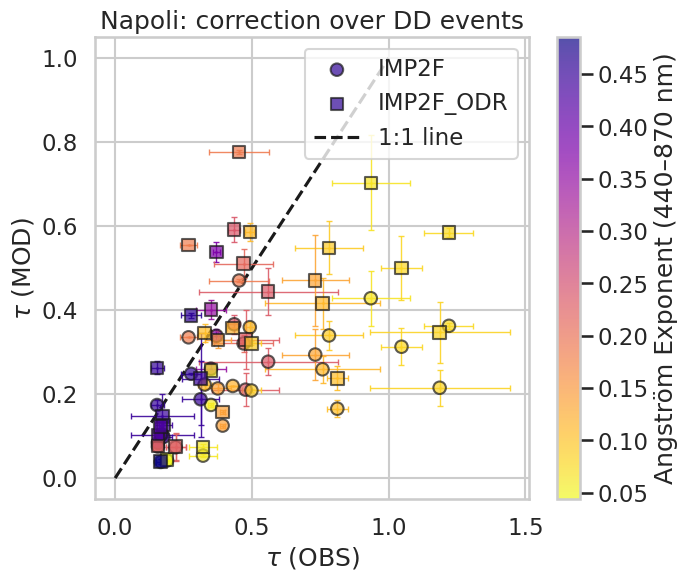

In [ ]:
df = dataframes['napoli_DD']
obs = df['LMP']
ang = df['ang_440_870']
preds = df[['IMP2F', 'IMP2F_ODR']]
err_x = df['err_day_new']
errs = df[['err_IMP2_24', 'err_IMP2_24_ODR']]
cmap = "plasma_r"

# Create figure and axis
fig, ax = plt.subplots(figsize=(7,6))

norm = plt.Normalize(vmin=ang.min(), vmax=ang.max())
colors = plt.colormaps.get_cmap(cmap)(norm(ang))

# Scatter plot for Model A
sc1 = ax.scatter(obs, preds.iloc[:, 0], c=ang, cmap=cmap, label='IMP2F', marker='o', edgecolor='k', zorder=3, alpha=0.7)
# Error bars for Model A
for k in range(len(df)):
        ax.errorbar(
            obs.iloc[k], preds.iloc[k, 0],
            xerr=err_x.iloc[k], yerr=errs.iloc[k, 0],
            fmt='o', markersize=1,
            markerfacecolor='none', markeredgecolor=colors[k],
            ecolor=colors[k], elinewidth=1, capsize=2, alpha=0.9
        )
# ax.errorbar(obs, preds.iloc[:, 0], xerr=err_x, yerr=errs.iloc[:, 0],
#             fmt='none', markeredgecolor=colors[0],
#             ecolor=colors[0], alpha=0.6, capsize=2, zorder=2)

# Scatter plot for Model B
sc2 = ax.scatter(obs, preds.iloc[:, 1], c=ang, cmap=cmap, label='IMP2F_ODR', marker='s', edgecolor='k', zorder=3, alpha=0.7)
# Error bars for Model B
for k in range(len(df)):
        ax.errorbar(
            obs.iloc[k], preds.iloc[k, 1],
            xerr=err_x.iloc[k], yerr=errs.iloc[k, 1],
            fmt='o', markersize=1,
            markerfacecolor='none', markeredgecolor=colors[k],
            ecolor=colors[k], elinewidth=1, capsize=2, alpha=0.9
        )
# ax.errorbar(obs, preds.iloc[:, 1], xerr=err_x, yerr=errs.iloc[:, 1],
#             fmt='none', markeredgecolor=colors[1],
#             ecolor=colors[1], alpha=0.6, capsize=2, zorder=2)

# Add 1:1 line
ax.plot([0, 1], [0, 1], 'k--', label='1:1 line', zorder=1)

# Colorbar (shared)
cbar = plt.colorbar(sc1, ax=ax)
cbar.set_label('Angström Exponent (440–870 nm)')

# Labels, legend, grid
ax.set_xlabel(r'$\tau$ (OBS)')
ax.set_ylabel(r'$\tau$ (MOD)')
ax.legend()
ax.grid(True)
ax.set_title('Napoli: correction over DD events')

plt.show()

# **Roma La Sapienza**

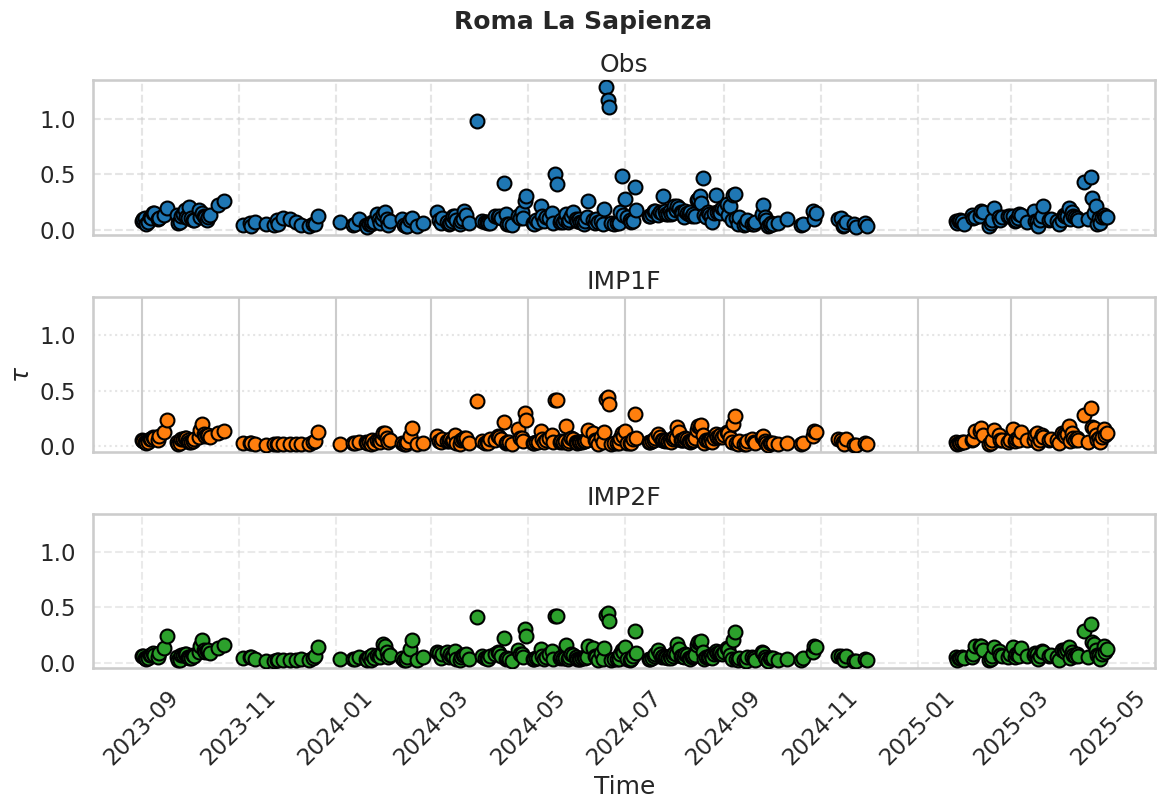

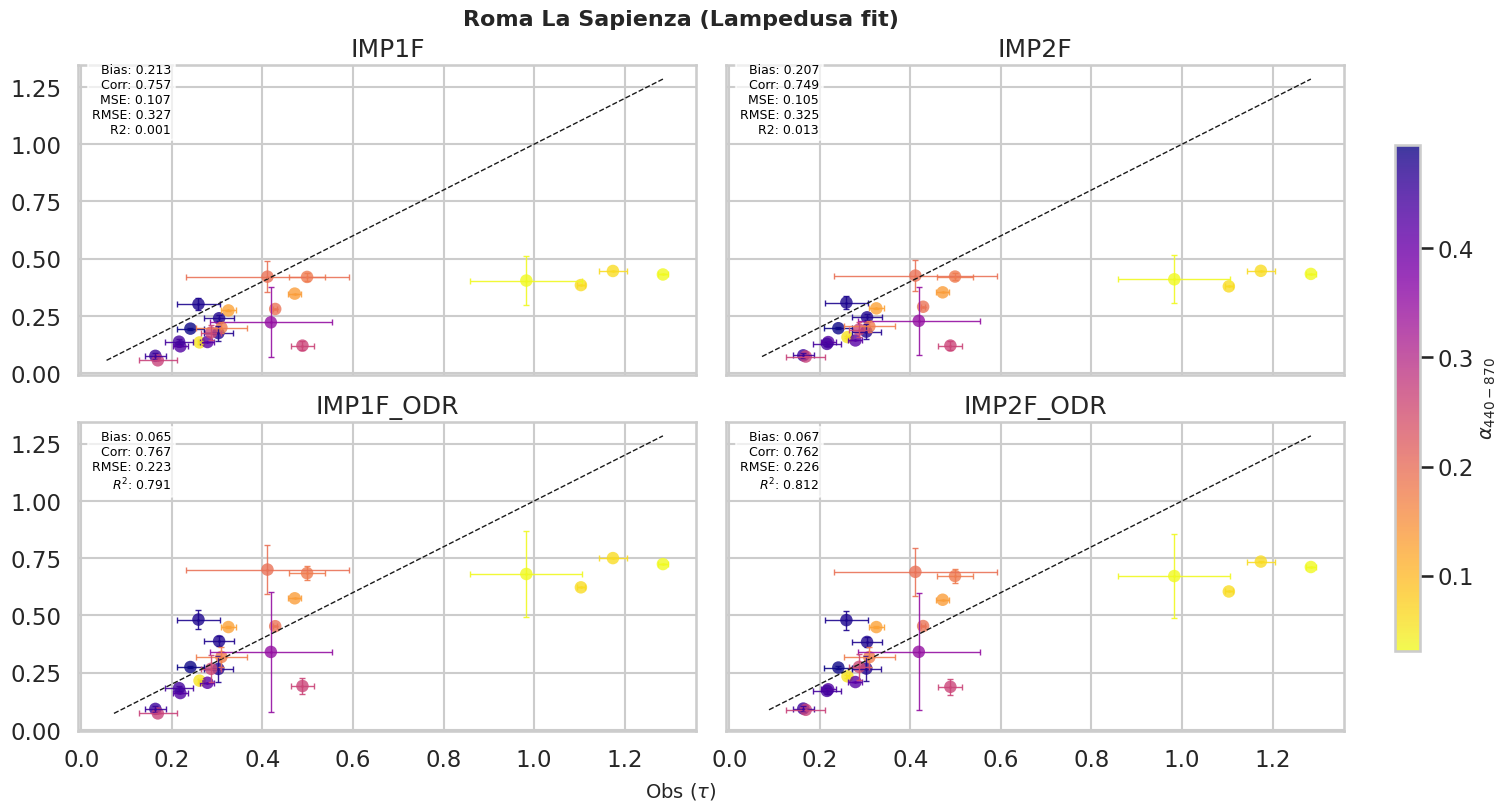

(array([0.3859704]),
 array([0.02093231]),
 array([ 0.03049542,  0.22936458,  0.26738822, -0.00628422, -0.06813069]),
 <Figure size 1200x800 with 2 Axes>)

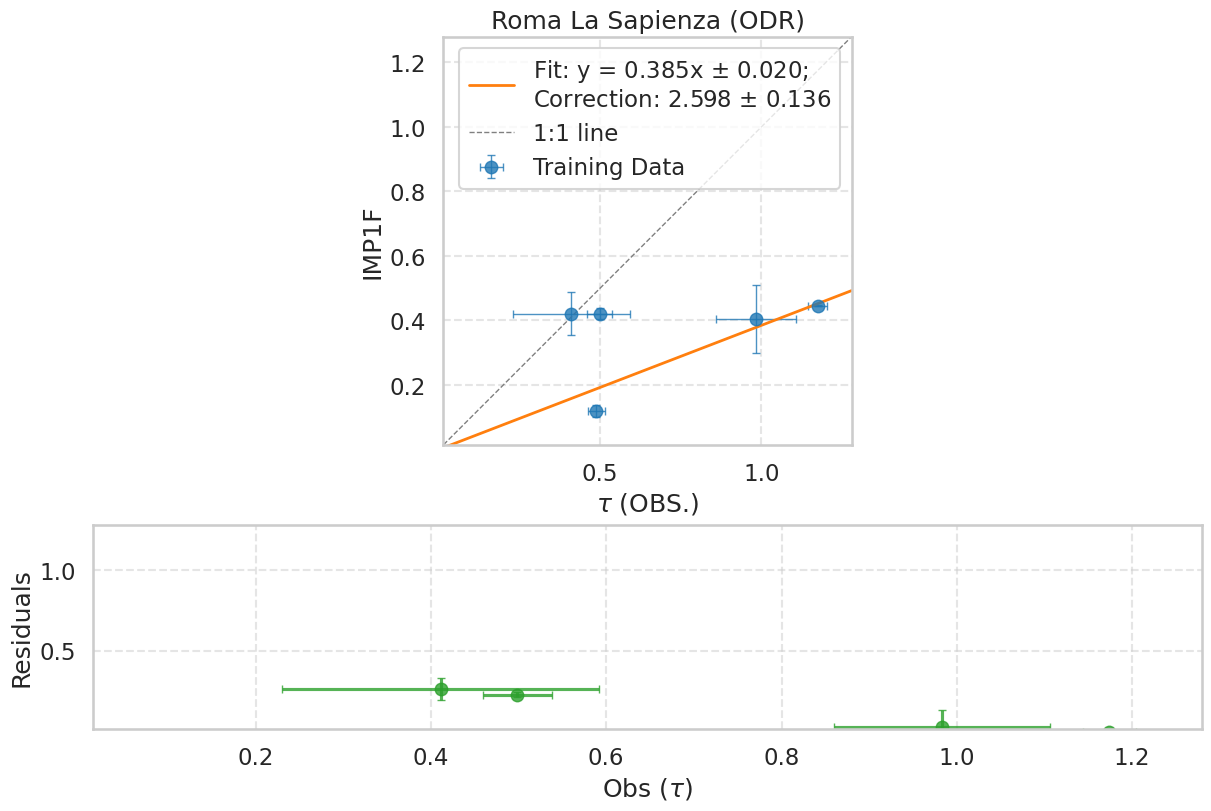

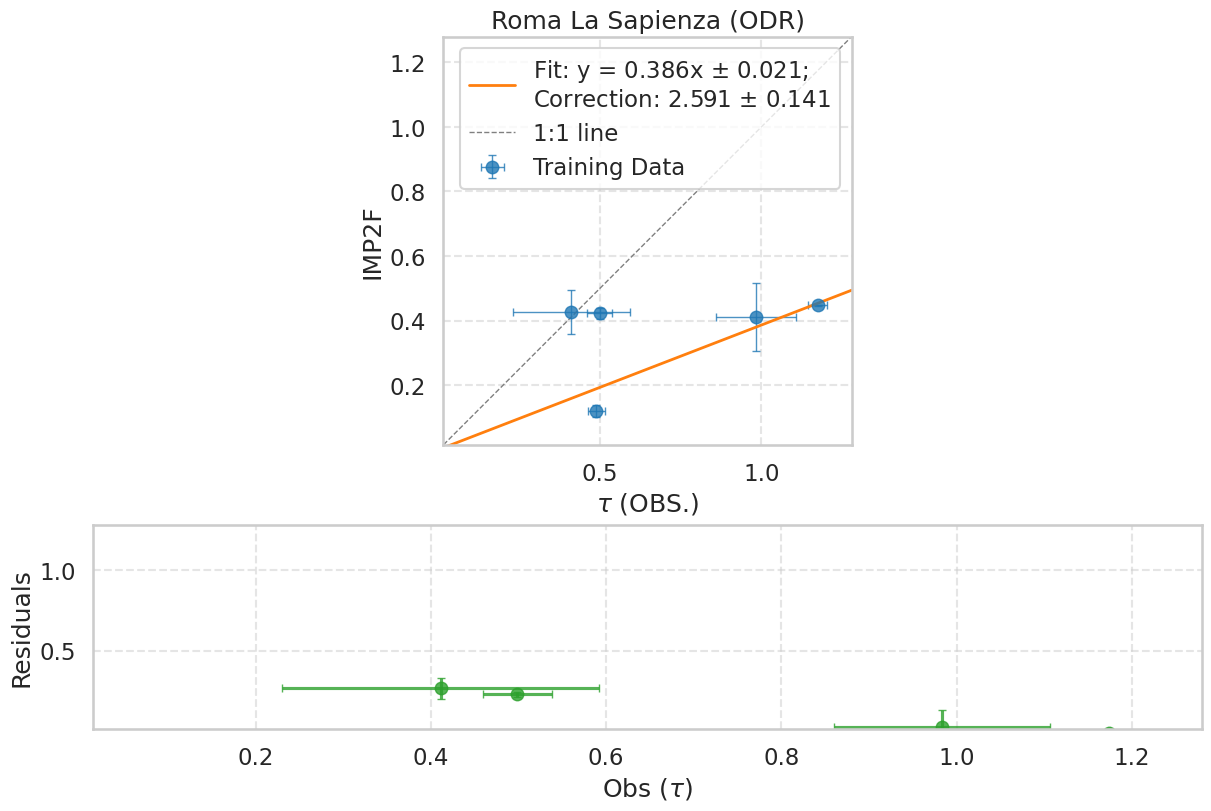

In [ ]:
dataframes['roma_la_sapienza_df']['time'] = pd.to_datetime(dataframes['roma_la_sapienza_df']['time'])
dataframes['roma_la_sapienza_DD_filtered']['time'] = pd.to_datetime(dataframes['roma_la_sapienza_DD_filtered']['time'])
t1_roma_la_sapienza = pd.to_datetime(dataframes['roma_la_sapienza_df']['time'].iloc[0])
t2_roma_la_sapienza = pd.to_datetime(pd.Timestamp("2024-08-31"))
t3_roma_la_sapienza = pd.to_datetime(dataframes['roma_la_sapienza_df']['time'].iloc[-1])

# DD events
import numpy as np
roma_la_sapienza_dd = dataframes['roma_la_sapienza_df'][(dataframes['roma_la_sapienza_df']['LMP'] >= 0.35) & (dataframes['roma_la_sapienza_df']['ang_440_870'] <= 0.3)]
rls_dd_trial = roma_la_sapienza_dd[(roma_la_sapienza_dd['time'] >= t1_roma_la_sapienza) & (roma_la_sapienza_dd['time'] <= t2_roma_la_sapienza)]
rls_dd_test = roma_la_sapienza_dd[(roma_la_sapienza_dd['time'] >= t2_roma_la_sapienza) & (roma_la_sapienza_dd['time'] <= t3_roma_la_sapienza)]

rls_dd_trial_f = dataframes['roma_la_sapienza_DD_filtered'][(dataframes['roma_la_sapienza_DD_filtered']['time'] >= t1_roma_la_sapienza) & (dataframes['roma_la_sapienza_DD_filtered']['time'] <= t2_roma_la_sapienza)]
rls_dd_test_f = dataframes['roma_la_sapienza_DD_filtered'][(dataframes['roma_la_sapienza_DD_filtered']['time'] >= t2_roma_la_sapienza) & (dataframes['roma_la_sapienza_DD_filtered']['time'] <= t3_roma_la_sapienza)]

k = 2

mean_obs = np.mean(dataframes['roma_la_sapienza_DD_filtered']['LMP'])
std_obs = np.std(dataframes['roma_la_sapienza_DD_filtered']['LMP'])

mean_obs_1 = np.mean(dataframes['roma_la_sapienza_DD_filtered']['IMP1F'])
std_obs_1 = np.std(dataframes['roma_la_sapienza_DD_filtered']['IMP1F'])

mean_obs_2 = np.mean(dataframes['roma_la_sapienza_DD_filtered']['IMP2F'])
std_obs_2 = np.std(dataframes['roma_la_sapienza_DD_filtered']['IMP2F'])

rls_dd_trial_f = dataframes["roma_la_sapienza_DD_filtered"][(dataframes["roma_la_sapienza_DD_filtered"]['time'] >= t1_roma_la_sapienza) & (dataframes["roma_la_sapienza_DD_filtered"]['time'] <= t2_roma_la_sapienza)]
rls_trial_prova = rls_dd_trial_f[(rls_dd_trial_f['LMP'] >= 0.35) & (rls_dd_trial_f['ang_440_870'] <= 0.3) & (np.abs(rls_dd_trial_f['IMP1F']-mean_obs_1) <= k * std_obs_1) &
                               (np.abs(rls_dd_trial_f['IMP2F']-mean_obs_2) <= k * std_obs_2) & (np.abs(rls_dd_trial_f['LMP']-mean_obs) <= k * std_obs)]

# # filtering daylight hours
# city = LocationInfo("Lampedusa", "Italy", "Europe/Rome", 41.9, 12.5)  # Use your location
# tz = pytz.timezone(city.timezone)
# rls_dd_trial = rls_dd_trial.copy()
# rls_dd_trial['time'] = pd.to_datetime(rls_dd_trial['time'])
# # Apply to DataFrame
# rls_dd_trial['max_daylight_hours'] = rls_dd_trial.apply(lambda row: compute_max_daylight(city, row), axis=1)
# rls_dd_trial_filtered = rls_dd_trial[rls_dd_trial['n'] > 0.5 * rls_dd_trial['max_daylight_hours']]

# df_pesi = dataframes['roma_la_sapienza_DD_filtered'].copy()
# df_pesi['pesi_obs'] = np.power(dataframes['roma_la_sapienza_DD_filtered']['LMP'], 2)/(np.power(dataframes['roma_la_sapienza_DD_filtered']['err_day_new'], 2))
# df_pesi['pesi_imp1'] = np.power(dataframes['roma_la_sapienza_DD_filtered']['IMP1F'], 2)/(np.power(dataframes['roma_la_sapienza_DD_filtered']['err_IMP1_24'], 2))
# df_pesi['pesi_imp2'] = np.power(dataframes['roma_la_sapienza_DD_filtered']['IMP2F'], 2)/(np.power(dataframes['roma_la_sapienza_DD_filtered']['err_IMP2_24'], 2))

# mean_pesi_obs = np.mean(df_pesi['pesi_obs'])
# std_pesi_obs = np.std(df_pesi['pesi_obs'])

# mean_pesi_imp1 = np.mean(df_pesi['pesi_imp1']) 
# std_pesi_imp1 = np.std(df_pesi['pesi_imp1'])

# mean_pesi_imp2 = np.mean(df_pesi['pesi_imp2']) 
# std_pesi_imp2 = np.std(df_pesi['pesi_imp2'])

# prova = df_pesi[(np.abs(df_pesi['pesi_obs'] - mean_pesi_obs) <= 2 * std_pesi_obs) & (np.abs(df_pesi['pesi_imp1'] - mean_pesi_imp1) <= 2 * std_pesi_imp1) & (np.abs(df_pesi['pesi_imp2'] - mean_pesi_imp2) <= 2 * std_pesi_imp2)]

# plt.hist(df_pesi["pesi_obs"], bins=30, color='skyblue', edgecolor='black')
# plt.hist(df_pesi['pesi_imp1'], bins=30, color='green', edgecolor='black')
# plt.hist(df_pesi['pesi_imp2'], bins=30, color='red', edgecolor='black')
# plt.xlabel("Valori")
# plt.ylabel("Frequenza")
# plt.title("Distribuzione dei pesi (OBS)")
# plt.grid(True)
# plt.show()

# Set seaborn style
sns.set(style="whitegrid", context="talk")

# Set up subplots
fig, axs = plt.subplots(3, 1, figsize=(12, 8), sharex=True, sharey=True)
df = dataframes['roma_la_sapienza_df']

# Fancy line plot with smoothing (rolling mean)
axs[0].scatter(df['time'], df['LMP'], label='obs', color='#1f77b4', edgecolor='black', s=100, zorder=3)
# axs[0].set_ylabel(r'${\tau}$')
axs[0].set_title('Obs')
#axs[0].legend(loc='upper left')
axs[0].grid(True, linestyle='--', alpha=0.5)

# Fancy bar plot
axs[1].scatter(df['time'], df['IMP1F'], color='#ff7f0e', edgecolor='black', zorder=3, s=100)
axs[1].set_ylabel(r'${\tau}$')
axs[1].set_title('IMP1F')
axs[1].grid(True, axis='y', linestyle=':', alpha=0.5)

# Fancy scatter plot with annotations
axs[2].scatter(df['time'], df['IMP2F'], s=100, color='#2ca02c', edgecolor='black', zorder=3)
# axs[2].set_ylabel('obs3')
axs[2].set_title('IMP2F')

axs[2].set_xlabel('Time')
axs[2].grid(True, linestyle='--', alpha=0.4)

# Beautify x-axis
plt.xticks(rotation=45)
plt.tight_layout()
plt.suptitle("Roma La Sapienza", fontsize=18, y=1.02, fontweight='bold')
plt.subplots_adjust(hspace=0.4)

plt.savefig("/home/andrea/enea/lmp_dust_enea/figure/roma/rls_time.png", format='png', dpi=300, bbox_inches='tight')
plt.show()


plot_scatter(
    dataframes['roma_la_sapienza_DD'],
    ['LMP', 'IMP1F', 'IMP2F', 'IMP1F_ODR', 'IMP2F_ODR', 'ang_440_870', 'err_day_new', 'err_IMP1_24', 'err_IMP2_24',
     'err_IMP1_24_ODR', 'err_IMP2_24_ODR'],
    cmap='plasma_r',
    stats=True,
    name="Roma La Sapienza (Lampedusa fit)",
    save=True,
    path="/home/andrea/enea/lmp_dust_enea/figure/roma/rls_DD_lm_fit.png")

odr_linear_fit_plot(roma_la_sapienza_dd, "LMP", "IMP1F", "err_day_new", "err_IMP1_24", "Roma La Sapienza (ODR)", 
                    save=True, path="/home/andrea/enea/lmp_dust_enea/figure/roma/rls_DD_fit_IMP1.png")
odr_linear_fit_plot(roma_la_sapienza_dd, "LMP", "IMP2F", "err_day_new", "err_IMP2_24", "Roma La Sapienza (ODR)", 
                    save=True, path="/home/andrea/enea/lmp_dust_enea/figure/roma/rls_DD_fit_IMP2.png")

# **Roma Tor Vergata**

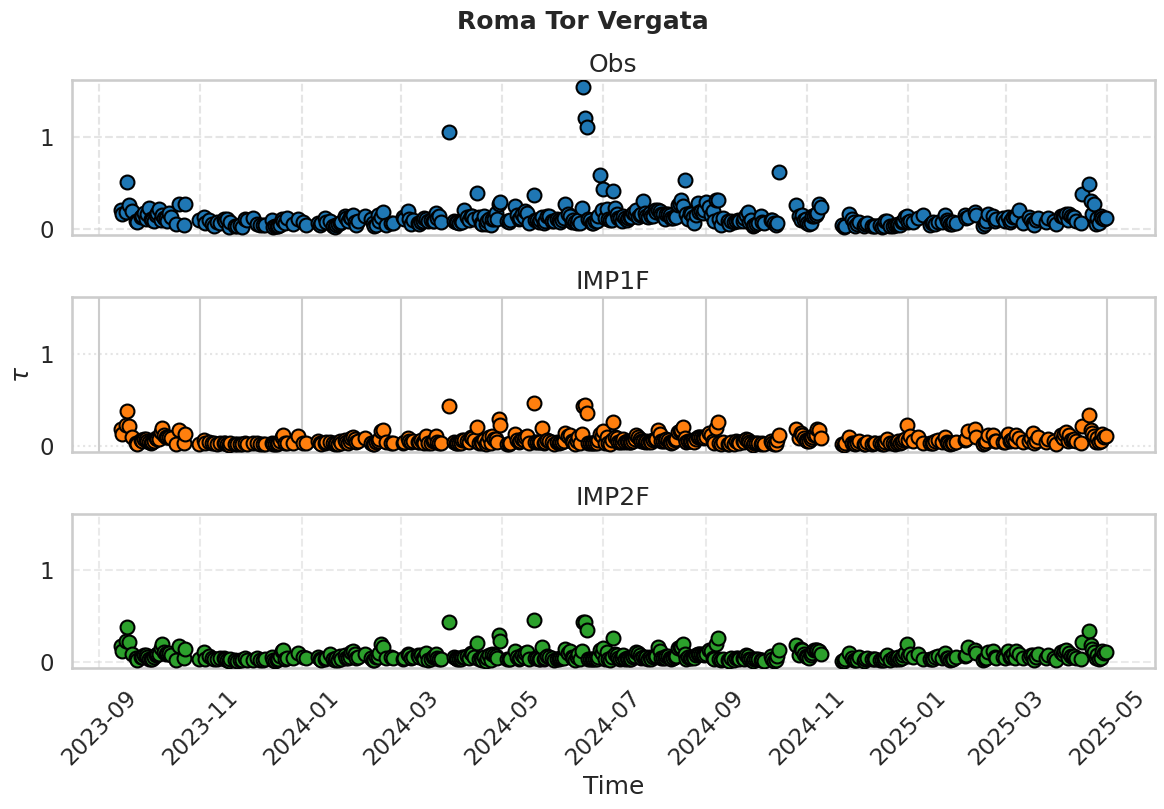

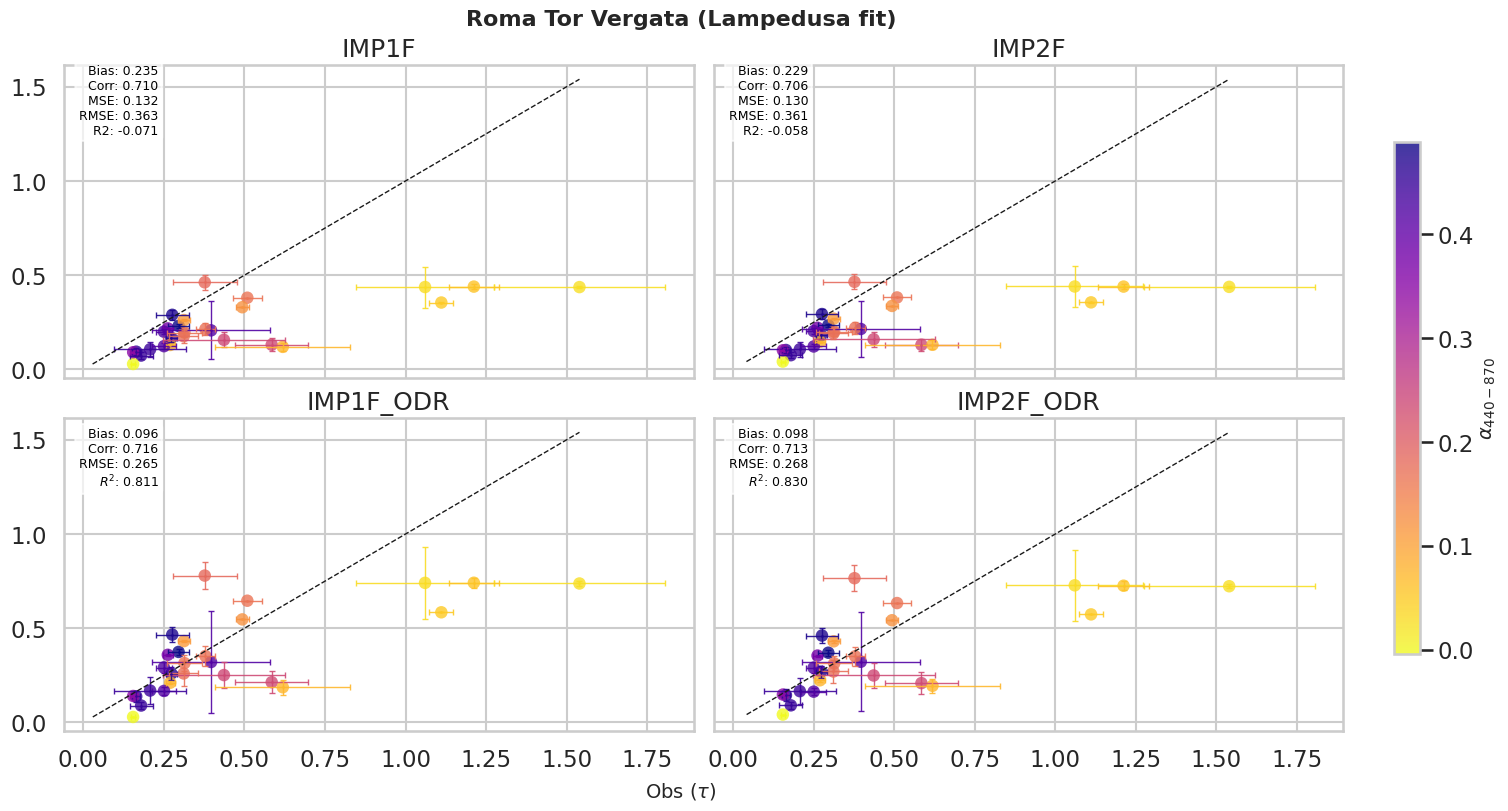

(array([0.7191072]),
 array([0.09432396]),
 array([-0.0150363 , -0.07054138, -0.05355516,  0.09536199,  0.02143261,
        -0.28995294, -0.04227571]),
 <Figure size 1200x800 with 2 Axes>)

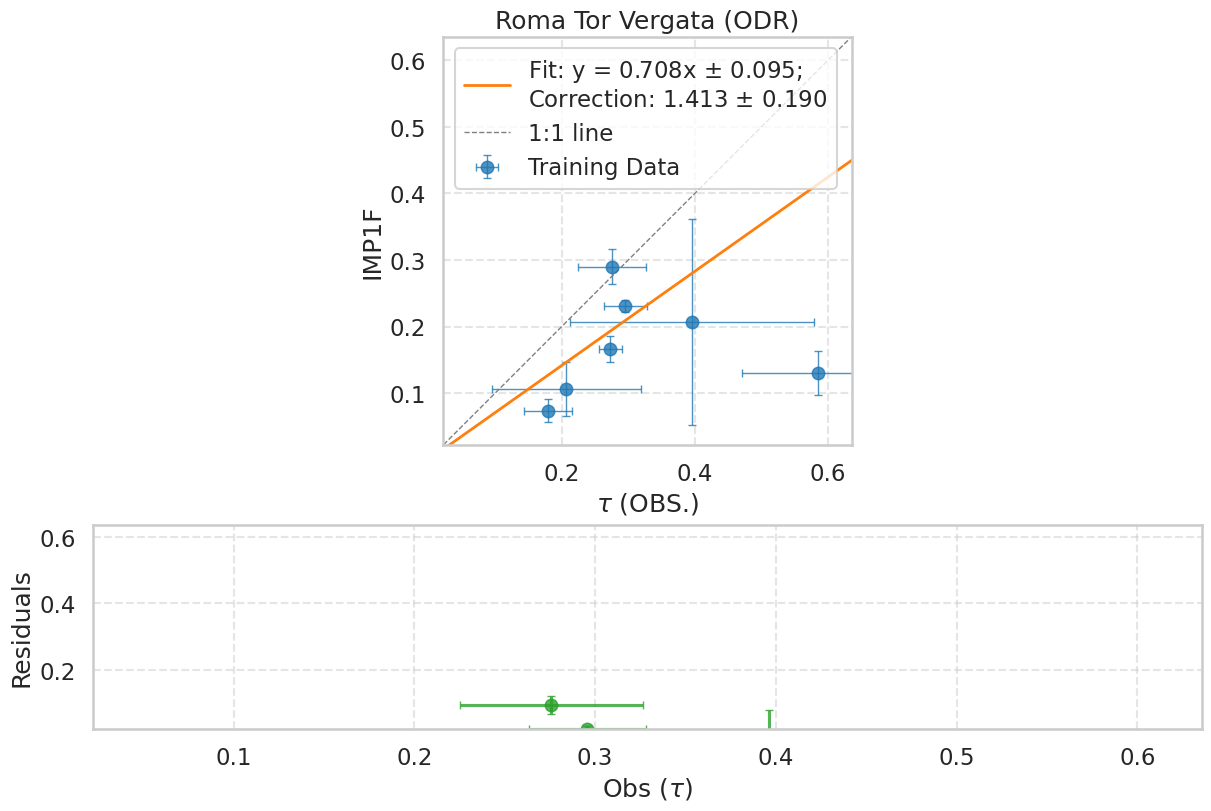

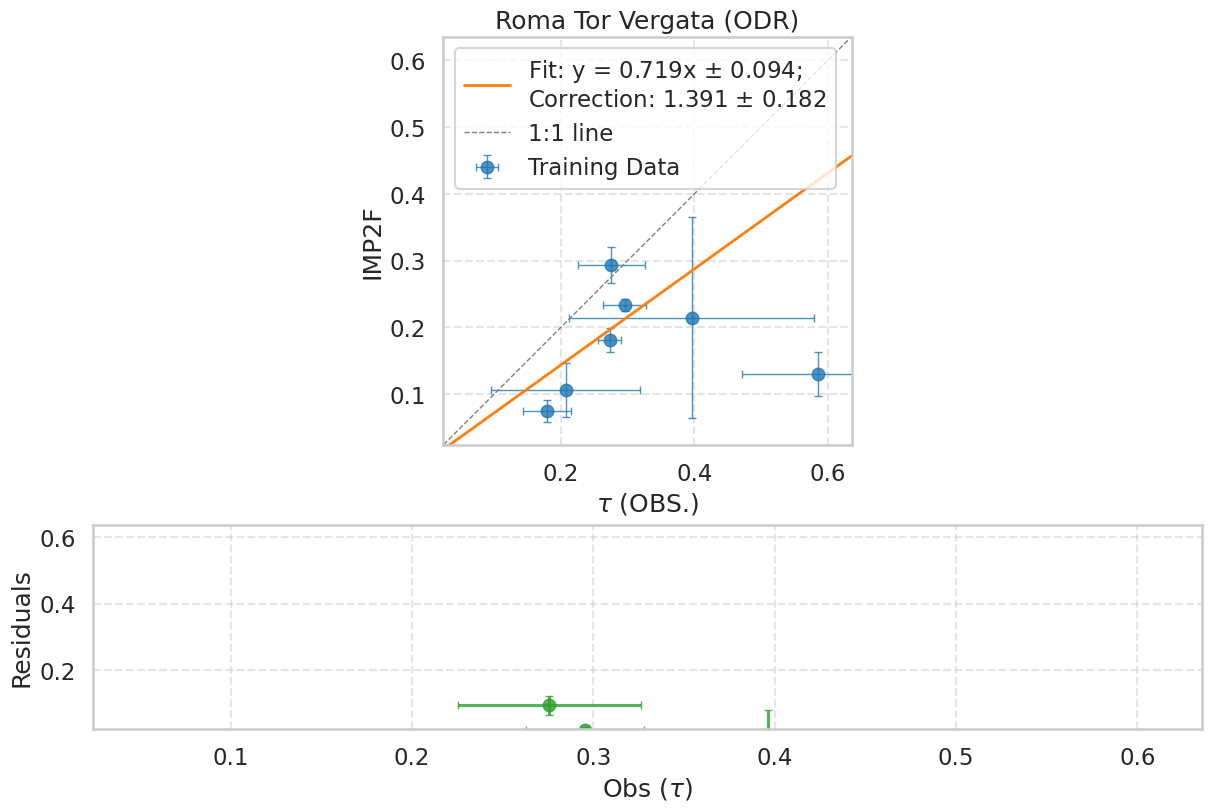

In [ ]:
dataframes['roma_tor_vergata_df']['time'] = pd.to_datetime(dataframes['roma_tor_vergata_df']['time'])
dataframes['roma_tor_vergata_DD_filtered']['time'] = pd.to_datetime(dataframes['roma_tor_vergata_DD_filtered']['time'])
t1_roma_tor_vergata = pd.to_datetime(dataframes['roma_tor_vergata_df']['time'].iloc[0])
t2_roma_tor_vergata = pd.to_datetime(pd.Timestamp("2024-08-31"))
t3_roma_tor_vergata = pd.to_datetime(dataframes['roma_tor_vergata_df']['time'].iloc[-1])

# DD events
import numpy as np

roma_tor_vergata_dd = dataframes['roma_tor_vergata_df'][(dataframes['roma_tor_vergata_df']['LMP'] >= 0.15) & (dataframes['roma_tor_vergata_df']['ang_440_870'] <= 0.5)]
rtv_dd_trial = roma_tor_vergata_dd[(roma_tor_vergata_dd['time'] >= t1_roma_tor_vergata) & (roma_tor_vergata_dd['time'] <= t2_roma_tor_vergata)]
rtv_dd_test = roma_tor_vergata_dd[(roma_tor_vergata_dd['time'] >= t2_roma_tor_vergata) & (roma_tor_vergata_dd['time'] <= t3_roma_tor_vergata)]

rtv_dd_trial_f = dataframes['roma_tor_vergata_DD_filtered'][(dataframes['roma_tor_vergata_DD_filtered']['time'] >= t1_roma_tor_vergata) & (dataframes['roma_tor_vergata_DD_filtered']['time'] <= t2_roma_tor_vergata)]
rtv_dd_test_f = dataframes['roma_tor_vergata_DD_filtered'][(dataframes['roma_tor_vergata_DD_filtered']['time'] >= t2_roma_tor_vergata) & (dataframes['roma_tor_vergata_DD_filtered']['time'] <= t3_roma_tor_vergata)]

k = 2

mean_obs = np.mean(dataframes['roma_tor_vergata_DD_filtered']['LMP'])
std_obs = np.std(dataframes['roma_tor_vergata_DD_filtered']['LMP'])

mean_obs_1 = np.mean(dataframes['roma_tor_vergata_DD_filtered']['IMP1F'])
std_obs_1 = np.std(dataframes['roma_tor_vergata_DD_filtered']['IMP1F'])

mean_obs_2 = np.mean(dataframes['roma_tor_vergata_DD_filtered']['IMP2F'])
std_obs_2 = np.std(dataframes['roma_tor_vergata_DD_filtered']['IMP2F'])

rls_dd_trial_f = dataframes["roma_tor_vergata_DD_filtered"][(dataframes["roma_tor_vergata_DD_filtered"]['time'] >= t1_roma_tor_vergata) & (dataframes["roma_tor_vergata_DD_filtered"]['time'] <= t2_roma_tor_vergata)]
rtv_trial_prova = rtv_dd_trial_f[(rtv_dd_trial_f['LMP'] >= 0.35) & (rtv_dd_trial_f['ang_440_870'] <= 0.3) & (np.abs(rtv_dd_trial_f['IMP1F']-mean_obs_1) <= k * std_obs_1) &
                               (np.abs(rtv_dd_trial_f['IMP2F']-mean_obs_2) <= k * std_obs_2) & (np.abs(rtv_dd_trial_f['LMP']-mean_obs) <= k * std_obs)]

# # filtering daylight hours
# city = LocationInfo("Lampedusa", "Italy", "Europe/Rome", 41.8, 12.6)  # Use your location
# tz = pytz.timezone(city.timezone)
# rtv_dd_trial = rtv_dd_trial.copy()
# rtv_dd_trial['time'] = pd.to_datetime(rtv_dd_trial['time'])
# # Apply to DataFrame
# rtv_dd_trial['max_daylight_hours'] = rtv_dd_trial.apply(lambda row: compute_max_daylight(city, row), axis=1)
# rtv_dd_trial_filtered = rtv_dd_trial[rtv_dd_trial['n'] > 0.5 * rtv_dd_trial['max_daylight_hours']]

# df_pesi = dataframes['roma_tor_vergata_DD_filtered'].copy()
# df_pesi['pesi_obs'] = np.power(dataframes['roma_tor_vergata_DD_filtered']['LMP'], 2)/(np.power(dataframes['roma_tor_vergata_DD_filtered']['err_day_new'], 2))
# df_pesi['pesi_imp1'] = np.power(dataframes['roma_tor_vergata_DD_filtered']['IMP1F'], 2)/(np.power(dataframes['roma_tor_vergata_DD_filtered']['err_IMP1_24'], 2))
# df_pesi['pesi_imp2'] = np.power(dataframes['roma_tor_vergata_DD_filtered']['IMP2F'], 2)/(np.power(dataframes['roma_tor_vergata_DD_filtered']['err_IMP2_24'], 2))

# mean_pesi_obs = np.mean(df_pesi['pesi_obs'])
# std_pesi_obs = np.std(df_pesi['pesi_obs'])

# mean_pesi_imp1 = np.mean(df_pesi['pesi_imp1']) 
# std_pesi_imp1 = np.std(df_pesi['pesi_imp1'])

# mean_pesi_imp2 = np.mean(df_pesi['pesi_imp2']) 
# std_pesi_imp2 = np.std(df_pesi['pesi_imp2'])

# prova = df_pesi[(np.abs(df_pesi['pesi_obs'] - mean_pesi_obs) <= 2 * std_pesi_obs) & (np.abs(df_pesi['pesi_imp1'] - mean_pesi_imp1) <= 2 * std_pesi_imp1) & (np.abs(df_pesi['pesi_imp2'] - mean_pesi_imp2) <= 2 * std_pesi_imp2)]

# plt.hist(df_pesi["pesi_obs"], bins=20, color='skyblue', edgecolor='black')
# plt.hist(df_pesi['pesi_imp1'], bins=20, color='green', edgecolor='black')
# plt.hist(df_pesi['pesi_imp2'], bins=20, color='red', edgecolor='black')
# plt.xlabel("Valori")
# plt.ylabel("Frequenza")
# plt.title("Distribuzione dei pesi (OBS)")
# plt.grid(True)
# plt.show()

# Set seaborn style
sns.set(style="whitegrid", context="talk")

# Set up subplots
fig, axs = plt.subplots(3, 1, figsize=(12, 8), sharex=True, sharey=True)
df = dataframes['roma_tor_vergata_df']

# Fancy line plot with smoothing (rolling mean)
axs[0].scatter(df['time'], df['LMP'], label='obs', color='#1f77b4', edgecolor='black', s=100, zorder=3)
# axs[0].set_ylabel(r'${\tau}$')
axs[0].set_title('Obs')
#axs[0].legend(loc='upper left')
axs[0].grid(True, linestyle='--', alpha=0.5)

# Fancy bar plot
axs[1].scatter(df['time'], df['IMP1F'], color='#ff7f0e', edgecolor='black', zorder=3, s=100)
axs[1].set_ylabel(r'${\tau}$')
axs[1].set_title('IMP1F')
axs[1].grid(True, axis='y', linestyle=':', alpha=0.5)

# Fancy scatter plot with annotations
axs[2].scatter(df['time'], df['IMP2F'], s=100, color='#2ca02c', edgecolor='black', zorder=3)
# axs[2].set_ylabel('obs3')
axs[2].set_title('IMP2F')

axs[2].set_xlabel('Time')
axs[2].grid(True, linestyle='--', alpha=0.4)

# Beautify x-axis
plt.xticks(rotation=45)
plt.tight_layout()
plt.suptitle("Roma Tor Vergata", fontsize=18, y=1.02, fontweight='bold')
plt.subplots_adjust(hspace=0.4)

plt.savefig("/home/andrea/enea/lmp_dust_enea/figure/roma/rtv_time.png", format='png', dpi=300, bbox_inches='tight')
plt.show()

plot_scatter(
    dataframes['roma_tor_vergata_DD'],
    ['LMP', 'IMP1F', 'IMP2F', 'IMP1F_ODR', 'IMP2F_ODR', 'ang_440_870', 'err_day_new', 'err_IMP1_24', 'err_IMP2_24', 
     'err_IMP1_24_ODR', 'err_IMP2_24_ODR'],
    cmap='plasma_r',
    stats=True,
    name="Roma Tor Vergata (Lampedusa fit)", 
    save=True, path="/home/andrea/enea/lmp_dust_enea/figure/roma/rtv_DD_lm_fit.png")

odr_linear_fit_plot(dataframes['roma_tor_vergata_DD_filtered'], "LMP", "IMP1F", "err_day_new", "err_IMP1_24", "Roma Tor Vergata (ODR)", 
                    save=True, path="/home/andrea/enea/lmp_dust_enea/figure/roma/rtv_DD_fit_IMP1.png")
odr_linear_fit_plot(dataframes['roma_tor_vergata_DD_filtered'], "LMP", "IMP2F", "err_day_new", "err_IMP2_24", "Roma Tor Vergata (ODR)", 
                    save=True, path="/home/andrea/enea/lmp_dust_enea/figure/roma/rtv_DD_fit_IMP2.png")

# All DD events for each station

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Use seaborn style for a clean look
sns.set(style="whitegrid")

# Initialize figure and axes
fig, axs = plt.subplots(1, 2, figsize=(22, 10), constrained_layout=True, sharey=True)

# Color-blind friendly palette (extend if needed)
colors = sns.color_palette("Set2", n_colors=len(station_names))

stations = {'Aleria': dataframes['aleria_DD'],
            'Apulian Tavoliere': dataframes['apulian_tavoliere_DD'],
            'Capo Granitola': dataframes['capo_granitola_DD'],
            'Lampedusa': dataframes['lampedusa_DD'],
            'Napoli': dataframes['napoli_DD'],
            'Potenza': dataframes['potenza_DD'],
            'Roma La Sapienza': dataframes['roma_la_sapienza_DD'],
            'Roma Tor Vergata': dataframes['roma_tor_vergata_DD']
            }

# Plot settings
columns = ['IMP1F', 'IMP2F']
obs = 'LMP'
markers = ['o', 's', 'D', '^', 'v', 'P', '*', 'X', 'h', '8', 'd']

# Loop over subplots
for i, (ax, model_col) in enumerate(zip(axs, columns)):
    for (name, df), color, marker in zip(stations.items(), colors, markers):
        ax.scatter(df[obs], df[model_col], label=name,
                   color=color, alpha=0.75, edgecolor='black',
                   s=80, marker=marker, linewidth=0.5)

    # Labels and styling
    ax.set_xlabel(r'Obs AOD ($\tau$)', fontsize=16)
    ax.set_ylabel(f'{model_col} AOD', fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_aspect('equal', adjustable='box')

    # Plot 1:1 line
    all_vals = pd.concat([df[obs] for df in stations.values()] + [df[model_col] for df in stations.values()])
    min_val, max_val = all_vals.min(), all_vals.max()
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', lw=1.2, alpha=0.7)

    # Axis limits and grid
    ax.set_xlim(0.1, 1.6)
    ax.set_ylim(0.1, 1.6)
    ax.grid(True, which='both', linestyle='--', alpha=0.3)

    ax.set_title(f'Formula: {model_col}', fontsize=17, fontweight='bold')

# Add a shared legend outside plot
axs[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, title='Stations', title_fontsize=13)

# Add a global title
fig.suptitle('Observed vs Modeled AOD at Different Stations', fontsize=20, fontweight='bold', y=1.01)

plt.savefig("/home/andrea/enea_project/lmp_dust_enea/figure/DD_all_stations.png", format='png', dpi=300, bbox_inches='tight')
plt.show()

# Agreement heatmap between site coefficients

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

class CoefficientAgreementAnalyzer:
    def __init__(self):
        self.sites = []
        self.coefficients = []
        self.errors = []
        
    def add_site(self, site_name, coefficient, error):
        """Add a new site with its coefficient and error"""
        self.sites.append(site_name)
        self.coefficients.append(coefficient)
        self.errors.append(error)
        
    def calculate_agreement(self, coeff1, error1, coeff2, error2):
        """Calculate agreement metric between two coefficients"""
        if coeff1 == coeff2:
            return 1.0  # Perfect agreement (diagonal)
        
        difference = abs(coeff1 - coeff2)
        combined_error = np.sqrt(error1**2 + error2**2)
        
        # Agreement metric: 1 - (difference / combined_error)
        # Values close to 1 indicate good agreement
        agreement = max(0, 1 - (difference / combined_error))
        return agreement
    
    def create_agreement_matrix(self):
        """Create the agreement matrix"""
        n_sites = len(self.sites)
        agreement_matrix = np.zeros((n_sites, n_sites))
        
        for i in range(n_sites):
            for j in range(n_sites):
                agreement = self.calculate_agreement(
                    self.coefficients[i], self.errors[i],
                    self.coefficients[j], self.errors[j]
                )
                agreement_matrix[i, j] = agreement
                
        return agreement_matrix
    
    def plot_agreement_table(self, figsize=(12, 10), save_path=None):
        """Create a color-coded heatmap of the agreement matrix"""
        agreement_matrix = self.create_agreement_matrix()
        
        # Create DataFrame for better labeling
        df = pd.DataFrame(agreement_matrix, 
                         index=self.sites, 
                         columns=self.sites)
        
        # Create figure
        plt.figure(figsize=figsize)
        
        # Create custom colormap (red to green)
        colors = ['#d32f2f', '#ff9800', '#fdd835', '#4caf50']
        n_bins = 100
        cmap = LinearSegmentedColormap.from_list('agreement', colors, N=n_bins)
        
        # Create heatmap
        ax = sns.heatmap(df, 
                        annot=True, 
                        fmt='.3f',
                        cmap=cmap,
                        vmin=0, 
                        vmax=1,
                        square=True,
                        cbar_kws={'label': 'Agreement Score'})
        
        plt.title('Coefficient Agreement Matrix\n(Higher values = better agreement)', 
                 fontsize=16, pad=20)
        plt.xlabel('Sites', fontsize=12)
        plt.ylabel('Sites', fontsize=12)
        
        # Add text annotations for agreement levels
        for i in range(len(self.sites)):
            for j in range(len(self.sites)):
                agreement = agreement_matrix[i, j]
                if agreement >= 0.8:
                    level = "Excellent"
                elif agreement >= 0.6:
                    level = "Good"
                elif agreement >= 0.4:
                    level = "Moderate"
                else:
                    level = "Poor"
                
                # Add small text below the number
                ax.text(j + 0.5, i + 0.7, level, 
                       ha='center', va='center', 
                       fontsize=8, alpha=0.7)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        
        plt.show()
        
    def print_summary_table(self):
        """Print a summary table of the data"""
        print("\n" + "="*60)
        print("COEFFICIENT AGREEMENT ANALYSIS SUMMARY")
        print("="*60)
        
        # Site data table
        print("\nSite Data:")
        print("-" * 40)
        for i, site in enumerate(self.sites):
            print(f"{site:<10} | Coeff: {self.coefficients[i]:>6.3f} ± {self.errors[i]:>5.3f}")
        
        # Agreement matrix
        agreement_matrix = self.create_agreement_matrix()
        print(f"\nAgreement Matrix:")
        print("-" * 50)
        
        # Header
        header = "Sites".ljust(10)
        for site in self.sites:
            header += f"{site:>8}"
        print(header)
        print("-" * len(header))
        
        # Matrix rows
        for i, site in enumerate(self.sites):
            row = site.ljust(10)
            for j in range(len(self.sites)):
                row += f"{agreement_matrix[i, j]:>8.3f}"
            print(row)
        
        print("\nAgreement Scale:")
        print("≥ 0.8: Excellent | 0.6-0.8: Good | 0.4-0.6: Moderate | < 0.4: Poor")
        
    def get_best_worst_agreements(self):
        """Find the best and worst agreements (excluding diagonal)"""
        agreement_matrix = self.create_agreement_matrix()
        
        # Mask diagonal elements
        masked_matrix = agreement_matrix.copy()
        np.fill_diagonal(masked_matrix, np.nan)
        
        # Find best agreement
        best_idx = np.unravel_index(np.nanargmax(masked_matrix), masked_matrix.shape)
        best_agreement = masked_matrix[best_idx]
        
        # Find worst agreement
        worst_idx = np.unravel_index(np.nanargmin(masked_matrix), masked_matrix.shape)
        worst_agreement = masked_matrix[worst_idx]
        
        print(f"\nBest Agreement: {self.sites[best_idx[0]]} ↔ {self.sites[best_idx[1]]} (Score: {best_agreement:.3f})")
        print(f"Worst Agreement: {self.sites[worst_idx[0]]} ↔ {self.sites[worst_idx[1]]} (Score: {worst_agreement:.3f})")


# Example usage
if __name__ == "__main__":
    # Create analyzer instance
    analyzer = CoefficientAgreementAnalyzer()
    
    # Add your site data (replace with your actual data)
    analyzer.add_site("Lampedusa", 1.726, 0.136)
    analyzer.add_site("Napoli", 3.293, 0.116)
    analyzer.add_site("Potenza", 2.773, 0.102)
    analyzer.add_site("Apulia", 1.338, 0.247)
    analyzer.add_site("Capo Granitola", 2.994, 0.458)
    analyzer.add_site("Aleria", 1.083, 0.514)
    analyzer.add_site("Roma TV", 1.391, 0.182)
    analyzer.add_site("Roma LS", 2.591, 0.141)
    
    # Print summary table
    analyzer.print_summary_table()
    
    # Find best and worst agreements
    analyzer.get_best_worst_agreements()
    
    # Create visualization
    analyzer.plot_agreement_table(figsize=(10, 8))
    
    # Optional: Save the plot
    # analyzer.plot_agreement_table(save_path="coefficient_agreement.png")
    
    print("\n" + "="*60)
    print("METHODOLOGY:")
    print("Agreement metric = 1 - |coeff₁ - coeff₂| / √(error₁² + error₂²)")
    print("This accounts for both coefficient differences and uncertainties.")
    print("="*60)

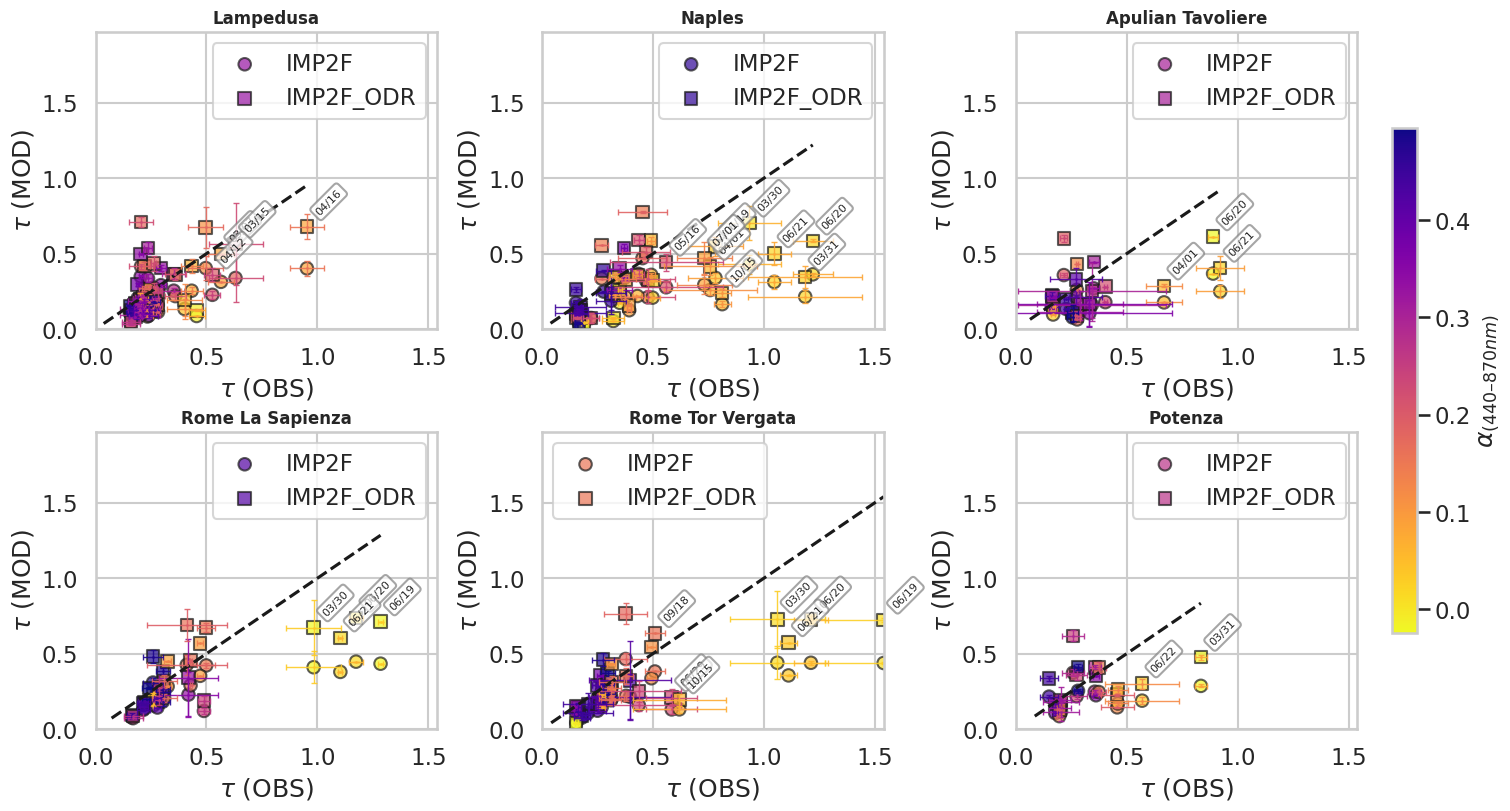

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

places = ['lampedusa_DD', 'napoli_DD', 'apulian_tavoliere_DD', 'roma_la_sapienza_DD', 
          'roma_tor_vergata_DD', 'potenza_DD']
models = ['IMP2F', 'IMP2F_ODR']
markers = ['o', 's']

place_names = {
    'lampedusa_DD': 'Lampedusa',
    'napoli_DD': 'Naples',
    'apulian_tavoliere_DD': 'Apulian Tavoliere',
    'roma_la_sapienza_DD': 'Rome La Sapienza',
    'roma_tor_vergata_DD': 'Rome Tor Vergata',
    'potenza_DD': 'Potenza'
}

cmap = "plasma_r"
n_cols = 3
n_rows = math.ceil(len(places)/n_cols)

# *** THRESHOLD FOR TIME LABELS ***
OBS_THRESHOLD = 0.5  # Adjust this value as needed

# Compute global min/max for Angström exponent
all_ang = np.concatenate([dataframes[p]['ang_440_870'].values for p in places])
all_obs = np.concatenate([dataframes[p]['LMP'].values for p in places])
all_pred = np.concatenate([dataframes[p][mod].values for p in places for mod in models])
global_min_ang = all_ang.min()
global_max_ang = all_ang.max()
norm = plt.Normalize(vmin=global_min_ang, vmax=global_max_ang)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*4), constrained_layout=True)
axs = axs.flatten()

for i, place in enumerate(places):
     
    if place == 'lampedusa_DD':
        df_dump = dataframes[place]
        df_dump['time'] = pd.to_datetime(df_dump['time'])
        t2_lampedusa = pd.Timestamp("2024-08-31")
        t3_lampedusa = dataframes["lampedusa_df"]['time'].iloc[-1]
        df = df_dump[(df_dump['time'] >= t2_lampedusa) & (df_dump['time'] <= t3_lampedusa)]
    else:
        df = dataframes[place]

    obs = df['LMP']
    ang = df['ang_440_870']
    preds = df[models]
    err_x = df['err_day_new']
    errs = df[['err_IMP2_24', 'err_IMP2_24_ODR']]
    
    # Make sure time column exists and is in datetime format
    if 'time' in df.columns:
        time_col = pd.to_datetime(df['time'])
    else:
        print(f"Warning: No 'time' column found for {place}")
        time_col = None

    colors = plt.colormaps.get_cmap(cmap)(norm(ang))
    ax = axs[i]

    for j, model in enumerate(models):
        sc = ax.scatter(obs, preds.iloc[:, j], c=ang, cmap=cmap, marker=markers[j],
                        edgecolor='k', alpha=0.7, label=model)

        for k in range(len(df)):
            ax.errorbar(
                obs.iloc[k], preds.iloc[k, j],
                xerr=err_x.iloc[k], yerr=errs.iloc[k, j],
                fmt='o', markersize=1,
                markerfacecolor='none', markeredgecolor=colors[k],
                ecolor=colors[k], elinewidth=1, capsize=2, alpha=0.9
            )

    # *** ADD TIME LABELS FOR HIGH VALUES ***
    if time_col is not None:
        high_obs_mask = obs > OBS_THRESHOLD
        
        for k in range(len(df)):
            if high_obs_mask.iloc[k]:
                # Format time label (you can customize this format)
                time_label = time_col.iloc[k].strftime('%m/%d')
                # Alternative formats:
                # time_label = time_col.iloc[k].strftime('%m/%d')  # Short format
                # time_label = time_col.iloc[k].strftime('%b %d')  # Month day
                
                # Position label slightly above the highest prediction for this point
                y_pos = max(preds.iloc[k, :]) + 0.02  # Adjust offset as needed
                x_pos = obs.iloc[k]
                
                # Add the text label
                ax.annotate(time_label, 
                           xy=(x_pos, y_pos),
                           xytext=(5, 5),  # Offset in points
                           textcoords='offset points',
                           fontsize=8,
                           ha='left',
                           va='bottom',
                           bbox=dict(boxstyle='round,pad=0.3', 
                                   facecolor='white', 
                                   alpha=0.7,
                                   edgecolor='gray'),
                           rotation=45)  # Rotate to avoid overlap

    min_val = min(obs.min(), preds.min().min())
    max_val = max(obs.max(), preds.max().max())
    ax.plot([min_val, max_val], [min_val, max_val], 'k--')
    ax.set_xlim(0., all_obs.max())
    ax.set_ylim(0., all_pred.max() + 0.2)  # Increased to accommodate labels
    
    ax.set_title(f"{place_names[place]}", fontweight="bold", fontsize=12)
    ax.set_xlabel(r'$\tau$ (OBS)')
    ax.set_ylabel(r'$\tau$ (MOD)')
    ax.legend()
    ax.grid(True)

for j in range(len(places), n_rows*n_cols):
    fig.delaxes(axs[j])

# Shared colorbar with global normalization
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=axs, orientation='vertical', fraction=0.02, pad=0.02)
cbar.set_label(r'$\alpha_{(440–870 nm)}$')

#plt.savefig("/home/andrea/enea/lmp_dust_enea/figure/stations_obs_mod_unite.png", dpi=300, format='png', bbox_inches='tight')
plt.show()